# Analysis of several CNN architectures optimized for the multifruit dataset


This notebook contains the analyis of hyperparameter optimizations of several CNN architectures aimed at predicting dry matter content in fruit. A data set with several fruits is used as study case.

This notebook is accompanying the manuscript "Deep Tutti Frutti: exploring CNN architectures for dry matter prediction in fruit from multi-fruit near-infrared spectra" by D. Passos and P. Mishra,  Chemometrics and Intelligent Laboratory Systems (2023), (LINK)...

The order of the models analysis is: v_1, v_1B, v_1D, v_1C, v_1F, v_2, v_2B, ...
Some file names were renamed at the time of revision of the manuscript in order to maintain consistency. This means that some files names or variable names might not match the expected nomenclature.

**NOTE**: Please be aware that this file was created for personal use and not specifically for distribution. Although I revised this file a few times, it is possible that some errors remain.

*Original source name: Multifruti_HPO_analysis_2.ipynb*

## 1) Import packages

In [1]:
import os
import sys
from sys import stdout
import logging
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns 
import pandas as pd
from IPython.display import clear_output
import scipy.io as sio
from scipy.signal import savgol_filter
import tqdm
from itertools import permutations
import sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback,  ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model 
import tensorflow_addons as tfa
from plot_model import plot_model

import optuna
import GPUtil
from tabulate import tabulate
import psutil
import platform
import socket
from datetime import datetime 


c:\Users\dario\miniconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


For future refence, we list the main versions of the main software packages and used hardware. You can skip running this cell.

In [2]:
## Choose just GPU:1
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Print machine info
print('\n--------  Running @',socket.gethostname(),' using ', platform.platform(),'--------\n' )
# Get current date and time
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("Last run at =", dt_string) 

## Print versions and hardware info
print('\n-------- SOFTWARE INFO --------')
print('Python ', sys.version)
print('Tensorflow ', tf.__version__)
print('Tensorflow add-ons ', tfa.__version__)
print('tqdm ', tqdm.__version__)
print('Numpy ', np.__version__)
print('Pandas', pd.__version__)
print('Optuna ', optuna.__version__)
print('Scikit-learn ', sklearn.__version__)
# print('livelossplot ', livelossplot.__version__)

## print hardware info
print('\n-------- HARDWARE INFO --------')
# CPU
print('CPU:', platform.processor())
print("\tPhysical cores:", psutil.cpu_count(logical=False))
print("\tTotal cores:", psutil.cpu_count(logical=True))
cpufreq = psutil.cpu_freq()
print(f"\tMax Frequency: {cpufreq.max:.2f}Mhz")
# RAM
print(f'RAM: {int(np.round(psutil.virtual_memory().total / (1024. **3)))} Gb')
# GPU
print('GPU available: ', tf.config.list_physical_devices('GPU'))
print("="*40, "GPU Details", "="*40)
gpus = GPUtil.getGPUs()
list_gpus = []
for gpu in gpus:
    # get the GPU id
    gpu_id = gpu.id
    # name of GPU
    gpu_name = gpu.name
    # get % percentage of GPU usage of that GPU
    gpu_load = f"{gpu.load*100}%"
    # get free memory in MB format
    gpu_free_memory = f"{gpu.memoryFree}MB"
    # get used memory
    gpu_used_memory = f"{gpu.memoryUsed}MB"
    # get total memory
    gpu_total_memory = f"{gpu.memoryTotal}MB"
    # get GPU temperature in Celsius
    gpu_temperature = f"{gpu.temperature} °C"
    gpu_uuid = gpu.uuid
    list_gpus.append((
        gpu_id, gpu_name, gpu_load, gpu_free_memory, gpu_used_memory,
        gpu_total_memory, gpu_temperature, gpu_uuid
    ))

print(tabulate(list_gpus, headers=("id", "name", "load", "free memory", "used memory", "total memory",
                                   "temperature", "uuid")))

print('\nIs CUDA accessible by the GPU? ', tf.test.is_built_with_cuda())


--------  Running @ Athena  using  Windows-10-10.0.23580-SP0 --------

Last run at = 02/11/2023 12:58:38

-------- SOFTWARE INFO --------
Python  3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Tensorflow  2.10.0
Tensorflow add-ons  0.20.0
tqdm  4.64.1
Numpy  1.24.2
Pandas 2.0.3
Optuna  3.2.0
Scikit-learn  1.2.2

-------- HARDWARE INFO --------
CPU: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
	Physical cores: 24
	Total cores: 32
	Max Frequency: 3000.00Mhz
RAM: 64 Gb
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
======================================== GPU Details ========================================
  id  name                        load    free memory    used memory    total memory    temperature    uuid
----  --------------------------  ------  -------------  -------------  --------------  -------------  ----------------------------------------
   0  NVIDIA GeForce RTX 2080 Ti  4.0%    9960

## 2) Help functions
In this section we implement a series of help functions that will be used during the optimization procedure. Run every cell once to ensure that all help functions are loaded.

In [3]:
## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

reproducible_comp()

Axiliary function to compute error metrics and make prediction plots

In [4]:
## Function to compute metrics and make prediction plots using train and test data
def plot_prediction2(Y_train, Y_test, Y_train_pred, Y_test_pred, title, savefig=False, figname=None):
    
    ## Compute train error scores 
    score_p0 = r2_score(Y_train, Y_train_pred)
    mse_p0 = mean_squared_error(Y_train, Y_train_pred)
    rmse_p0 = np.sqrt(mse_p0)
           
    ## Compute test error scores 
    score_p2 = r2_score(Y_test, Y_test_pred)
    mse_p2 = mean_squared_error(Y_test, Y_test_pred)
    rmse_p2 = np.sqrt(mse_p2)
  
    print('ERROR METRICS: \t TRAIN  \t\t TEST')
    print('------------------------------------------------------')
    print('R2:   \t\t %5.3f  \t\t %5.3f'  % (score_p0, score_p2 ))
    print('RMSE: \t\t %5.3f  \t\t %5.3f' % (rmse_p0, rmse_p2)) 
 
    #### Plot regression for model predicted data
    ## Get plot limits
    Y = np.concatenate([y_train, y_test])

    rangey = np.max(Y) - np.min(Y)
    rangex = np.max(Y) - np.min(Y)
    ## x=y line and +- 1std upper and lower bowndaries
    xy_x=np.ravel([np.min(Y)-0.1*rangex, np.max(Y)+0.1*rangex])
    xy_y=np.ravel([np.min(Y)-0.1*rangey, np.max(Y)+0.1*rangey])

    plt.figure(figsize=(5,5))
    z = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_pred), 1)
    print('Fit result: Y=',z[1], ' + ', z[0],' * X')
    ax = plt.subplot(aspect=1)
    ax.plot(xy_x, xy_y, 'k--', linewidth=2, label=None)
    ax.scatter(Y_train, Y_train_pred, c='gray', marker='o', s=20, alpha=0.66, label='train')
    ax.scatter(Y_test,Y_test_pred, s=40, marker='o', facecolors='None', edgecolors='r', label='test')
    # Calculate the range of x-axis based on Y_train and Y_test
    x_min = min(np.min(Y_train), np.min(Y_test))
    x_max = max(np.max(Y_train), np.max(Y_test))
    # Create an array spanning the range of x-axis
    x_range = np.linspace(x_min, x_max, num=100)
    ax.plot(x_range, z[1]+z[0]*x_range, c='blue', linewidth=2,label='linear fit')
    plt.xlim(xy_x)
    plt.ylim(xy_y)
    # ax.plot(x_range, x_range, 'k--', linewidth=1.5, label='y=x')
    plt.ylabel('Predicted DM')
    plt.xlabel('Measured DM')
    plt.title(title)
    plt.legend(loc=4, frameon=False)
    
    # Print the scores on the plot
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.1*rangey, 'R$^{2}=$ %5.2f'  % score_p2, fontsize=13)
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.15*rangey, 'RMSE: %5.2f' % rmse_p2, fontsize=13)
    if savefig==True:
        plt.savefig(figname, dpi=150)
        print('Figure saved')
    else:    
        plt.show() 
    return 


## Function to compute metrics and make prediction plots (custom version of previous function)
def plot_Y_prediction(Y, Y_pred, title, ax, savefig=False, figname=None):
    ## Compute train error scores 
    score_p0 = r2_score(Y, Y_pred)
    mse_p0 = mean_squared_error(Y, Y_pred)
    rmse_p0 = np.sqrt(mse_p0)
#     print('R2: \t\t %5.3f '  % (score_p0))
#     print('RMSE: \t\t %5.3f' % (rmse_p0))
    ## Plot regression for PLS predicted data
    rangey = max(Y) - min(Y)
    rangex = max(Y_pred) - min(Y_pred)
    fig=plt.figure(figsize=(3,3))
    z = np.polyfit(np.ravel(Y), np.ravel(Y_pred), 1)
    print('Fit result: Y=',z[1], ' + ', z[0],' * X')
    # ax = plt.subplot(aspect=1)
    ax.scatter(Y,Y_pred,c='k',marker='o',s=10, alpha=0.6)
    ax.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=2,label='linear fit')
    ax.plot(Y, Y, 'k--', linewidth=1.5, label='y=x')
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Measured')
    ax.set_title(title)
#     plt.legend(loc=4)   
    # Print the scores on the plot
    ax.text(min(Y_pred)+0.02*rangex, max(Y)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p0)
    ax.text(min(Y_pred)+0.02*rangex, max(Y)-0.15*rangey, 'RMSE: %5.3f' % rmse_p0)
    if savefig==True:
        plt.savefig(figname, dpi=150)
        print('Figure saved')
    else:    
        plt.show() 
    return 




### Functions for computing and optimizing PLS models ############

from chemometrics_analysis_help import *

def pls_optimization_cv_stop2(x_train, y_train, nmax=20, Nfolds=5, plot_opt=False, stop_criteria=0.01):
    """
    This function computes the optimal number of LVs for a PLS model using cross-validation using as stop criteria
    the LV that produces a gain in the CV RMSE lower than 1% of the previous LV.
    """
    ## List to store the CV RMSE for each LV
    cv_rmse=[]

    print('\nComputing optimal number of LVs for PLS model in the range 1 to {}...\n'.format(nmax))
    component = np.arange(1, nmax+1)
    previous_cv_rmse = None
    bestLV_stop = None
    
    print('Stop criteria: {}% gain in RMSE'.format(stop_criteria*100))

    for i in component:
        pls = PLSRegression(n_components=i, scale=True)
        cv_score=cross_val_score(pls, x_train, y_train, cv=KFold(Nfolds, shuffle = True, random_state=42),\
                        n_jobs=-1, scoring='neg_mean_squared_error', error_score=0)
        current_cv_rmse = np.round(np.sqrt(-np.mean(cv_score)),3)  
        ## Check if the current CV RMSE is less than 1% of the previous CV RMSE
        if (previous_cv_rmse is not None) and (current_cv_rmse <= np.min(cv_rmse)):
            percent_diff = abs((current_cv_rmse - previous_cv_rmse) / previous_cv_rmse)
            # print(f'Compute difference percentage between current LV={i} and previous LV={i-1} CV RMSE -> {np.round(percent_diff*100,3)}%')
            if percent_diff <= stop_criteria and bestLV_stop is None:               
                print(f"Stopping criteria reached, {np.round(percent_diff*100,3)}%. Saving component number.")
                ## The previous LV is the last one that adds more than 1% of gain in RMSE
                bestLV_stop = i-1 
                ## Save the RMSE of the previous LV
                RMSE_stop = previous_cv_rmse
        previous_cv_rmse = current_cv_rmse
        cv_rmse.append(current_cv_rmse)
        criterion_flag = '1% gain'

    ## if the 1% criteria returns no LV, then the bestLV_stop is the one where the RMSE is minimum
    if bestLV_stop is None:
        print(f'Stop criteria of {stop_criteria*100}% gain in RMSE not reached. Using minimum RMSE.')
        bestLV_stop = np.argmin(cv_rmse)+1
        RMSE_stop = np.min(cv_rmse)
        criterion_flag = 'minimum RMSE'
    
    RMSE_best = np.round(np.min(RMSE_stop),3)
    print(f'Suggested number of LV based on {Nfolds}-fold CV RMSE using {criterion_flag}: {bestLV_stop}')
    print(f'{Nfolds} CV RMSE: {RMSE_best}')
    stdout.write("\n")
    if plot_opt is True:
        plt.figure(figsize=(9,3))
        ax1=plt.subplot()
        ax1.plot(component[:len(cv_rmse)], np.array(cv_rmse), '-v', color = 'blue', mfc='blue')
        if bestLV_stop is not None:
            ax1.plot(component[bestLV_stop-1], [RMSE_best], 'P', ms=10, mfc='red',label='LV chosen')
        plt.xlabel('Number of PLS components')
        plt.ylabel('Mean of '+str(Nfolds)+'CV RMSE ')
        ax1.axvline(x=bestLV_stop, color='red', lw=1,linestyle='--')
        ax1.set_xticks(component)
        plt.xlim(0, nmax+1)
        # plt.title('# PLS components')
        plt.legend()
        plt.grid(alpha=0.33)
        plt.show()
    return bestLV_stop, RMSE_best




def pls_prediction_metrics2(l, x_train, y_train, x_test, y_test, xname, yname, lv, verbose=True, plot_pred=False, plot_vip=False):
    """
    USE: pls_prediction_metrics(x_train, y_train, x_test, y_test, yname, lv, plot_pred=False)
    Data X and Y should be numpy arrays...
    #################
    l: vector with wavelenghts for plots x scale
    x_train, y_train: train dataset
    x_test, y_test:   test dataset
    xname:  name of x data (for plots)
    yname:  name of y data (for plots)
    lv:     number of latent variables for PLS model
    verbose: True (False) for output text with results
    plot_pred: False (True) for plot predictions
    plot_vip: False (True) for plot of VIP scores
    ##################
    OUTPUT: several error metrics for train and test sets...
    """
    ## Define PLS with suggested optimal number of components and fit train data
    pls1 = PLSRegression(n_components=lv, scale=True)
    
    ## Fit PLS model to train data
    pls1.fit(x_train, y_train)
    
    ## Get predictions for train and test sets
    y_train_pred = pls1.predict(x_train)
    y_test_pred = pls1.predict(x_test)
    
    ## Compute error metrics
    R2_train, RMSE_train, PG_train, CVAR_train, SDR_train = error_metrics(y_train, y_train_pred)
    R2_test, RMSE_test, PG_test, CVAR_test, SDR_test = error_metrics(y_test, y_test_pred)
    
    if verbose == True:
        print('\nError metrics for best PLS model with LV = {}'.format(lv))
        print('METRIC \t TRAIN \t TEST ')
        print('R2     \t {:0.3f}\t {:0.3f}'.format(R2_train,R2_test))
        print('RMSE   \t {:0.3f}\t {:0.3f}'.format(RMSE_train,RMSE_test))
        print('PG   \t {:0.3f}\t {:0.3f}'.format(PG_train,PG_test))
        print('CVAR   \t {:0.3f}\t {:0.3f}'.format(CVAR_train,CVAR_test))
        print('SDR  \t {:0.3f}\t {:0.3f}'.format(SDR_train,SDR_test))
    
    ## Plots: MSE vs. PLS LV and regression for best PLS model 
    # Get plot limits
    Y = np.concatenate([y_train, y_test])

    rangey = np.max(Y) - np.min(Y)
    rangex = np.max(Y) - np.min(Y)
    
    # x=y line and +- 1std upper and lower bowndaries
    xy_x=np.ravel([np.min(Y)-0.1*rangex, np.max(Y)+0.1*rangex])
    xy_y=np.ravel([np.min(Y)-0.1*rangey, np.max(Y)+0.1*rangey])

    xy_y_up=xy_y+np.std(Y)
    xy_y_down=xy_y-np.std(Y)
   
    if plot_pred is True:
        ## linear fit to predicted test data
        plt.figure(figsize=(5,5))
        # plt.title(yname+' prediction using '+xname+' data')
       
        ## fit the test data
        z = np.polyfit(np.ravel(y_test), np.ravel(y_test_pred), 1)
        print('Fit result: Y=',z[1], ' + ', z[0],' * X')
        ax = plt.subplot()
        ax.plot(xy_x, xy_y, 'k--', linewidth=2, label = None)
        # plt.fill_between(xy_x, xy_y_down, xy_y_up, alpha=0.2)
        ax.scatter(y_train,y_train_pred,c='gray',s=26, marker='o', alpha=0.66, label='Train')
        ax.scatter(y_test,y_test_pred,s=40, marker='o', facecolors='None', edgecolors='r', label='Test')
        x_range = np.linspace(np.min(Y), np.max(Y), num=100)
        ax.plot(x_range, z[1]+z[0]*x_range, c='blue', linewidth=3, label = None)
        plt.xlim(xy_x)
        plt.ylim(xy_y)
        plt.ylabel('Predicted '+yname, fontsize=10)
        plt.xlabel('Measured '+yname, fontsize=10)
        plt.legend(loc=4)
        # Print the test error metrics on the plot
        plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.1*rangey, 'R$^{2}=$ %5.2f'  % R2_test, fontsize=13)
        plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.15*rangey, 'RMSE: %5.2f' % RMSE_test, fontsize=13)
        # plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.2*rangey, 'PG: %5.2f' % PG_test, fontsize=13)
        # plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.25*rangey, 'CVar: %5.2f%%' % CVAR_test, fontsize=13)
        plt.show()    

    if plot_vip is True:
        pls_vip=vip(pls1)
        fig, ax = plt.subplots(figsize=(12,3))
        # plt.title('PLS VIP scores ')
        plt.ylabel('VIP score', fontsize=14)
        plt.xlabel('Wavelength (nm)', fontsize=14)
        ax.plot(l,pls_vip,'k',label='VIP scores')
        ax.set_ylim(np.min(pls_vip), np.max(pls_vip))
        plt.axhline(1,color='k', linestyle='--',linewidth=0.75)
        plt.legend()
        plt.show()
        
    return R2_train, RMSE_train, PG_train, CVAR_train, SDR_train, R2_test, RMSE_test, PG_test, CVAR_test, SDR_test, y_train_pred, y_test_pred


def pls_explained_variance(pls, X, Y_true, do_plot=True):
    r2 = np.zeros(pls.n_components)
    x_transformed = pls.transform(X) # Project X into low dimensional basis
    for i in range(0, pls.n_components):
        Y_pred = (np.dot(x_transformed[:, i][:, np.newaxis],
                         pls.y_loadings_[:, i][:, np.newaxis].T) * pls._y_std   
                  + pls._y_mean)
        r2[i] = r2_score(Y_true, Y_pred)
        overall_r2 = r2_score(Y_true, pls.predict(X))  # Use all components together.

    if do_plot:
        plt.figure(figsize=(5,5))
        component = np.arange(pls.n_components) + 1
        plt.bar(component, r2)
        plt.xticks(component)
        plt.xlabel('Number of PLS components')
        plt.ylabel('Explained variance')
        # plt.title(f'Summed individual r2: {np.sum(r2):.3f}, '
        #           f'Overall r2: {overall_r2:.3f}')
        plt.show()

    return r2, overall_r2


Set parameters for graphics formating

In [5]:
## Graphics settings
## Setting the font sizes for comming figures
plt.style.use("default")
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

## uncomment for Latex graphics formating
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Times"]})

# plt.rc('text', usetex=True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 3) Data wrangling

### 3.1) Loading the multifruit dataset

Read the data (matlab format) using the scipy.io module. The spectral data is already pre-processed as the 2nd derivative (output format directly from the spectrometer). The Y data corresponds to the Dry Matter content for each sample.

In [6]:
data = sio.loadmat('data/multifruit_DL.mat')
print(data.keys())

## wavelenght for plots
w = np.ravel(data['wavelength'])

dict_keys(['__header__', '__version__', '__globals__', 'apple_sp', 'avocado_sp', 'dm_apple', 'dm_avocado', 'dm_kiwi', 'dm_mango', 'dm_pear', 'kiwi_sp', 'mango_sp', 'pear_sp', 'wavelength'])


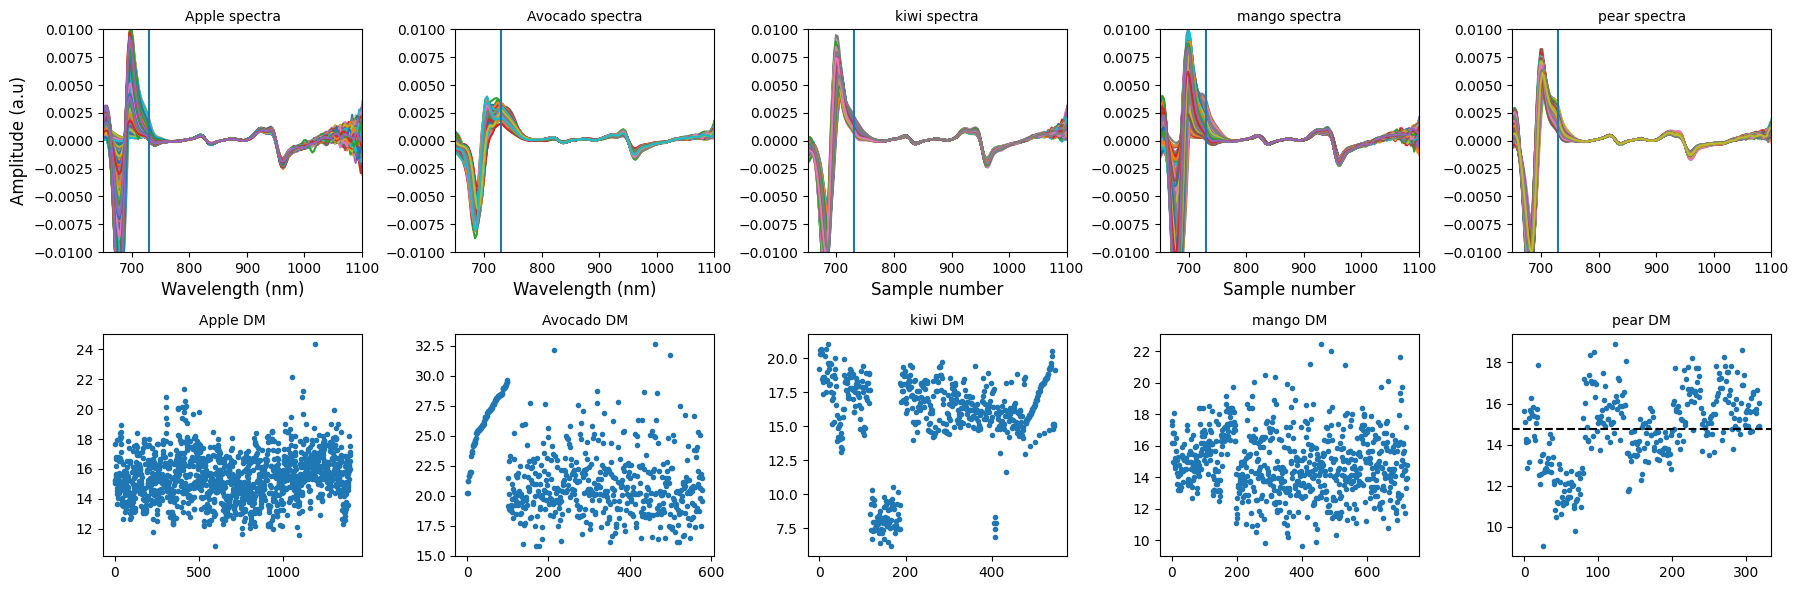

In [7]:
plt.figure(figsize=(18,6))
plt.subplot(251)
plt.title('Apple spectra')
plt.plot(w, data['apple_sp'].T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Wavelength (nm)')
plt.axvline(730)
plt.xlim(650, 1100)
plt.ylim(-0.01,0.01)
plt.subplot(252)
plt.title('Avocado spectra')
plt.plot(w, data['avocado_sp'].T)
plt.axvline(730)
plt.xlim(650, 1100)
plt.ylim(-0.01,0.01)
plt.xlabel('Wavelength (nm)')
plt.subplot(253)
plt.title('kiwi spectra')
plt.plot(w, data['kiwi_sp'].T)
plt.axvline(730)
plt.xlim(650, 1100)
plt.ylim(-0.01,0.01)
plt.xlabel('Sample number')
plt.subplot(254)
plt.title('mango spectra')
plt.plot(w, data['mango_sp'].T)
plt.axvline(730)
plt.xlim(650, 1100)
plt.ylim(-0.01,0.01)
plt.xlabel('Sample number')
plt.subplot(255)
plt.title('pear spectra')
plt.plot(w, data['pear_sp'].T)
plt.axvline(730)
plt.xlim(650, 1100)
plt.ylim(-0.01,0.01)


plt.subplot(256)
plt.title('Apple DM')
plt.scatter(np.arange(len(data['dm_apple'])), data['dm_apple'].T, marker='.')

plt.subplot(257)
plt.title('Avocado DM')
plt.scatter(np.arange(len(data['dm_avocado'])), data['dm_avocado'].T, marker='.')

plt.subplot(258)
plt.title('kiwi DM')
plt.scatter(np.arange(len(data['dm_kiwi'])), data['dm_kiwi'].T, marker='.')

plt.subplot(259)
plt.title('mango DM')
plt.scatter(np.arange(len(data['dm_mango'])), data['dm_mango'].T, marker='.')

plt.subplot(2,5,10)
plt.title('pear DM')
plt.scatter(np.arange(len(data['dm_pear'])), data['dm_pear'].T, marker='.')
plt.axhline(np.mean(data['dm_pear']), color='k', linestyle='--')
plt.tight_layout()
plt.show()

In this study we do not use the avocado data.

In the next step we choose the spectral range that we will use in this study. In this case we restrict to wavelenght above 735 nm to account only for NIR features and avoid the VIS range where the spectral features change due to the different colors of the fruit peels.

In [8]:
## Wavelength range for analysis
print(f'From {w[150]} nm to {w[255]} nm')

From 735 nm to 1050 nm


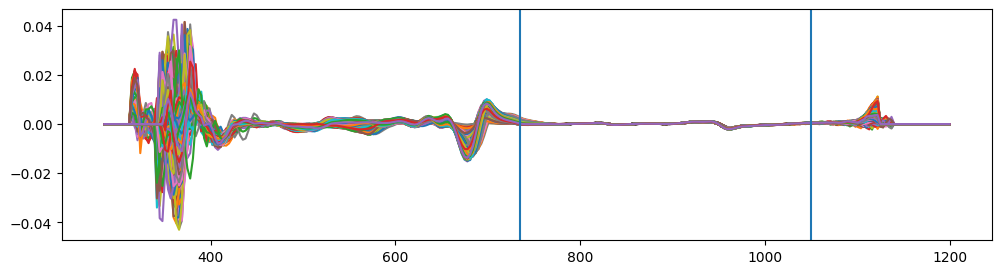

(725, 105)


In [9]:
## initial and final spectral features
wi = 150
wf = 255
plt.figure(figsize=(12,3))
plt.plot(w,data['mango_sp'].T)
plt.axvline(w[wi])
plt.axvline(w[wf])
plt.show()

print(np.shape(data['mango_sp'][:,wi:wf]))

Next we create the class of each fruit for the classification part of the problem:
- 'Apple': 0 
 - 'Kiwi': 1
 - 'Mango': 2
 - 'Pear': 3 
 - 'Avocado': 4

In [10]:
class_apple = np.tile(np.array([0]), np.shape(data['dm_apple']))
class_kiwi  = np.tile(np.array([1]), np.shape(data['dm_kiwi']))
class_mango = np.tile(np.array([2]), np.shape(data['dm_mango']))
class_pear  = np.tile(np.array([3]), np.shape(data['dm_pear']))
class_avocado = np.tile(np.array([4]), np.shape(data['dm_avocado']))#, num_classes = 5)

Train and test split. Further ahead we will split the training set into "calibration" and "validation" subsets. This training sub-partition is used for the hyperparameter optimization of the several CNN architectures tested. 

In [11]:
## initial and final spectral features
wi = 150
wf = 255

## Split each fruit data into train / test splits
x_apple_train, x_apple_test, y_apple_train, y_apple_test, class_apple_train, class_apple_test = train_test_split(data['apple_sp'][:,wi:wf], \
                                                                                                                 data['dm_apple'], class_apple, \
                                                                                                                 test_size=0.2, random_state=42)
x_avocado_train, x_avocado_test, y_avocado_train, y_avocado_test, class_avocado_train, class_avocado_test = train_test_split(data['avocado_sp'][:,wi:wf], \
                                                                                                                             data['dm_avocado'], class_avocado,\
                                                                                                                             test_size=0.2, random_state=42)
x_kiwi_train, x_kiwi_test, y_kiwi_train, y_kiwi_test, class_kiwi_train, class_kiwi_test = train_test_split(data['kiwi_sp'][:,wi:wf], \
                                                                                                           data['dm_kiwi'], class_kiwi, \
                                                                                                           test_size=0.2, random_state=42)
x_mango_train, x_mango_test, y_mango_train, y_mango_test, class_mango_train, class_mango_test = train_test_split(data['mango_sp'][:,wi:wf], \
                                                                                                                 data['dm_mango'], class_mango,\
                                                                                                                 test_size=0.2, random_state=42)
x_pear_train, x_pear_test, y_pear_train, y_pear_test, class_pear_train, class_pear_test = train_test_split(data['pear_sp'][:,wi:wf], \
                                                                                                           data['dm_pear'], class_pear, \
                                                                                                           test_size=0.2, random_state=42)
## List dimensions of each dataset
print('Datasets dimensions:')
print('Apple: train {}, test {} '.format([x_apple_train.shape, y_apple_train.shape],[x_apple_test.shape, y_apple_test.shape]))
print('Kiwi: train {}, test {} '.format([x_kiwi_train.shape, y_kiwi_train.shape],[x_kiwi_test.shape, y_kiwi_test.shape]))
print('Mango: train {}, test {} '.format([x_mango_train.shape, y_mango_train.shape],[x_mango_test.shape, y_mango_test.shape]))
print('Pear: train {}, test {} '.format([x_pear_train.shape, y_pear_train.shape],[x_pear_test.shape, y_pear_test.shape]))
print('Avocado: train {}, test {} '.format([x_avocado_train.shape, y_avocado_train.shape],[x_avocado_test.shape, y_avocado_test.shape]))

Datasets dimensions:
Apple: train [(1124, 105), (1124, 1)], test [(281, 105), (281, 1)] 
Kiwi: train [(438, 105), (438, 1)], test [(110, 105), (110, 1)] 
Mango: train [(580, 105), (580, 1)], test [(145, 105), (145, 1)] 
Pear: train [(255, 105), (255, 1)], test [(64, 105), (64, 1)] 
Avocado: train [(464, 105), (464, 1)], test [(116, 105), (116, 1)] 


In [12]:
## Create lists with multi fruit data for train and test and uniformize the data type. 

## This is the step where we exclude the avocado data from the full dataset
## This full dataset will be used further ahead in the analysis
x_full_list = [data['apple_sp'][:,wi:wf].astype(np.float32), data['kiwi_sp'][:,wi:wf].astype(np.float32), 
               data['mango_sp'][:,wi:wf].astype(np.float32), data['pear_sp'][:,wi:wf].astype(np.float32)]

y_full_list = [data['dm_apple'].astype(np.float32), data['dm_kiwi'].astype(np.float32),
               data['dm_mango'].astype(np.float32), data['dm_pear'].astype(np.float32)]

class_full_list = [class_apple, class_kiwi, class_mango, class_pear]


## Separate train and test data into lists that mix all fruits (in these the avocado data is still included but will be removed later)
## Train data
x_train_list = [x_apple_train.astype(np.float32), x_kiwi_train.astype(np.float32),  x_mango_train.astype(np.float32), \
                x_pear_train.astype(np.float32), x_avocado_train.astype(np.float32)]

y_train_list = [y_apple_train.astype(np.float32), y_kiwi_train.astype(np.float32), y_mango_train.astype(np.float32),
                y_pear_train.astype(np.float32), y_avocado_train.astype(np.float32)]

class_train_list = [class_apple_train, class_kiwi_train, class_mango_train, class_pear_train, class_avocado_train]

## Test data
x_test_list = [x_apple_test.astype(np.float32), x_kiwi_test.astype(np.float32),  x_mango_test.astype(np.float32), \
               x_pear_test.astype(np.float32), x_avocado_test.astype(np.float32)]
y_test_list = [y_apple_test.astype(np.float32), y_kiwi_test.astype(np.float32), y_mango_test.astype(np.float32),\
               y_pear_test.astype(np.float32), y_avocado_test.astype(np.float32)]

class_test_list = [class_apple_test, class_kiwi_test, class_mango_test, class_pear_test, class_avocado_test]

## Create a list with the names of the fruits
fruits = ['Apple', 'Kiwi', 'Mango', 'Pear', 'Avocado']


### 3.2) Data pre-processing and train test split

In [13]:
## Since the test set is unknown (we are not suppose to have access to it during the
## optimization of the model) the scalling process should take this into account. We
## have to define a scaler based only on the train data, and apply it to the test data.

def standardize_column(X_train, X_test):
    ## We train the scaler on the full train set and apply it to the test set
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return [X_train_scaled, X_test_scaled]

Standardize the train and test datasets. Standardization is advised because the CNN gradient descent optimizer tend to work better.

In [14]:
## X - Spectra
## Standardize on columns (Leaving out avocado data, the last item of the list)
x_train_scaled_col, x_test_scaled_col = standardize_column(np.concatenate(x_train_list[:-1]), np.concatenate(x_test_list[:-1]))

## Y - Dry Matter
y_train = np.concatenate(y_train_list[:-1])
y_test = np.concatenate(y_test_list[:-1])

x_full = np.concatenate(x_full_list)
y_full = np.concatenate(y_full_list)

## Class - 0,1,2,3
class_train = np.concatenate(class_train_list[:-1])
class_test = np.concatenate(class_test_list[:-1])

class_full = np.concatenate(class_full_list)

## Label - [1,0,0,0,0], ...
## one-hot-encode classes into encoded labels
labels_train = to_categorical(class_train,num_classes = 4)
labels_test = to_categorical(class_test,num_classes = 4)

labels_full = to_categorical(class_full,num_classes = 4)

## Print the number of samples in each dataset
print('Percentage of each fruit in the train dataset:')
for i,j in enumerate(y_train_list[:-1]):
    print(fruits[i], np.round(np.shape(j)[0]/len(y_train)*100,2), '%')

print('\n\nNumber of fruit in the train/test:')
print('Fruit \t Train \t Test')
print('--------------------------')
for i,j in enumerate(y_test_list[:-1]):
    print(fruits[i], '\t',np.shape(y_train_list[:-1][i])[0], '\t',np.shape(j)[0])
print('--------------------------')
print(f'All \t {np.shape(y_train)[0]} \t {np.shape(y_test)[0]}')

print('\n\nNumber of fruit in the full dataset:', len(y_full))

Percentage of each fruit in the train dataset:
Apple 46.89 %
Kiwi 18.27 %
Mango 24.2 %
Pear 10.64 %


Number of fruit in the train/test:
Fruit 	 Train 	 Test
--------------------------
Apple 	 1124 	 281
Kiwi 	 438 	 110
Mango 	 580 	 145
Pear 	 255 	 64
--------------------------
All 	 2397 	 600


Number of fruit in the full dataset: 2997


In [15]:
## Print the mean and std of DM for each fruit in the full dataset
print('Mean and std of DM for each fruit:')
print('\nFruit \t Mean \t\t Std')
print('---------------------------------')
for i,j in enumerate(y_full_list):
    print(fruits[i], '\t',np.round(np.mean(j),3), '\t',np.round(np.std(j),3))
print('----------------------------------')



Mean and std of DM for each fruit:

Fruit 	 Mean 		 Std
---------------------------------
Apple 	 15.499 	 1.576
Kiwi 	 15.644 	 3.336
Mango 	 14.901 	 2.006
Pear 	 14.757 	 1.81
----------------------------------


In [16]:
## Export the train and test data to csv files for later reproducibility
# df_train.to_csv('multifruit_train.csv', index=False)
# df_test.to_csv('multifruit_test.csv', index=False)

### 3.3) Additional plots, distributions, etc.

In [19]:
apple_color = "#D32F2F"  # Red
kiwi_color = "#558B2F"   # Dark Green
mango_color = "#FFA000"   # Orange
pear_color = "#6495ED"    # Is blue but it should be "#9CCC65" # Lighter Green
# Create custom color palette
fruit_colors = sns.color_palette([apple_color, kiwi_color, mango_color, pear_color])

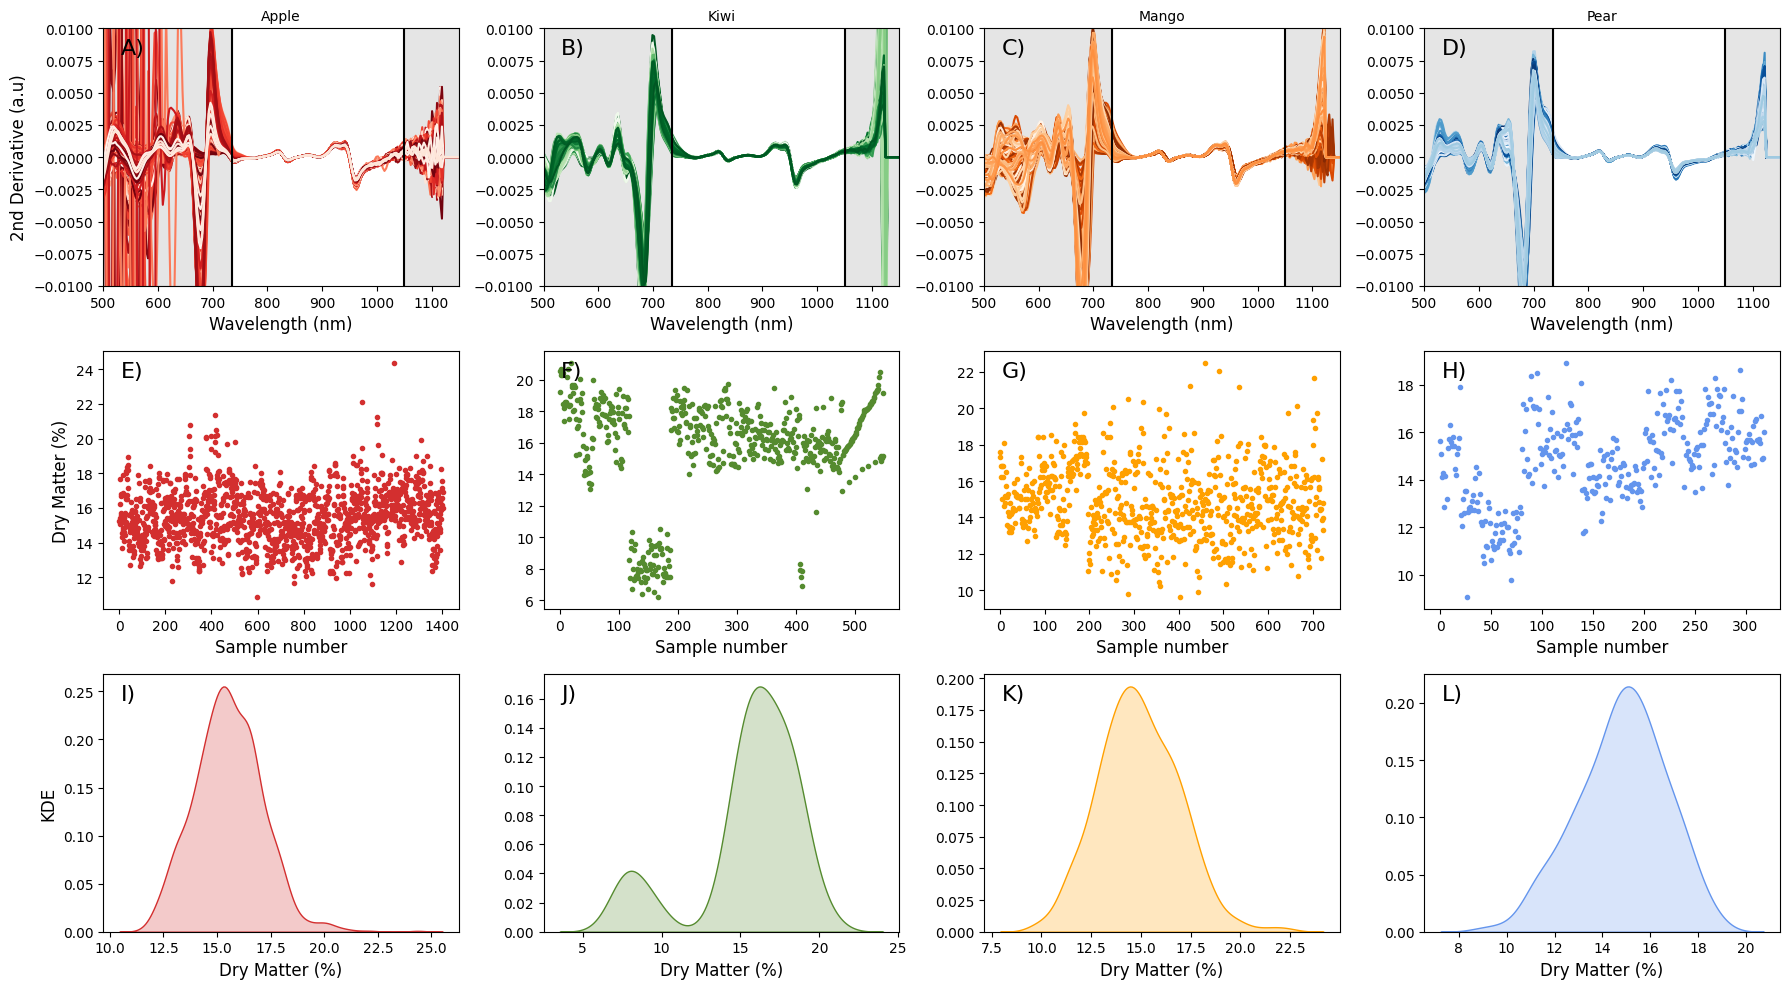

In [20]:
from cycler import cycler
red_colors=sns.color_palette("Reds", n_colors=50)
green_colors=sns.color_palette("Greens", n_colors=50)
orange_colors=sns.color_palette("Oranges", n_colors=50)
blue_colors=sns.color_palette("Blues", n_colors=50)


plt.figure(figsize=(18,10))
plt.rcParams['axes.prop_cycle'] = cycler(color=red_colors)
ax = plt.subplot(3,4,1)
plt.title('Apple')
plt.plot(w, data['apple_sp'].T)
plt.ylabel('2nd Derivative (a.u)')
plt.xlabel('Wavelength (nm)')
plt.axvline(w[wi],c='k')
plt.axvline(w[wf],c='k')
plt.xlim(500, 1150)
plt.ylim(-0.01,0.01)
plt.axvspan(500, w[wi], alpha=0.2, color='gray')
plt.axvspan(w[wf], 1150, alpha=0.2, color='gray')
plt.text(0.05, 0.9, 'A)', fontsize=16,  color='k', transform=ax.transAxes)

plt.rcParams['axes.prop_cycle'] = cycler(color=green_colors)
ax1 = plt.subplot(3,4,2)
plt.title('Kiwi')
plt.plot(w, data['kiwi_sp'].T)
plt.axvline(w[wi],c='k')
plt.axvline(w[wf],c='k')
plt.xlim(500, 1150)
plt.ylim(-0.01,0.01)
plt.xlabel('Wavelength (nm)')
plt.axvspan(500, w[wi], alpha=0.2, color='gray')
plt.axvspan(w[wf], 1150, alpha=0.2, color='gray')
plt.text(0.05, 0.9, 'B)', fontsize=16,  color='k', transform=ax1.transAxes)

plt.rcParams['axes.prop_cycle'] = cycler(color=orange_colors)
ax2 = plt.subplot(3,4,3)
plt.title('Mango')
plt.plot(w, data['mango_sp'].T)
plt.axvline(w[wi],c='k')
plt.axvline(w[wf],c='k')
plt.xlim(500, 1150)
plt.ylim(-0.01,0.01)
plt.xlabel('Wavelength (nm)')
plt.axvspan(500, w[wi], alpha=0.2, color='gray')
plt.axvspan(w[wf], 1150, alpha=0.2, color='gray')
plt.text(0.05, 0.9, 'C)', fontsize=16,  color='k', transform=ax2.transAxes)

plt.rcParams['axes.prop_cycle'] = cycler(color=blue_colors)
ax3 = plt.subplot(3,4,4)
plt.title('Pear')
plt.plot(w, data['pear_sp'].T)
plt.axvline(w[wi],c='k')
plt.axvline(w[wf],c='k')
plt.xlim(500, 1150)
plt.ylim(-0.01,0.01)
plt.xlabel('Wavelength (nm)')
plt.axvspan(500, w[wi], alpha=0.2, color='gray')
plt.axvspan(w[wf], 1150, alpha=0.2, color='gray')
plt.text(0.05, 0.9, 'D)', fontsize=16,  color='k',transform=ax3.transAxes)
## reset
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

ax4 = plt.subplot(3,4,5)
plt.scatter(np.arange(len(data['dm_apple'])), data['dm_apple'].T, c=apple_color, marker='.')
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.text(0.05, 0.9, 'E)', fontsize=16,  color='k',transform=ax4.transAxes)

ax5 = plt.subplot(3,4,6)
# plt.title('Kiwi DM')
plt.scatter(np.arange(len(data['dm_kiwi'])), data['dm_kiwi'].T, c=kiwi_color, marker='.')
plt.xlabel('Sample number')
plt.text(0.05, 0.9, 'F)', fontsize=16,  color='k',transform=ax5.transAxes)

ax6 = plt.subplot(3,4,7)
# plt.title('Mango DM')
plt.scatter(np.arange(len(data['dm_mango'])), data['dm_mango'].T, c=mango_color ,marker='.')
plt.xlabel('Sample number')
plt.text(0.05, 0.9, 'G)', fontsize=16,  color='k',transform=ax6.transAxes)

ax7 = plt.subplot(3,4,8)
# plt.title('Pear DM')
plt.scatter(np.arange(len(data['dm_pear'])), data['dm_pear'].T, c=pear_color, marker='.')
plt.xlabel('Sample number')
plt.text(0.05, 0.9, 'H)', fontsize=16,  color='k',transform=ax7.transAxes)


ax8 = plt.subplot(3,4,9)
sns.kdeplot(data = y_apple_train, palette=[fruit_colors[0]], fill=True, legend=False)
plt.ylabel('KDE')
plt.xlabel('Dry Matter (%)')
plt.text(0.05, 0.9, 'I)', fontsize=16,  color='k',transform=ax8.transAxes)

ax9 = plt.subplot(3,4,10)
sns.kdeplot(data = y_kiwi_train,  palette=[fruit_colors[1]],fill=True, legend=False)
plt.ylabel('')
plt.xlabel('Dry Matter (%)')
plt.text(0.05, 0.9, 'J)', fontsize=16,  color='k',transform=ax9.transAxes)

ax10 = plt.subplot(3,4,11)
sns.kdeplot(data = y_mango_train,  palette=[fruit_colors[2]],fill=True, legend=False)
plt.ylabel('')
plt.xlabel('Dry Matter (%)')
plt.text(0.05, 0.9, 'K)', fontsize=16,  color='k',transform=ax10.transAxes)

ax11 = plt.subplot(3,4,12)
sns.kdeplot(data = y_pear_train,  palette=[fruit_colors[3]],fill=True,  legend=False)
plt.ylabel('')
plt.xlabel('Dry Matter (%)')
plt.text(0.05, 0.9, 'L)', fontsize=16,  color='k',transform=ax11.transAxes)

plt.tight_layout()
# fig.set_size_inches(1024/float(dpi), 768/float(dpi))
# plt.savefig('figure1.png', dpi=150)
plt.show()

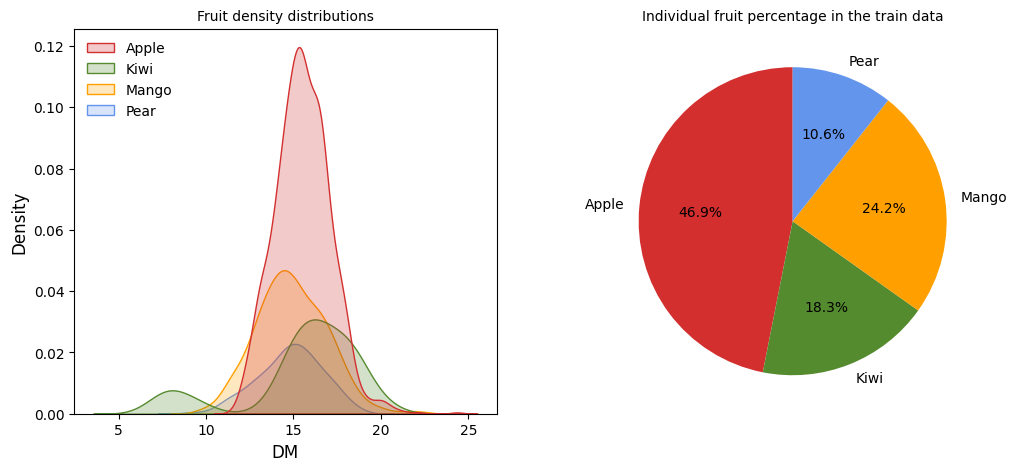

In [21]:
y_train_df = pd.DataFrame(data=np.concatenate([y_train, class_train], axis=1), columns=['DM','class'])

## plot the decompositions
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(12,5))
ax1.set_title('Fruit density distributions')
sns.kdeplot(data = y_train_df, x='DM', hue='class', palette=fruit_colors, fill=True,  common_norm=True, ax=ax1,label=None)
handles = ax1.legend_.legend_handles
for h, t in zip(handles, fruits[:-1]):
    h.set_label(t)  # assign the legend labels to the handles
ax1.legend(handles=handles, loc='upper left', frameon=False)
ax2.set_title('Individual fruit percentage in the train data')
plt.pie(np.unique(class_train, return_counts=True)[1], labels=fruits[:-1], autopct='%1.1f%%', shadow=False, startangle=90, colors=fruit_colors)
plt.show()

##### A simple linear regression model just to check the data

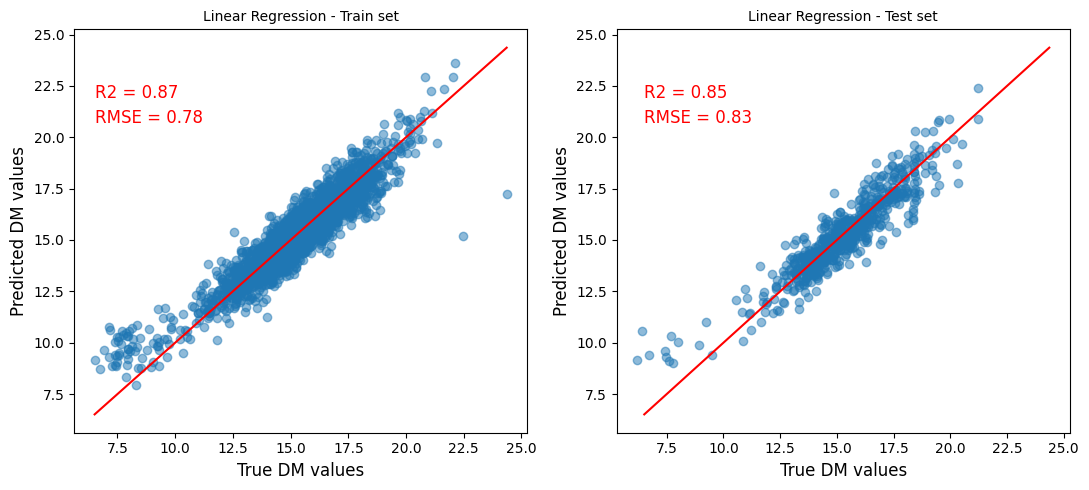

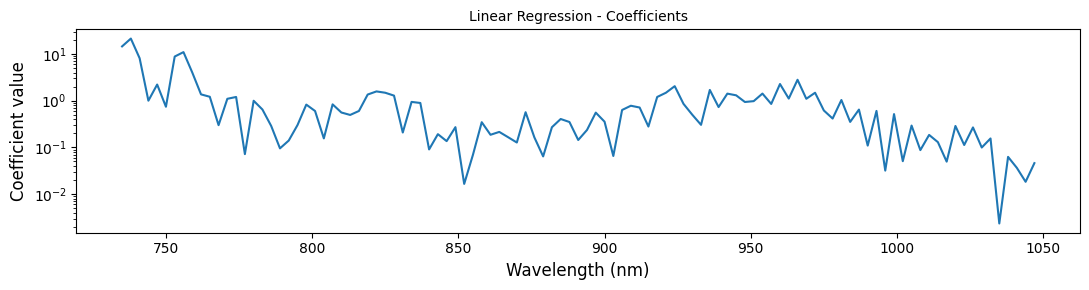

In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train_scaled_col, y_train)
y_train_pred0 = model.predict(x_train_scaled_col)
y_test_pred0 = model.predict(x_test_scaled_col)
## Compute the scores for the train set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred0))
r2_train = r2_score(y_train, y_train_pred0)
## Compute the scores for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred0))
r2_test = r2_score(y_test, y_test_pred0)

# plot the results
plt.figure(figsize=(11, 5))
plt.subplot(121)
plt.scatter(y_train, y_train_pred0, alpha=0.5)
plt.xlabel('True DM values')
plt.ylabel('Predicted DM values')
plt.title('Linear Regression - Train set')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')  # Line of perfect prediction
plt.text(min(y_train), max(y_train) * 0.9, f'R2 = {r2_train:.2f}', fontsize=12, color='red')
plt.text(min(y_train), max(y_train) * 0.85, f'RMSE = {rmse_train:.2f}', fontsize=12, color='red')
plt.subplot(122)
plt.scatter(y_test, y_test_pred0, alpha=0.5)
plt.xlabel('True DM values')
plt.ylabel('Predicted DM values')
plt.title('Linear Regression - Test set')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')  # Line of perfect prediction
plt.text(min(y_train), max(y_train) * 0.9, f'R2 = {r2_test:.2f}', fontsize=12, color='red')
plt.text(min(y_train), max(y_train) * 0.85, f'RMSE = {rmse_test:.2f}', fontsize=12, color='red')
plt.tight_layout()
plt.show()

coefficients = model.coef_
intercept = model.intercept_

# plot coefficients vs wavelength
plt.figure(figsize=(11, 3))
plt.plot(w[wi:wf], abs(coefficients.T))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Coefficient value')
plt.title('Linear Regression - Coefficients')
plt.yscale('log')
plt.tight_layout()
plt.show()


ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.869  		 0.850
RMSE: 		 0.782  		 0.827
Fit result: Y= 2.062752448761954  +  0.8646124238775426  * X
Figure saved


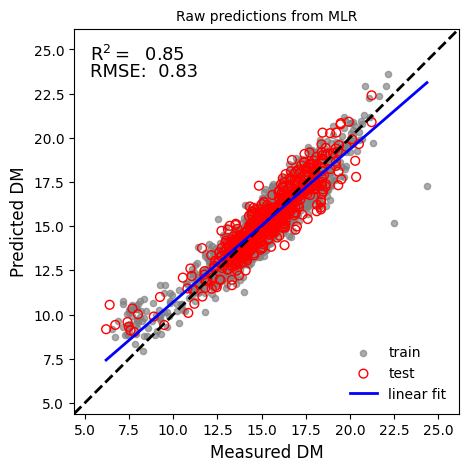

In [24]:
## Just check consistency of plotting function created for this purpose
plot_prediction2(y_train,  y_test, y_train_pred0,  y_test_pred0, title='Raw predictions from MLR',\
                 savefig=True, figname='prediction_linear.png')

## 4) Analysis of the different types of CNN architectures optimized

In this section we go through the analysis of the several architectures optimization files. The optimizations were performed using different notebooks (available in the folder "optimization_files"). For each CNN architecture we 1) define the model, 2) Import the corresponding HPO data-base (from Optuna), 3) instantiate the model with the best hyperparameters and make "cold predictions" by loading the pre-trained best model weights from the HPO procedure. Then we recompute metrics corresponding to the average of 10 models. This analysis pipeline is repeated for each CNN architecture. Behaware of possible typos in the text or model names due to copy-paste of cells...

### **4.1)** Regression models

#### **4.1.1)** Study v1 (optimized for cross-fruit validation) - single seed init.

Optimization of architecture v1 using a cross-fruit validation strategy (optimization done <font color='lightgreen'>@deepcybertron </font>): file <code>study_v1.db</code>.
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v1.ipynb</code> | 1445 |


NOTE: Each trial resulted in 4 saved models (one for each fruit as validation). The weights imported here, for the "single model predictions" correspond to the iteration that presents the lowest signs of overfit, i.e., the lowest difference between calibration RMSE and validation RMSE. In this cross-fruit validation strategy the runs where the cal set is  ['Pear' 'Apple' 'Kiwi'] and val set is Mango, are the one that, consistently across multiple HPO trials show the lowest validation RMSE. This does not seem related to the number of samples in the validation set, since the Pear set is the one with the lowest number of samples, not the Mango set.

From the optimization log we have:
```
Trial(Run) =  408 ( 2 ) -----------
Training on cal set:  ['Pear' 'Apple' 'Kiwi']  and validating on val set:  Mango
Calibration using ['Pear' 'Apple' 'Kiwi'] RMSE = 1.1661161190925189
Validation using Mango RMSE = 0.7117926097612707
```

**NOTE:** Due to an implementatin typo the trial version XXX(i) shown here is always +1 the correspoding file name. Here we identified trial 408(2) as the best one but the corresponding file is trial_408(1).db.

Create the model

In [25]:
## Make computations reproducible
reproducible_comp()

## Define the model
def create_model_1(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = 1
    K_WIDTH = filter_size
    K_STRIDE = 1
    OUTPUT_DIMS = 1
    
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='MODEL_CNN_V1')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='RESHAPE'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      strides=K_STRIDE, \
                                      padding='same', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='elu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))
    
    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))
    
    ## For the FC layer block, we implement a loop that adds dense layers with a certain number of units
    ## followed by a dropout layer (with a certain dropout rate)
    ## The number of layers, units, dropout rate, etc. will be optmized. Note that a dropout rate = 0 is
    ## the same as excluding that dropout layer... 
    for i in range(0, num_FC_layers):
        model_cnn.add(keras.layers.Dense(num_FC_units[i], \
                                         kernel_initializer=K_INIT, \
                                         kernel_regularizer=K_REG,\
                                         activation='elu', name='DENSE_'+str(i)))
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            model_cnn.add(keras.layers.Dropout(DROPOUT[i], name='DROPOUT_'+str(i)))  

    ## Final layer for multi-label classification
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='linear', name='OUTPUT'))
                             
    
    return model_cnn

Create a function to re-train the same model from scratch N times and compute metrics

In [27]:
def run_Nx_cnnR_v1_metrics(N, NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, BATCH_SIZE, LR,
                            EPOCHS, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for Nx CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model Nx (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the Nx models and the ensemble of the Nx models
    
    #### PARAMS:
    N: Number of times the model is trained on a different shuffle of the train data
    NUM_FC_LAYERS: Number of fully connected layers
    NUM_FC_UNITS: Number of units in each fully connected layer
    FILTER_SIZE: Size of the convolutional filter
    DROPOUT: Dropout rate for each fully connected layer
    REG_BETA: L2 regularization parameter
    BATCH_SIZE: Batch size for training
    LR: Learning rate
    EPOCHS: Number of epochs for training
    XTRAIN: Train X data
    YTRAIN: Train Y data
    XTEST: Test X data
    YTEST: Test Y data
    MODEL_NAME: Name of the model to save .h5 during training
    '''
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    

    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):

            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index] 

            ## Create a new model instance
            MODEL = create_model_1(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"]) 

            ## CONTROL
            # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, y_cal_shuf, batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, y_val_shuf),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## CONTROL
            # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')
    
    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ',N,' times')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []

    ## Train 10 models for this number of epochs, and compute mean error of predictions
    for i in np.arange(0,N,1):
    
        ## Create a new model instance (reset weights)
        MODEL = create_model_1(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state = int(i))
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)

        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## CONTROL
        # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, y_train_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
        ## CONTROL
        # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])
    
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)
        y_test_pred = MODEL.predict(XTEST)
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

                
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
                
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #    plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v1',\
        #                     savefig=False, figname='cnn_v1_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean variabilioty of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('------------------------------------------------------')
    return

Load the corresponding optimization study (database.db), get the best model and make "cold" predictions on the test set.

Result of optimization study after 2000 trials
Best trial: 408
Best trial value: 1.109058731830332
Best trial hyperparameters: {'DROPOUT_0': 0.54, 'batch_size': 224, 'filter_size': 3, 'num_FC_UNITS_0': 108, 'num_FC_UNITS_1': 44, 'num_FC_layers': 2, 'reg_beta': 0.0735}


C:\Users\dario\AppData\Local\Temp\ipykernel_2468\2145061255.py:9: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v1)


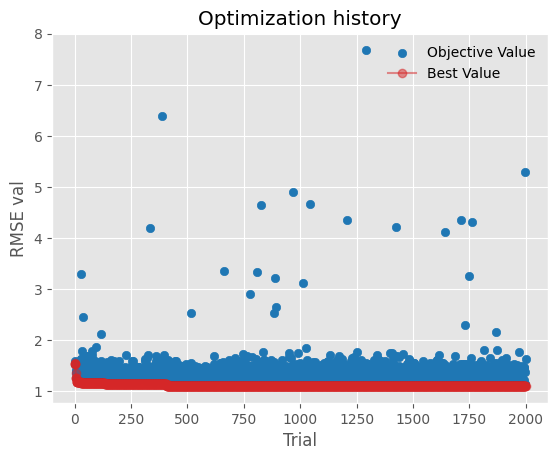


Creating model, loading weights and computing metrics...
19/19 [==============================] - 0s 1ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.794  		 0.785
RMSE: 		 0.980  		 0.990
Fit result: Y= 3.9582899003196093  +  0.7217745231602907  * X
Figure saved
Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.800
	 RMSE: 	 0.684

	 Kiwi
	 R2: 	 0.763
	 RMSE: 	 1.616

	 Mango
	 R2: 	 0.780
	 RMSE: 	 0.910

	 Pear
	 R2: 	 0.729
	 RMSE: 	 0.875
19/19 [==============================] - 0s 596us/step
Full Test: 0.990


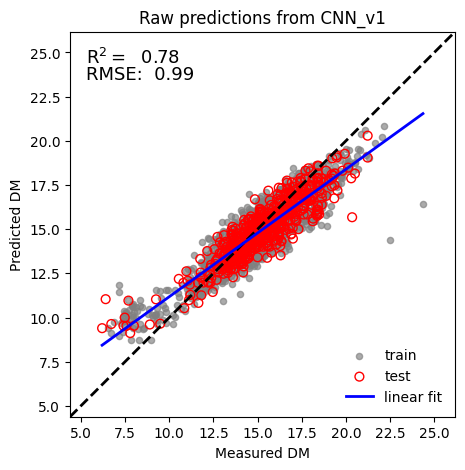

In [30]:
study_v1 = optuna.load_study(study_name="study_v1", storage="sqlite:///optimization_files/study_v1.db")

print('Result of optimization study after {} trials'.format(len(study_v1.trials)))
print('Best trial:',study_v1.best_trial.number)
print('Best trial value:',study_v1.best_trial.value)
print('Best trial hyperparameters:',study_v1.best_trial.params)


optuna.visualization.matplotlib.plot_optimization_history(study_v1)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
plt.show()
plt.style.use('default')


print('\nCreating model, loading weights and computing metrics...')
## Read the best trial parameters from previous prints and fill in to create the model
## PARMS: num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta
model_cnn_v1 = create_model_1(2, [108,44], 3, [0.54], 0.0735)

## Load the weights of the pre-trained / saved corresponding model
model_cnn_v1.load_weights("regression_models_v1/study_v1_trial=408(1).h5")

## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_1 = model_cnn_v1.predict(x_train_scaled_col)
y_test_pred_1  = model_cnn_v1.predict(x_test_scaled_col)


## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_1,  y_test_pred_1, title='Raw predictions from CNN_v1',\
                 savefig=True, figname='prediction_v1.png')

print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):

    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))

    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred = model_cnn_v1.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f' % (scoreR2_fruto))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

print('Full Test: {:3.3f}'.format(np.sqrt(mean_squared_error(y_test, model_cnn_v1.predict(x_test_scaled_col)))))

Lets check now how does the model behaves when it is trained 10 times under different training data partitions. This time the model will use the full shuffled train set for training (no cross-fruit validation). The model first runs a 5-fold cross validation (with the usual cal (80%) and val (20%) splits) and we record the epoch that "early stop" stops the training. The average number of epochs extracted from this procedure is then used to train the model 10 times using different shuffles of the train set. No test set information is used during training. The test set is only used for predictions at each of the 10 runs and the final prediction is presented as the average of the 10 runs.

In [ ]:
## Updated metrics with ensemble 29/08/2023
run_Nx_cnnR_v1_metrics(N=10, NUM_FC_LAYERS = 2, NUM_FC_UNITS = [108, 44], FILTER_SIZE = 3, DROPOUT = [0.54], REG_BETA = 0.0735, BATCH_SIZE = 224, LR = 0.03,
                       EPOCHS=489, XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                       MODEL_NAME = 'final_CNN_10x_v1_updated.h5')

The output of the previous cell was removed for file size reduction but the results from last run are here! This results might vary a bit each time run_Nx_cnnR_v1_metrics() is run but we expect that the variability observed is within the standard deviation of the metrics.

``` 
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.856  		 0.863 		 0.863
RMSE: 		 0.818+-0.003 		 0.791+-0.004 	 0.79052
------------------------------------------------------
```
Using cross-fruit validation, the HPO tends to lean towards much simpler models where the behaviour is practicaly linear. The models obtained with the cross-fruit validation doesn't seem to be the best option. Variability over 10x runs and 100x runs is practically the same...

Load the last model created in the previous cell and predict the individual fruits on the test set.

In [32]:
model_cnn_v1 = create_model_1(2, [108,44], 3, [0.54], 0.0735)

print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    ## Load the weights of the pre-trained / saved corresponding model
    ## load pre-computed model weights into model_cnn
    model_cnn_v1.load_weights("optimization_files/final_CNN_10x_v1_updated.h5")
    
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred  = model_cnn_v1.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores 
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f'  % (scoreR2_fruto ))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

print('Test:', np.sqrt(mean_squared_error(y_test, model_cnn_v1.predict(x_test_scaled_col))))

Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.818
	 RMSE: 	 0.653

	 Kiwi
	 R2: 	 0.906
	 RMSE: 	 1.021

	 Mango
	 R2: 	 0.837
	 RMSE: 	 0.783

	 Pear
	 R2: 	 0.749
	 RMSE: 	 0.842
19/19 [==============================] - 0s 584us/step
Test: 0.78381735


#### **4.1.2)** Study v1B (optimized for 5k cross-validation) - single seed init.
Optimization of architecture v1 using a 5-fold cross-validation strategy (optimization done <font color='lightgreen'>@Athena</font>). 
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v1B.ipynb *</code> | 764| 
|<code>Multifruit_optimization_v1B - Copy.ipynb</code> |877 |

 that ran in parallel on the two GPUs with shared access to file <code>study_v1B.db</code>.

NOTE: Each trial resulted in 5 saved models. The weights imported here, for the "single model predictions" correspond to the iteration that presents the lowest signs of overfitt, i.e., the lowest difference between calibration RMSE and validation RMSE. In this case:
```
Running iteration Trial(Run)  620 ( 3 ) --------
Calibration RMSE = 0.6291202157496357
Validation RMSE = 0.6377126741017515
```

Result of optimization study after 1000 trials
Best trial: 620
Best trial value: 0.665028178523863
Best trial hyperparameters: {'batch_size': 224, 'filter_size': 35, 'num_FC_UNITS_0': 92, 'num_FC_layers': 1, 'reg_beta': 0.029500000000000002}


C:\Users\dario\AppData\Local\Temp\ipykernel_2468\2215312414.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v1B)


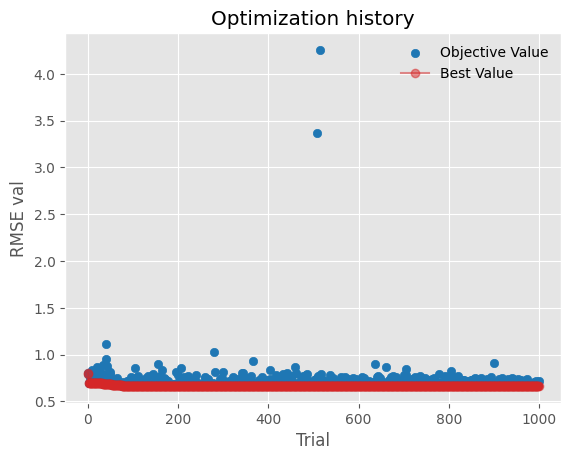


Creating model, loading weights and computing metrics...
19/19 [==============================] - 0s 630us/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.919  		 0.916
RMSE: 		 0.613  		 0.619
Fit result: Y= 1.3624167678407937  +  0.9122362350686422  * X


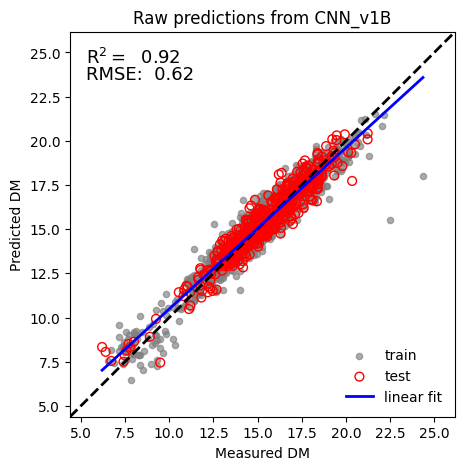

Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.855
	 RMSE: 	 0.584

	 Kiwi
	 R2: 	 0.948
	 RMSE: 	 0.755

	 Mango
	 R2: 	 0.904
	 RMSE: 	 0.602

	 Pear
	 R2: 	 0.895
	 RMSE: 	 0.545
19/19 [==============================] - 0s 584us/step
Full Test: 0.6192506
Best trial hyperparameters: {'batch_size': 224, 'filter_size': 35, 'num_FC_UNITS_0': 92, 'num_FC_layers': 1, 'reg_beta': 0.029500000000000002}


In [39]:
study_v1B = optuna.load_study(study_name="study_v1B", storage="sqlite:///optimization_files/study_v1B.db")

print('Result of optimization study after {} trials'.format(len(study_v1B.trials)))
print('Best trial:', study_v1B.best_trial.number)
print('Best trial value:',study_v1B.best_trial.value)
print('Best trial hyperparameters:',study_v1B.best_trial.params)

optuna.visualization.matplotlib.plot_optimization_history(study_v1B)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
plt.show()
# optuna.visualization.matplotlib.plot_param_importances(study_v1B)
# plt.show()
plt.style.use('default')

print('\nCreating model, loading weights and computing metrics...')
## PARMS: num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta
## Read the best trial parameters from previous prints and fill in to create the model
model_cnn_v1B = create_model_1(1, [92], 35, [], 0.0295)

## Load the weights of the pre-trained / saved corresponding model
model_cnn_v1B.load_weights("optimization_files/regression_models_v1B/study_v1B_trial=620(2).h5")

# ## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_v1B = model_cnn_v1B.predict(x_train_scaled_col)
y_test_pred_v1B = model_cnn_v1B.predict(x_test_scaled_col)


# ## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_v1B,  y_test_pred_v1B, title='Raw predictions from CNN_v1B', \
                 savefig=False, figname='prediction_v1B.png')


print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred  = model_cnn_v1B.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores 
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f'  % (scoreR2_fruto ))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

print('Full Test:', np.sqrt(mean_squared_error(y_test, model_cnn_v1B.predict(x_test_scaled_col))))
print('Best trial hyperparameters:',study_v1B.best_trial.params)

Get the results of 10 model runs under different shuffles of the train set. Same method applied previously.

```

In [ ]:
## Updated metrics with ensemble 28/08/2023
run_Nx_cnnR_v1_metrics(N=10, NUM_FC_LAYERS = 1, NUM_FC_UNITS = [92], FILTER_SIZE = 35, DROPOUT = [], REG_BETA = 0.0295, BATCH_SIZE = 224, LR = 0.03,
                       EPOCHS=464, XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                       MODEL_NAME = 'final_CNN_10x_v1B_updated.h5')

updated metrics on 28/08/2023 with ensemble prediction
```
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.915  		 0.913 		 0.921
RMSE: 		 0.629+-0.009 		 0.631+-0.013 	 0.60153
------------------------------------------------------
```

Performance of model CNN_v1B as a function of train data set size.

In [40]:
def compute_RMSE_vs_datasetsize_v1B(N, NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, BATCH_SIZE, LR,
                                EPOCHS, PLS_LV, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the RMSE as a function of train dataset size for a fixed number of epochs ###########
    PLS_LV: can be 'opt' (to automatically optimize the number of LVs) or an integer (to use a fixed number of LVs)
    '''
    
    ## Create lists to store metrics  
    MEAN_RMSE_train_list = []
    MEAN_R2_train_list = []
    MEAN_RMSE_test_list = []
    MEAN_R2_test_list = []
    STD_RMSE_train_list = []
    STD_RMSE_test_list = []
    pls_RMSE_train_list = []
    pls_RMSE_test_list = []
    pls_R2_train_list = []
    pls_R2_test_list = []
    ENSEMBLE_RMSE_test_list = []
    ENSEMBLE_R2_test_list = []
    sample_sizes = []

    ## Callbacks
    # progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    
    ########### Split the training data into 20 folds and train the model for a consecutive increase of folds ###########
    
    n_splits = 20
    train_set_size = len(x_train_scaled_shuf)//n_splits

    print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')
    
    ## Loop for training the model 5 times under different calibration/validation splits
    for i in range(n_splits):
                 
        ## Define the cal and val sets for this iteration
        x_subset = x_train_scaled_shuf[:(i+1)*train_set_size]
        y_subset = y_train_shuf[:(i+1)*train_set_size]

        N_samples = len(y_subset)
        sample_sizes.append(N_samples)
        print(f'\n Split {i}, training model on {N_samples} samples...')
        
        if PLS_LV == 'opt':
            ## Optimize PLS for this data split size
            best_LV, CV_RMSE = pls_optimization_cv_stop2(x_subset, y_subset, nmax=20, plot_opt=True)
            print('Chosen number of LVs:', best_LV, '\nCV RMSE:', CV_RMSE)
        else:
            best_LV = PLS_LV

        ## PLS regression
        pls = PLSRegression(n_components=best_LV, scale=True)
        pls.fit(x_subset, y_subset)
        ## Get predictions for train and test sets
        pls_train_pred = pls.predict(x_subset)
        pls_test_pred = pls.predict(XTEST)
        pls_rmse_train = np.sqrt(mean_squared_error(y_subset, pls_train_pred))
        pls_rmse_test = np.sqrt(mean_squared_error(YTEST, pls_test_pred))
        pls_RMSE_train_list.append(pls_rmse_train)
        pls_RMSE_test_list.append(pls_rmse_test)
        pls_R2_train = r2_score(y_subset, pls_train_pred)
        pls_R2_test = r2_score(YTEST, pls_test_pred)
        pls_R2_train_list.append(pls_R2_train)
        pls_R2_test_list.append(pls_R2_test)

        i_RMSE_train = []
        i_RMSE_test = []
        i_R2_train = []
        i_R2_test = []

        y_train_shuf_list = []
        y_test_pred_list = []

        print('\n-------- Computing CNN metrics --------\n')
        ## Train the model 10 times on each shuffled split
        for i in range(N):
            ## Create a new model instance (reset weights)
            MODEL = create_model_1(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  
            ## Save the best model based on the cal loss (the val loss is not used at any point during training)
            checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

            ## shuffle the training data to ensure different sequences of samples for each run
            x_subset_shuf, y_subset_shuf = shuffle(x_subset, y_subset, random_state=i)
            ## Store the shuffled train data for later use
            y_train_shuf_list.append(y_subset_shuf)

            ## train the model each time on a different shuffle of the training data
            MODEL.fit(x_subset_shuf, y_subset_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = EPOCHS, 
                       callbacks=[rdlr, checkpointer], verbose=0)
        
            print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
            ## Load the best model weights
            MODEL.load_weights(MODEL_NAME)

            ## Compute RMSE metrics for TRAIN and TEST sets
            y_train_pred = MODEL.predict(x_subset_shuf, verbose=0)
            y_test_pred = MODEL.predict(XTEST, verbose=0)
            ## Save the test predictions into a list
            y_test_pred_list.append(y_test_pred)

            ## Compute train error scores 
            scoreR2_train = r2_score(y_subset_shuf, y_train_pred)
            rmse_train = np.sqrt(mean_squared_error(y_subset_shuf, y_train_pred))
            i_RMSE_train.append(rmse_train)
            i_R2_train.append(scoreR2_train)

            ## Compute test error scores 
            scoreR2_test = r2_score(YTEST, y_test_pred)
            rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
            i_RMSE_test.append(rmse_test)
            i_R2_test.append(scoreR2_test)
               
            ## Clear clutter from previous session
            keras.backend.clear_session()          
            print('\n Keras backend cleared...')

        ## Compute mean and std of the metrics for this data split
        MEAN_RMSE_train_list.append(np.mean(i_RMSE_train))
        MEAN_RMSE_test_list.append(np.mean(i_RMSE_test))

        MEAN_R2_train_list.append(np.mean(i_R2_train))
        MEAN_R2_test_list.append(np.mean(i_R2_test))

        STD_RMSE_train_list.append(np.std(i_RMSE_train))
        STD_RMSE_test_list.append(np.std(i_RMSE_test))

        ## Compute y_test_pred mean and compute ensemble R2 and RMSE
        y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
        R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
        ENSEMBLE_R2_test_list.append(R2_test_ensemble)
        RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))
        ENSEMBLE_RMSE_test_list.append(RMSE_test_ensemble)

        ## Clear clutter from previous session
        keras.backend.clear_session()
    ### END FOR CYLE

    ## Plot performance as a function of training set size
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.errorbar(x=sample_sizes, y=MEAN_RMSE_train_list, yerr=STD_RMSE_train_list, fmt='o', label='CNN Train')
    plt.plot(sample_sizes, pls_RMSE_train_list, 'p-', label='PLS Train')
    plt.legend()
    plt.subplot(2,1,2)
    plt.errorbar(x=sample_sizes, y=MEAN_RMSE_test_list, yerr=STD_RMSE_test_list, fmt='o', label='CNN Test')
    plt.plot(sample_sizes, pls_RMSE_test_list, 'p-', label='PLS Test')
    plt.plot(sample_sizes, ENSEMBLE_RMSE_test_list, 's-', label='CNN Ensemble Test')
    plt.xlabel('Number of training samples')
    plt.ylabel('Test RMSE')
    # plt.title('RMSE vs. Number of folds')
    plt.legend()
    plt.show()

    return sample_sizes, MEAN_RMSE_train_list, STD_RMSE_train_list, MEAN_RMSE_test_list, STD_RMSE_test_list, \
            MEAN_R2_train_list, MEAN_R2_test_list, pls_RMSE_train_list, pls_RMSE_test_list,ENSEMBLE_R2_test_list, \
                ENSEMBLE_RMSE_test_list, pls_R2_train_list, pls_R2_test_list

In [ ]:
sample_sizes_B, MEAN_RMSE_train_list_B, STD_RMSE_train_list_B, MEAN_RMSE_test_list_B, STD_RMSE_test_list_B, \
    MEAN_R2_train_list_B, MEAN_R2_test_list_B, pls_RMSE_train_list_B, pls_RMSE_test_list_B,ENSEMBLE_R2_test_list_B, \
        ENSEMBLE_RMSE_test_list_B, pls_R2_train_list_B, pls_R2_test_list_B = compute_RMSE_vs_datasetsize_v1B(N=10, NUM_FC_LAYERS = 1, NUM_FC_UNITS = [92], FILTER_SIZE = 35, 
                                                                DROPOUT = [], REG_BETA = 0.0295, BATCH_SIZE = 224, LR = 0.03, 
                                                                EPOCHS = 439, PLS_LV = 'opt', XTRAIN = x_train_scaled_col, YTRAIN = y_train,  
                                                                XTEST = x_test_scaled_col, YTEST = y_test,
                                                                MODEL_NAME = 'temp_v1B.h5' )

Output cleared for file size reduction.

Next we arrange the results as dataframe to facilitate plotting and explore the results.

In [84]:
## Agregate everthing into a dataframe and save it to a csv file for later analysis.
v1B_sample_metrics = pd.DataFrame(data = np.transpose([sample_sizes_B, MEAN_RMSE_train_list_B, STD_RMSE_train_list_B, MEAN_RMSE_test_list_B, STD_RMSE_test_list_B, 
                                                       MEAN_R2_train_list_B, MEAN_R2_test_list_B, pls_RMSE_train_list_B, pls_RMSE_test_list_B,ENSEMBLE_R2_test_list_B, 
                                                       ENSEMBLE_RMSE_test_list_B, pls_R2_train_list_B, pls_R2_test_list_B]), \
                                  columns = ["sample_sizes_B", "MEAN_RMSE_train_list_B", "STD_RMSE_train_list_B", "MEAN_RMSE_test_list_B", 
                                                                  "STD_RMSE_test_list_B", "MEAN_R2_train_list_B", "MEAN_R2_test_list_B", "pls_RMSE_train_list_B", 
                                                                  "pls_RMSE_test_list_B", "R2_test_ensemble_list_B", "RMSE_test_ensemble_list_B", 
                                                                  "pls_R2_train_list_B", "pls_R2_test_list_B"])

## Save the results to a csv file for later analysis
# v1B_sample_metrics.to_csv('v1B_10x_sample_metrics.csv', index=False)

v1B_sample_metrics

sample_sizes_B  MEAN_RMSE_train_list_B  STD_RMSE_train_list_B  \
0            119.0                0.245862               0.031880   
1            238.0                0.474843               0.053115   
2            357.0                0.400389               0.020028   
3            476.0                0.525073               0.036265   
4            595.0                0.483700               0.017664   
5            714.0                0.541467               0.020916   
6            833.0                0.543916               0.021919   
7            952.0                0.597262               0.019041   
8           1071.0                0.593125               0.016092   
9           1190.0                0.610156               0.014490   
10          1309.0                0.612229               0.013099   
11          1428.0                0.616877               0.015264   
12          1547.0                0.620260               0.011991   
13          1666.0                0.628450               0.009204   
14          1785.0                0.622373               0.010810   
15          1904.0                0.626281               0.019493   
16          2023.0                0.631187               0.017169   
17          2142.0                0.619751               0.011101   
18          2261.0                0.626897               0.010533   
19          2380.0                0.630589               0.015503   

    MEAN_RMSE_test_list_B  STD_RMSE_test_list_B  MEAN_R2_train_list_B  \
0                1.425347              0.009409              0.991522   
1                0.958642              0.045572              0.963013   
2                0.920629              0.023928              0.973333   
3                0.791923              0.021832              0.951736   
4                0.772725              0.019561              0.957867   
5                0.712735              0.019843              0.945581   
6                0.706600              0.013913              0.942630   
7                0.681578              0.016676              0.931250   
8                0.668099              0.014254              0.930123   
9                0.666569              0.016577              0.925748   
10               0.666547              0.010533              0.924102   
11               0.659825              0.024278              0.921917   
12               0.652802              0.013038              0.920002   
13               0.649843              0.017257              0.916046   
14               0.640471              0.010250              0.918116   
15               0.634735              0.012789              0.916137   
16               0.641016              0.017737              0.914469   
17               0.620617              0.009235              0.916726   
18               0.630594              0.012642              0.914791   
19               0.631071              0.016920              0.914605   

    MEAN_R2_test_list_B  pls_RMSE_train_list_B  pls_RMSE_test_list_B  \
0              0.554086               1.061222              1.029574   
1              0.797845               1.019774              0.953693   
2              0.813854               1.003941              0.954932   
3              0.862251               1.006056              0.931014   
4              0.868865               0.984070              0.918845   
5              0.888420               0.957816              0.912839   
6              0.890376               0.912661              0.898711   
7              0.897981               0.936718              0.894457   
8              0.901990               0.927833              0.898164   
9              0.902423               0.923073              0.898175   
10             0.902465               0.916356              0.897962   
11             0.904317               0.915089              0.897811   
12             0.906432               0.918263              0.898894   
13          

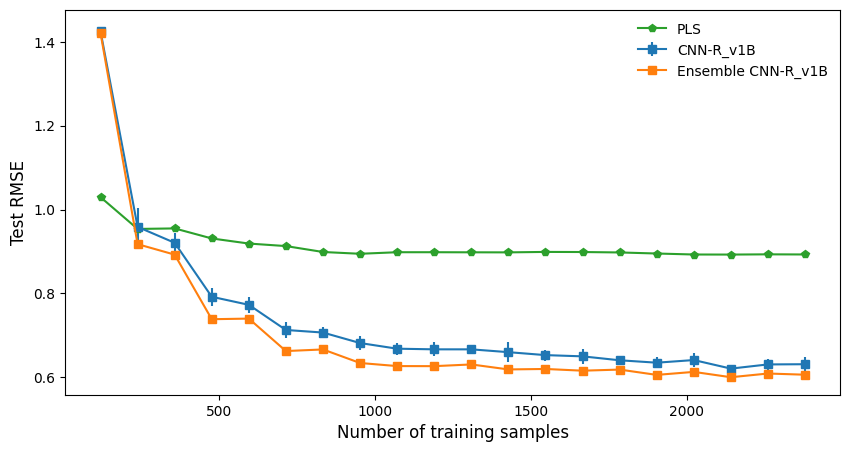

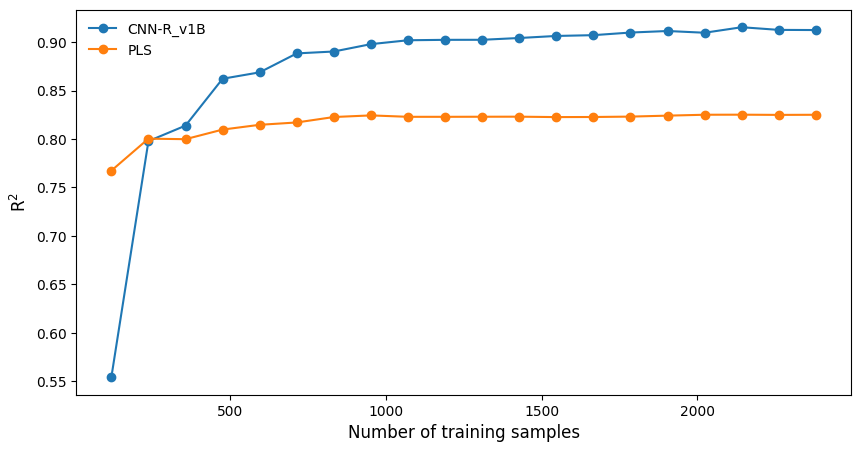

In [69]:
## Plot CNN performance as a function of training set size

plt.figure(figsize=(10,5))
# plt.plot(sample_sizes, RMSE_train_list, 'o-', label='CNN Train')
# plt.plot(sample_sizes, MEAN_RMSE_test_list, c='navy', label=None)
plt.errorbar(x = v1B_sample_metrics["sample_sizes_B"], y = v1B_sample_metrics["MEAN_RMSE_test_list_B"], 
             yerr = v1B_sample_metrics["STD_RMSE_test_list_B"], fmt='s-', label='CNN-R_v1B')
plt.errorbar(x = v1B_sample_metrics["sample_sizes_B"], y = v1B_sample_metrics["ENSEMBLE_RMSE_test_list_B"], 
              fmt='s-', label='Ensemble CNN-R_v1B')
# plt.plot(sample_sizes, pls_RMSE_train_list, 'p-', label='PLS Train')
plt.plot(v1B_sample_metrics["sample_sizes_B"], v1B_sample_metrics["pls_RMSE_test_list_B"], 'p-', label='PLS')
# plt.axhline(y=0.89, color='r', linestyle='--')
plt.xlabel('Number of training samples', fontsize=12)
plt.ylabel('Test RMSE', fontsize=12)
# plt.title('RMSE vs. Number of folds')
plt.legend(frameon=False)
plt.show()

## Plot R2 performance as a function of training set size
plt.figure(figsize=(10,5))
plt.errorbar(x = v1B_sample_metrics["sample_sizes_B"], y = v1B_sample_metrics["MEAN_R2_test_list_B"], fmt='o-', label='CNN-R_v1B')
plt.errorbar(x = v1B_sample_metrics["sample_sizes_B"], y = v1B_sample_metrics["pls_R2_test_list_B"], fmt='o-', label='PLS')
plt.xlabel('Number of training samples', fontsize=12)
plt.ylabel(r'R$^2$', fontsize=12)
plt.legend(frameon=False)
plt.show()

#### **4.1.3)** Study v1D (optimized for 5k cross-validation + single seed init + multiple filters)

Optimization of architecture v1D using a 5-fold cross validation strategy (optimization done <font color='lightgreen'>@deepcybertron </font>): file <code>study_v1D.db</code>.
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v1D.ipynb</code> | ? |


```
Running iteration Trial(Run)  414 ( 3 ) --------
Training: 98 
489/500 ETA: 00:00s, 15.58epochs/s
Calibration RMSE = 0.6040502605984251
Validation RMSE = 0.6071982017905104
```

In [41]:
## Define the model
def create_model_v1D(num_conv_filters, filter_size, num_FC_units, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = num_conv_filters
    K_WIDTH = filter_size
    K_STRIDE = 1
    OUTPUT_DIMS = 1
    
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='MODEL_CNN_V1D')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='INPUT'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      strides=K_STRIDE, \
                                      padding='same', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='elu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))
    
    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))
    
    ## For the FC layer block, we implement a single dense layers with a certain number of units
    model_cnn.add(keras.layers.Dense(num_FC_units, \
                                     kernel_initializer=K_INIT, \
                                     kernel_regularizer=K_REG,\
                                     activation='elu', name='DENSE'))
  

    ## Final layer for regression
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='linear', name='OUTPUT'))
                             
    
    return model_cnn

In [42]:
#num_conv_filters, filter_size, num_FC_units, reg_beta
def run_Nx_cnnR_v1D_metrics(N, NUM_CONV_FILTERS, FILTER_SIZE, NUM_FC_UNITS, REG_BETA, BATCH_SIZE, LR,
                            EPOCHS, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for 10x CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    
    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):

            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index] 

            ## Create a new model instance
            MODEL = create_model_v1D(NUM_CONV_FILTERS, FILTER_SIZE, NUM_FC_UNITS, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"]) 

            ## CONTROL
            # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, y_cal_shuf, batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, y_val_shuf),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## CONTROL
            # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')

    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ',N,' times')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []

    ## Train 10 models for this number of epochs, and compute mean error of predictions
    for i in np.arange(0,N,1):
    
        ## Create a new model instance (reset weights)
        MODEL = create_model_v1D(NUM_CONV_FILTERS, FILTER_SIZE, NUM_FC_UNITS, REG_BETA)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state = int(i))
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)
        
        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## CONTROL
        # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, y_train_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
        ## CONTROL
        # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])
    
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)
        y_test_pred = MODEL.predict(XTEST)
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

                
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
                
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #    plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v1',\
        #                     savefig=False, figname='cnn_v1_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('------------------------------------------------------')
    return

Result of optimization study after 1001 trials
Best trial: 414
Best trial value: 0.6487212189627023
Best trial hyperparameters: {'batch_size': 160, 'filter_size': 51, 'num_FC_UNITS': 16, 'num_conv_filters': 10, 'reg_beta': 0.029500000000000002}


C:\Users\dario\AppData\Local\Temp\ipykernel_2468\3174764592.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v1D)


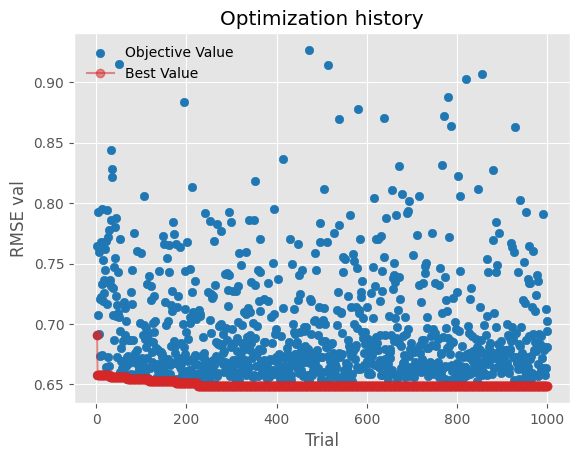


Creating model, loading weights and computing metrics...
19/19 [==============================] - 0s 639us/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.919  		 0.918
RMSE: 		 0.612  		 0.611
Fit result: Y= 1.4377980396452603  +  0.9074235548106717  * X
Figure saved
Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.863
	 RMSE: 	 0.567

	 Kiwi
	 R2: 	 0.945
	 RMSE: 	 0.777

	 Mango
	 R2: 	 0.913
	 RMSE: 	 0.572

	 Pear
	 R2: 	 0.889
	 RMSE: 	 0.560
19/19 [==============================] - 0s 695us/step
Full Test: 0.6110547
Best trial hyperparameters: {'batch_size': 160, 'filter_size': 51, 'num_FC_UNITS': 16, 'num_conv_filters': 10, 'reg_beta': 0.029500000000000002}


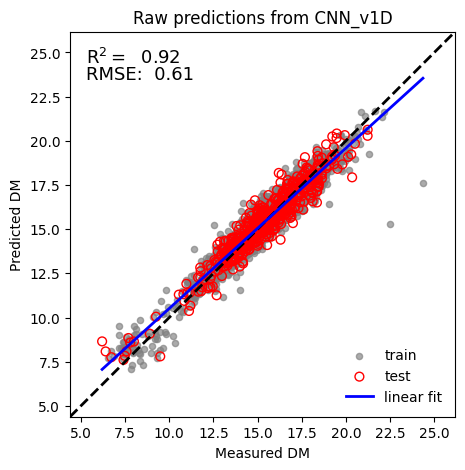

In [48]:
study_v1D = optuna.load_study(study_name="study_v1D", storage="sqlite:///optimization_files/study_v1D.db")

print('Result of optimization study after {} trials'.format(len(study_v1D.trials)))
print('Best trial:', study_v1D.best_trial.number)
print('Best trial value:',study_v1D.best_trial.value)
print('Best trial hyperparameters:',study_v1D.best_trial.params)

optuna.visualization.matplotlib.plot_optimization_history(study_v1D)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
plt.show()
# optuna.visualization.matplotlib.plot_param_importances(study_v1D)
# plt.show()
plt.style.use('default')

print('\nCreating model, loading weights and computing metrics...')
## PARMS: num_conv_filters, filter_size, num_FC_units, reg_beta
## Read the best trial parameters from previous prints and fill in to create the model
model_cnn_v1D = create_model_v1D(10, 51, 16, 0.0295)

## Load the weights of the pre-trained / saved corresponding model
model_cnn_v1D.load_weights("optimization_files/regression_models_v1D/study_v1D_trial=414(2).h5")

# ## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_v1D = model_cnn_v1D.predict(x_train_scaled_col)
y_test_pred_v1D = model_cnn_v1D.predict(x_test_scaled_col)


# ## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_v1D,  y_test_pred_v1D, title='Raw predictions from CNN_v1D', \
                 savefig=True, figname='prediction_v1D.png')


print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred  = model_cnn_v1D.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores 
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f'  % (scoreR2_fruto ))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

print('Full Test:', np.sqrt(mean_squared_error(y_test, model_cnn_v1D.predict(x_test_scaled_col))))
print('Best trial hyperparameters:',study_v1D.best_trial.params)

In [ ]:
## updated on 28/08/2023 with ensemble predections
run_Nx_cnnR_v1D_metrics(N=10, NUM_CONV_FILTERS=10, FILTER_SIZE=51, NUM_FC_UNITS=16, REG_BETA=0.0295, BATCH_SIZE = 160, LR = 0.03,
                        EPOCHS=425, XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                        MODEL_NAME = 'final_CNN_10x_v1D_update.h5' )

updated metrics on 28/08/2023 with ensemble prediction
```
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.916  		 0.915 		 0.922
RMSE: 		 0.624+-0.035 		 0.622+-0.027 	 0.59565
------------------------------------------------------
```

#### **4.1.4)** Study v1C (optimized for 5k cross-validation) + **multi** seed init.
Optimization of architecture v1 using a 5-fold cross-validation strategy and multiple init seeds (optimization done <font color='lightgreen'>@Athena</font>). 
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v1C.ipynb *</code> | 831| 
|<code>Multifruit_optimization_v1C - Copy.ipynb</code> | 912 |

 that ran in parallel on the two GPUs with shared access to file <code>study_v1C.db</code>.

NOTE: Each trial resulted in 5 saved models. The weights imported here, for the "single model predictions" correspond to the iteration that presents the lowest signs of overfitt, i.e., the lowest difference between calibration RMSE and validation RMSE. In this case:
```
Running iteration Trial(Run)  824 ( 4 ), SEED =  1062383  --------
Calibration RMSE = 0.6019032244140102
Validation RMSE = 0.6272836924839695
```

In [49]:
## Make computations reproducible
reproducible_comp()

## Define the model
def create_model_1C(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta, SEED):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = 1
    K_WIDTH = filter_size
    K_STRIDE = 1
    OUTPUT_DIMS = 1
    
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=SEED)
    
    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='MODEL_CNN_V1C')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='INPUT'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      strides=K_STRIDE, \
                                      padding='same', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='elu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))
    
    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))
    
    ## For the FC layer block, we implement a loop that adds dense layers with a certain number of units
    ## followed by a dropout layer (with a certain dropout rate)
    ## The number of layers, units, dropout rate, etc. will be optmized. Note that a dropout rate = 0 is
    ## the same as excluding that dropout layer... 
    for i in range(0, num_FC_layers):
        model_cnn.add(keras.layers.Dense(num_FC_units[i], \
                                         kernel_initializer=K_INIT, \
                                         kernel_regularizer=K_REG,\
                                         activation='elu', name='DENSE_'+str(i)))
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            model_cnn.add(keras.layers.Dropout(DROPOUT[i], name='DROPOUT_'+str(i)))  

    ## Final layer for multi-label classification
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='linear', name='OUTPUT'))
                             
    
    return model_cnn

In [50]:
def run_Nx_cnnR_v1C_metrics(N, NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, BATCH_SIZE, LR,
                            EPOCHS, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for Nx CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    

    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):
            SEED = np.random.randint(1, 2000)
            print('Initializing model with seed: ', SEED) 
            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index] 

            ## Create a new model instance
            MODEL = create_model_1C(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, SEED)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"]) 

            ## CONTROL
            # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, y_cal_shuf, batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, y_val_shuf),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## CONTROL
            # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')

    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ,',N,' times.')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []
    
    ## Train N models for this number of epochs, and compute mean error of predictions
    
    for i in np.arange(0,N,1):
        SEED = np.random.randint(1, 2000)
        print('Initializing model with seed: ', SEED)         
        
        ## Create a new model instance (reset weights)
        MODEL = create_model_1C(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, SEED)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state = int(i))
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)
        
        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## CONTROL
        # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, y_train_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
        ## CONTROL
        # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])
    
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)
        y_test_pred = MODEL.predict(XTEST)
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

                
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
                
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #     plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v1C',\
        #                      savefig=False, figname='cnn_v1C_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('------------------------------------------------------')
    return

Result of optimization study after 1081 trials
Best trial: 824
Best trial value: 0.6579475442405319
Best trial hyperparameters: {'batch_size': 192, 'filter_size': 41, 'num_FC_UNITS_0': 116, 'num_FC_layers': 1, 'reg_beta': 0.026000000000000002}


C:\Users\dario\AppData\Local\Temp\ipykernel_2468\1621066508.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v1C)


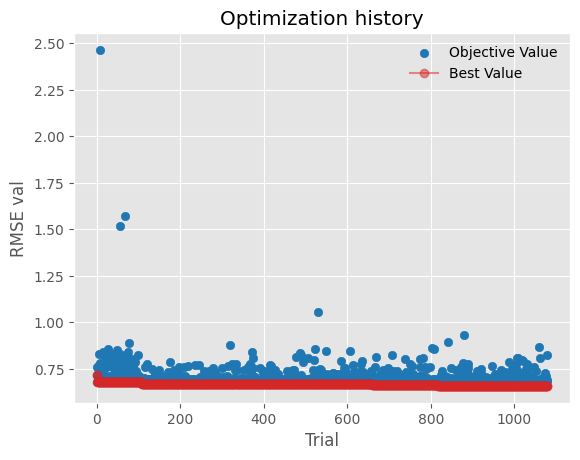


Creating model, loading weights and computing metrics...
19/19 [==============================] - 0s 973us/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.921  		 0.914
RMSE: 		 0.607  		 0.625
Fit result: Y= 1.406451560208081  +  0.90772576933543  * X


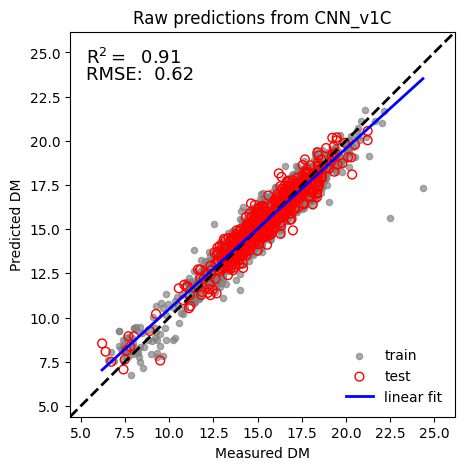

Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.862
	 RMSE: 	 0.569

	 Kiwi
	 R2: 	 0.942
	 RMSE: 	 0.800

	 Mango
	 R2: 	 0.905
	 RMSE: 	 0.596

	 Pear
	 R2: 	 0.882
	 RMSE: 	 0.577
19/19 [==============================] - 0s 584us/step
Full Test: 0.6248644
Best trial hyperparameters: {'batch_size': 192, 'filter_size': 41, 'num_FC_UNITS_0': 116, 'num_FC_layers': 1, 'reg_beta': 0.026000000000000002}


In [51]:
study_v1C = optuna.load_study(study_name="study_v1C", storage="sqlite:///optimization_files/study_v1C.db")

print('Result of optimization study after {} trials'.format(len(study_v1C.trials)))
print('Best trial:', study_v1C.best_trial.number)
print('Best trial value:',study_v1C.best_trial.value)
print('Best trial hyperparameters:',study_v1C.best_trial.params)

optuna.visualization.matplotlib.plot_optimization_history(study_v1C)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
# plt.show()
# optuna.visualization.matplotlib.plot_param_importances(study_v1C)
plt.show()
plt.style.use('default')

print('\nCreating model, loading weights and computing metrics...')
## PARMS: num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta
## Read the best trial parameters from previous prints and fill in to create the model
model_cnn_v1C = create_model_1C(1, [116], 41, [], 0.026, 1062383)

## Load the weights of the pre-trained / saved corresponding model
model_cnn_v1C.load_weights("optimization_files/regression_models_v1C/study_v1C_trial=824(3).h5")

# ## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_v1C = model_cnn_v1C.predict(x_train_scaled_col)
y_test_pred_v1C = model_cnn_v1C.predict(x_test_scaled_col)


# ## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_v1C,  y_test_pred_v1C, title='Raw predictions from CNN_v1C', \
                 savefig=False, figname='prediction_v1C.png')


print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred  = model_cnn_v1C.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores 
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f'  % (scoreR2_fruto ))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

print('Full Test:', np.sqrt(mean_squared_error(y_test, model_cnn_v1C.predict(x_test_scaled_col))))
print('Best trial hyperparameters:',study_v1C.best_trial.params)

In [ ]:
## updated on 28/08/2023 with ensemble predections
run_Nx_cnnR_v1C_metrics(N=10, NUM_FC_LAYERS = 1, NUM_FC_UNITS = [116], FILTER_SIZE = 41, DROPOUT = [], REG_BETA = 0.026, BATCH_SIZE = 192, LR = 0.03,
                        EPOCHS=440, XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                        MODEL_NAME = 'final_10x_CNN_v1C_update.h5' )

updated metrics on 28/08/2023 with ensemble prediction
```
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.913  		 0.909 		 0.920
RMSE: 		 0.635+-0.023 		 0.643+-0.023 	 0.60390
------------------------------------------------------
```

What happens if we train the configuration obtained in CNN_v1B with a random initialization strategy? Since _v1B and _v1C only differ in terms of SEED input, we can simply use the HP obtained in _v1B, instantiate a model with create_model_1C() and train the model 10 times with different SEEDs using the function run_10x_cnnR_v1C_metrics().

In [ ]:
## Retrain the optimized model on the full training data and compute final metrics 10 times
run_Nx_cnnR_v1C_metrics(N=10, NUM_FC_LAYERS = 1, NUM_FC_UNITS = [92], FILTER_SIZE = 35, DROPOUT = [], REG_BETA = 0.0295, BATCH_SIZE = 224, LR = 0.03,
                         XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                         MODEL_NAME = 'final_CNN_10x_v1B2_rand_init_seed.h5')

run_Nx_cnnR_v1C_metrics(N=100, NUM_FC_LAYERS = 1, NUM_FC_UNITS = [92], FILTER_SIZE = 35, DROPOUT = [], REG_BETA = 0.0295, BATCH_SIZE = 224, LR = 0.03,
                         XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                         MODEL_NAME = 'final_CNN_10x_v1B2_rand_init_seed.h5')

```
10x metrics
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST
------------------------------------------------------
R2: 		 0.914  		 0.911
RMSE: 		 0.632+-0.013 		 0.637+-0.013
------------------------------------------------------

100x metrics
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST
------------------------------------------------------
R2: 		 0.914  		 0.912
RMSE: 		 0.631+-0.018 		 0.634+-0.017
------------------------------------------------------
```

The obtained result is very close to the result obtained using a single seed. This means that the random seed initialization strategy is not critical for this model. This might be due to the fact that the variability induced by the 5-fold cross-validation is much higher than the variability induced by the random seed initialization.


#### **4.1.5)** Study v1E (optimized for 5k cross validation + single seed init + multiple filters with full width)

Optimization of architecture v1E using a 5 fold cross validation strategy (optimization done <font color='lightgreen'>@deepcybertron </font>): file <code>study_v1E.db</code>.
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v1E.ipynb</code> | ? |


```
Running iteration Trial(Run)  812 ( 3 ) --------
Training: 90% 450/500 ETA: 00:14s, 3.35epochs/s
Calibration RMSE = 0.559981216899035
Validation RMSE = 0.6060198828894449
```

In [52]:
## Make computations reproducible
reproducible_comp()

## Define the model
def create_model_v1E(num_conv_filters, num_FC_units, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = num_conv_filters
    K_WIDTH = INPUT_DIMS # same witth as the input spectra
    K_STRIDE = 1
    OUTPUT_DIMS = 1
    
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='MODEL_CNN_V1E')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='INPUT'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      padding='valid', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='elu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))
    
    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))
    
    ## For the FC layer block, we implement a single dense layer with a certain number of units
    model_cnn.add(keras.layers.Dense(num_FC_units, \
                                     kernel_initializer=K_INIT, \
                                     kernel_regularizer=K_REG,\
                                     activation='elu', name='DENSE'))
  

    ## Final layer for regression
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='linear', name='OUTPUT'))
                             
    
    return model_cnn



## The same model as before but allowing random initialization of the weights
def create_model_v1E_RS(num_conv_filters, num_FC_units, reg_beta, SEED):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = num_conv_filters
    K_WIDTH = INPUT_DIMS # same witth as the input spectra
    K_STRIDE = 1
    OUTPUT_DIMS = 1
    
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=SEED)
    
    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='MODEL_CNN_V1E')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='INPUT'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      padding='valid', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='elu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))
    
    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))
    
    ## For the FC layer block, we implement a loop that adds dense layers with a certain number of units
    model_cnn.add(keras.layers.Dense(num_FC_units, \
                                     kernel_initializer=K_INIT, \
                                     kernel_regularizer=K_REG,\
                                     activation='elu', name='DENSE'))
  

    ## Final layer for multi-label classification
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='linear', name='OUTPUT'))
                             
    
    return model_cnn

In [53]:
def run_Nx_cnnR_v1E_metrics(N, NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA, BATCH_SIZE, LR,
                            EPOCHS, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for Nx CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    

    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):
            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index] 

            ## Create a new model instance
            MODEL = create_model_v1E(NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"]) 

            ## CONTROL
            # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, y_cal_shuf, batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, y_val_shuf),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## CONTROL
            # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')

    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ,',N,' times.')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []

    ## Train N models for this number of epochs, and compute mean error of predictions
    
    for i in np.arange(0,N,1):
        ## Create a new model instance (reset weights)
        MODEL = create_model_v1E(NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state = int(i))
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)

        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## CONTROL
        # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, y_train_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
        ## CONTROL
        # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])
    
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)
        y_test_pred = MODEL.predict(XTEST)
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

                
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
                
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #     plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v1C',\
        #                      savefig=False, figname='cnn_v1C_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('------------------------------------------------------')
    return




## The same function as before but with random seed initialization
def run_Nx_cnnR_v1E_metrics_RS(N, NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA, BATCH_SIZE, LR,
                               EPOCHS, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for Nx CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    
    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):
            SEED = np.random.randint(1, 2000)
            print('Initializing model with seed: ', SEED) 
            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index] 

            ## Create a new model instance
            MODEL = create_model_v1E_RS(NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA, SEED)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"]) 

            ## CONTROL
            # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, y_cal_shuf, batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, y_val_shuf),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## CONTROL
            # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')

    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ,',N,' times.')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)


    y_train_shuf_list = []
    y_test_pred_list = []

    ## Train 10 models for this number of epochs, and compute mean error of predictions
    
    for i in np.arange(0,N,1):
        SEED = np.random.randint(1, 2000)
        print('Initializing model with seed: ', SEED) 
        ## Create a new model instance (reset weights)
        MODEL = create_model_v1E_RS(NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA, SEED)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state = int(i))
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)
        
        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## CONTROL
        # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, y_train_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
        ## CONTROL
        # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])
    
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)
        y_test_pred = MODEL.predict(XTEST)
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

                
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
                
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #     plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v1C',\
        #                      savefig=False, figname='cnn_v1C_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('------------------------------------------------------')
    return

Result of optimization study after 1181 trials
Best trial: 812
Best trial value: 0.6424981618466423
Best trial hyperparameters: {'batch_size': 512, 'num_FC_UNITS': 80, 'num_conv_filters': 12, 'reg_beta': 0.007000000000000001}


C:\Users\dario\AppData\Local\Temp\ipykernel_2468\1019272602.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v1E)


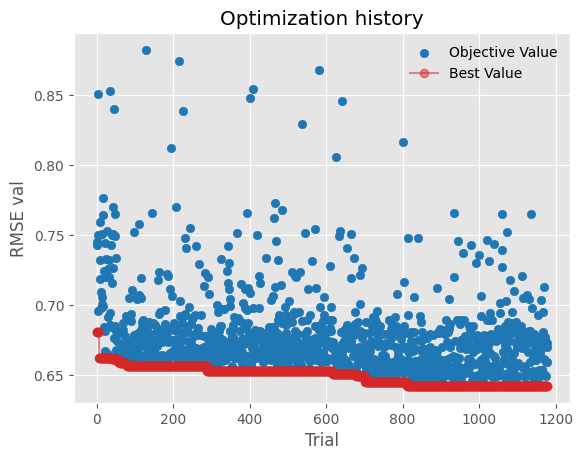


Creating model, loading weights and computing metrics...
19/19 [==============================] - 0s 982us/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.931  		 0.920
RMSE: 		 0.565  		 0.605
Fit result: Y= 1.2528731845650354  +  0.9175421410539534  * X


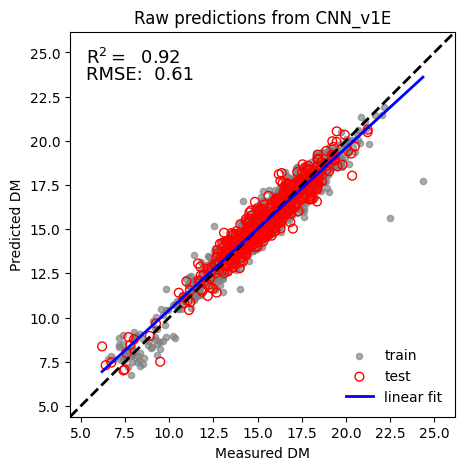

Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.857
	 RMSE: 	 0.580

	 Kiwi
	 R2: 	 0.951
	 RMSE: 	 0.736

	 Mango
	 R2: 	 0.917
	 RMSE: 	 0.557

	 Pear
	 R2: 	 0.887
	 RMSE: 	 0.565
19/19 [==============================] - 0s 570us/step
Full Test: 0.6052392
Best trial hyperparameters: {'batch_size': 512, 'num_FC_UNITS': 80, 'num_conv_filters': 12, 'reg_beta': 0.007000000000000001}


In [54]:
study_v1E = optuna.load_study(study_name="study_v1E", storage="sqlite:///optimization_files/study_v1E.db")

print('Result of optimization study after {} trials'.format(len(study_v1E.trials)))
print('Best trial:', study_v1E.best_trial.number)
print('Best trial value:',study_v1E.best_trial.value)
print('Best trial hyperparameters:',study_v1E.best_trial.params)

optuna.visualization.matplotlib.plot_optimization_history(study_v1E)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
plt.show()
# optuna.visualization.matplotlib.plot_param_importances(study_v1E)
# plt.show()
plt.style.use('default')

print('\nCreating model, loading weights and computing metrics...')
## PARMS: num_CONV_filters, num_FC_units, reg_beta
## Read the best trial parameters from previous prints and fill in to create the model
model_cnn_v1E = create_model_v1E(12, 80, 0.007)

## Load the weights of the pre-trained / saved corresponding model
model_cnn_v1E.load_weights("optimization_files/regression_models_v1E/study_v1E_trial=812(2).h5")

## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_v1E = model_cnn_v1E.predict(x_train_scaled_col)
y_test_pred_v1E = model_cnn_v1E.predict(x_test_scaled_col)


## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_v1E,  y_test_pred_v1E, title='Raw predictions from CNN_v1E', \
                 savefig=False, figname='prediction_v1E.png')


print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred  = model_cnn_v1E.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores 
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f'  % (scoreR2_fruto ))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

print('Full Test:', np.sqrt(mean_squared_error(y_test, model_cnn_v1E.predict(x_test_scaled_col))))
print('Best trial hyperparameters:',study_v1E.best_trial.params)

In [ ]:
## updated on 28/08/2023 with emsenble metrics
run_Nx_cnnR_v1E_metrics(N=10, NUM_CONV_FILTERS = 12, NUM_FC_UNITS = 80, REG_BETA = 0.007, BATCH_SIZE = 512, LR = 0.03,
                        EPOCHS=449, XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                        MODEL_NAME = 'final_CNN_10x_v1E_update.h5')

updated metrics on 28/08/2023 with ensemble prediction
```
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.935  		 0.917 		 0.922
RMSE: 		 0.549+-0.009 		 0.614+-0.011 	 0.59505
------------------------------------------------------
```

Compute the RMSE as a function of the number of training samples.

In [141]:
def compute_RMSE_vs_datasetsize_v1E(N,NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA, BATCH_SIZE, LR,
                                    EPOCHS, PLS_LV, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the RMSE as a function of train dataset size for a fixed number of epochs ###########
    '''
    
    ## Create lists to store metrics  
    MEAN_RMSE_train_list = []
    MEAN_R2_train_list = []
    MEAN_RMSE_test_list = []
    MEAN_R2_test_list = []
    STD_RMSE_train_list = []
    STD_RMSE_test_list = []
    pls_RMSE_train_list = []
    pls_RMSE_test_list = []
    pls_R2_train_list = []
    pls_R2_test_list = []
    ENSEMBLE_RMSE_test_list = []
    ENSEMBLE_R2_test_list = []
    sample_sizes = []

    ## Callbacks
    # progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    
    ########### Split the training data into 20 folds and train the model for a consecutive increase of folds ###########
    
    n_splits = 20
    train_set_size = len(x_train_scaled_shuf)//n_splits

    print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')
    
    ## Loop for training the model 5 times under different calibration/validation splits
    for i in range(n_splits):
                 
        ## Define the cal and val sets for this iteration
        x_subset = x_train_scaled_shuf[:(i+1)*train_set_size]
        y_subset = y_train_shuf[:(i+1)*train_set_size]

        N_samples = len(y_subset)
        sample_sizes.append(N_samples)
        print(f'\n Split {i}, training model on {N_samples} samples...')

        if PLS_LV == 'opt':
            ## Optimize PLS for this data split size
            best_LV, CV_RMSE = pls_optimization_cv_stop2(x_subset, y_subset, nmax=20, plot_opt=True)
            print('Chosen number of LVs:', best_LV, '\nCV RMSE:', CV_RMSE)
        else:
            best_LV = PLS_LV
            
        ## PLS regression
        pls = PLSRegression(n_components=best_LV, scale=True)
        pls.fit(x_subset, y_subset)
        ## Get predictions for train and test sets
        pls_train_pred = pls.predict(x_subset)
        pls_test_pred = pls.predict(XTEST)
        pls_rmse_train = np.sqrt(mean_squared_error(y_subset, pls_train_pred))
        pls_rmse_test = np.sqrt(mean_squared_error(YTEST, pls_test_pred))
        pls_RMSE_train_list.append(pls_rmse_train)
        pls_RMSE_test_list.append(pls_rmse_test)
        pls_R2_train = r2_score(y_subset, pls_train_pred)
        pls_R2_test = r2_score(YTEST, pls_test_pred)
        pls_R2_train_list.append(pls_R2_train)
        pls_R2_test_list.append(pls_R2_test)

        i_RMSE_train = []
        i_RMSE_test = []
        i_R2_train = []
        i_R2_test = []
        i_RMSE_train = []
        i_RMSE_test = []

        y_train_shuf_list = []
        y_test_pred_list = []

        ## Train the model 10 times on each shuffled split
        for i in range(N):
            ## Create a new model instance (reset weights)
            MODEL = create_model_v1E(NUM_CONV_FILTERS, NUM_FC_UNITS, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  
            ## Save the best model based on the cal loss (the val loss is not used at any point during training)
            checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

            ## shuffle the training data to ensure different sequences of samples for each run
            x_subset_shuf, y_subset_shuf = shuffle(x_subset, y_subset, random_state=i)
            ## Store the shuffled train data for later use
            y_train_shuf_list.append(y_subset_shuf)

            ## train the model each time on a different shuffle of the training data
            MODEL.fit(x_subset_shuf, y_subset_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = EPOCHS, 
                       callbacks=[rdlr, checkpointer], verbose=0)
        
            print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
            ## Load the best model weights
            MODEL.load_weights(MODEL_NAME)

            ## Compute RMSE metrics for TRAIN and TEST sets
            y_train_pred = MODEL.predict(x_subset_shuf, verbose=0)
            y_test_pred = MODEL.predict(XTEST, verbose=0)
            ## Save the test predictions into a list
            y_test_pred_list.append(y_test_pred)

            ## Compute train error scores 
            scoreR2_train = r2_score(y_subset_shuf, y_train_pred)
            rmse_train = np.sqrt(mean_squared_error(y_subset_shuf, y_train_pred))
            i_RMSE_train.append(rmse_train)
            i_R2_train.append(scoreR2_train)

            ## Compute test error scores 
            scoreR2_test = r2_score(YTEST, y_test_pred)
            rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
            i_RMSE_test.append(rmse_test)
            i_R2_test.append(scoreR2_test)
               
            ## Clear clutter from previous session
            keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Compute mean and std of the metrics for this data split
        MEAN_RMSE_train_list.append(np.mean(i_RMSE_train))
        MEAN_RMSE_test_list.append(np.mean(i_RMSE_test))

        MEAN_R2_train_list.append(np.mean(i_R2_train))
        MEAN_R2_test_list.append(np.mean(i_R2_test))

        STD_RMSE_train_list.append(np.std(i_RMSE_train))
        STD_RMSE_test_list.append(np.std(i_RMSE_test))

        ## Compute y_test_pred mean and compute ensemble R2 and RMSE
        y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
        R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
        ENSEMBLE_R2_test_list.append(R2_test_ensemble)
        RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))
        ENSEMBLE_RMSE_test_list.append(RMSE_test_ensemble)

        ## Clear clutter from previous session
        keras.backend.clear_session()
    ### END FOR CYLE

    ## Plot performance as a function of training set size
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.errorbar(x=sample_sizes, y=MEAN_RMSE_train_list, yerr=STD_RMSE_train_list, fmt='o', label='CNN Train')
    plt.plot(sample_sizes, pls_RMSE_train_list, 'p-', label='PLS Train')
    plt.legend()
    plt.subplot(2,1,2)
    plt.errorbar(x=sample_sizes, y=MEAN_RMSE_test_list, yerr=STD_RMSE_test_list, fmt='o', label='CNN Test')
    plt.plot(sample_sizes, pls_RMSE_test_list, 'p-', label='PLS Test')
    plt.plot(sample_sizes, ENSEMBLE_RMSE_test_list, 's-', label='CNN Ensemble Test')
    plt.xlabel('Number of training samples')
    plt.ylabel('Test RMSE')
    # plt.title('RMSE vs. Number of folds')
    plt.legend()
    plt.show()

    return sample_sizes, MEAN_RMSE_train_list, STD_RMSE_train_list, MEAN_RMSE_test_list, STD_RMSE_test_list, \
            MEAN_R2_train_list, MEAN_R2_test_list, pls_RMSE_train_list, pls_RMSE_test_list,ENSEMBLE_R2_test_list, \
                ENSEMBLE_RMSE_test_list, pls_R2_train_list, pls_R2_test_list

In [ ]:
sample_sizes, MEAN_RMSE_train_list, STD_RMSE_train_list, MEAN_RMSE_test_list, \
    STD_RMSE_test_list, MEAN_R2_train_list, MEAN_R2_test_list, pls_RMSE_train_list, pls_RMSE_test_list, R2_test_ensemble_list, \
            RMSE_test_ensemble_list, pls_R2_train_list, pls_R2_test_list = compute_RMSE_vs_datasetsize_v1E(N=10, NUM_CONV_FILTERS = 12, NUM_FC_UNITS = 80, 
                                                                            REG_BETA = 0.007, BATCH_SIZE = 512, LR = 0.03, 
                                                                            EPOCHS = 449, PLS_LV = 'opt', 
                                                                            XTRAIN = x_train_scaled_col, YTRAIN = y_train,  
                                                                            XTEST = x_test_scaled_col, YTEST = y_test,
                                                                            MODEL_NAME = 'temp_v1E.h5' )

In [143]:
v1E_sample_metrics = pd.DataFrame(data = np.transpose([sample_sizes, MEAN_RMSE_train_list, STD_RMSE_train_list, MEAN_RMSE_test_list, 
                                                       STD_RMSE_test_list, MEAN_R2_train_list, MEAN_R2_test_list, pls_RMSE_train_list, 
                                                       pls_RMSE_test_list, R2_test_ensemble_list, RMSE_test_ensemble_list, pls_R2_train_list, 
                                                       pls_R2_test_list]), 
                                                       columns = ["sample_sizes_E", "MEAN_RMSE_train_list_E", "STD_RMSE_train_list_E", "MEAN_RMSE_test_list_E", 
                                                                  "STD_RMSE_test_list_E", "MEAN_R2_train_list_E", "MEAN_R2_test_list_E", "pls_RMSE_train_list_E", 
                                                                  "pls_RMSE_test_list_E", "R2_test_ensemble_list_E", "RMSE_test_ensemble_list_E", 
                                                                  "pls_R2_train_list_E", "pls_R2_test_list_E"])

v1E_sample_metrics.to_csv('v1E_10x_sample_metrics.csv', index=False)

v1E_sample_metrics

sample_sizes_E  MEAN_RMSE_train_list_E  STD_RMSE_train_list_E  \
0            119.0                0.111131               0.000829   
1            238.0                0.222302               0.005076   
2            357.0                0.301482               0.013164   
3            476.0                0.398479               0.011487   
4            595.0                0.435345               0.021039   
5            714.0                0.417015               0.018602   
6            833.0                0.427043               0.014458   
7            952.0                0.476063               0.011022   
8           1071.0                0.535023               0.017479   
9           1190.0                0.507055               0.013914   
10          1309.0                0.515498               0.011405   
11          1428.0                0.519019               0.012359   
12          1547.0                0.571831               0.006061   
13          1666.0                0.544572               0.009423   
14          1785.0                0.550696               0.006466   
15          1904.0                0.537253               0.006969   
16          2023.0                0.542302               0.008715   
17          2142.0                0.556508               0.007539   
18          2261.0                0.547141               0.004275   
19          2380.0                0.550227               0.012613   

    MEAN_RMSE_test_list_E  STD_RMSE_test_list_E  MEAN_R2_train_list_E  \
0                1.604229              0.002512              0.998296   
1                1.135751              0.016196              0.991989   
2                0.957823              0.009963              0.984890   
3                0.920843              0.009957              0.972312   
4                0.793437              0.019897              0.965836   
5                0.771986              0.012690              0.967706   
6                0.752737              0.021467              0.964653   
7                0.722807              0.014031              0.956342   
8                0.699801              0.014321              0.943124   
9                0.707682              0.015426              0.948712   
10               0.695331              0.015715              0.946189   
11               0.674573              0.010983              0.944728   
12               0.642672              0.007937              0.932025   
13               0.649848              0.010408              0.936955   
14               0.647623              0.009455              0.935901   
15               0.634207              0.005972              0.938334   
16               0.633652              0.006869              0.936892   
17               0.624102              0.008264              0.932864   
18               0.621855              0.008041              0.935107   
19               0.614713              0.006125              0.934989   

    MEAN_R2_test_list_E  pls_RMSE_train_list_E  pls_RMSE_test_list_E  \
0              0.435161               1.061222              1.029574   
1              0.716831               1.019774              0.953693   
2              0.798624               1.003941              0.954932   
3              0.813871               1.006056              0.931014   
4              0.861742               0.984070              0.918845   
5              0.869164               0.957816              0.912839   
6              0.875540               0.912661              0.898711   
7              0.885290               0.936718              0.894457   
8              0.892472               0.927833              0.898164   
9              0.890030               0.923073              0.898175   
10             0.893831               0.916356              0.897962   
11             0.900100               0.915089              0.897811   
12             0.909336               0.918263              0.898894   
13          

In [145]:
## Load the metrics from the other models (B and E)
v1B_sample_metrics = pd.read_csv('v1B_10x_sample_metrics.csv')
v1E_sample_metrics = pd.read_csv('v1E_10x_sample_metrics.csv')


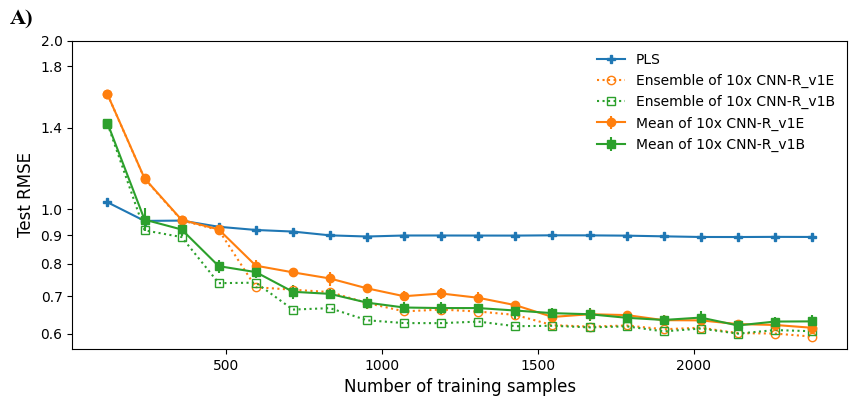

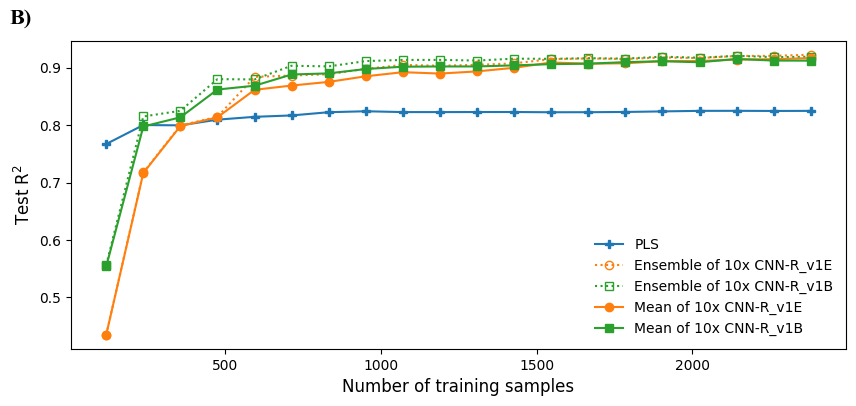

In [146]:
## Plot performance as a function of training set size
plt.figure(figsize=(10,4))

# plt.title('RMSE vs training set size')
# plt.plot(sample_sizes, RMSE_train_list, 'o-', label='CNN Train')
# plt.plot(sample_sizes, MEAN_RMSE_test_list, c='navy', label=None)
plt.plot(v1E_sample_metrics["sample_sizes_E"], v1E_sample_metrics["pls_RMSE_test_list_E"], 'P-',  label='PLS')
plt.errorbar(x = v1E_sample_metrics["sample_sizes_E"], y = v1E_sample_metrics["MEAN_RMSE_test_list_E"], yerr = v1E_sample_metrics["STD_RMSE_test_list_E"], 
             fmt='o-', label='Mean of 10x CNN-R_v1E')
plt.errorbar(x = v1B_sample_metrics["sample_sizes_B"], y = v1B_sample_metrics["MEAN_RMSE_test_list_B"], yerr = v1B_sample_metrics["STD_RMSE_test_list_B"], 
             fmt='s-', label='Mean of 10x CNN-R_v1B')
plt.plot(v1E_sample_metrics["sample_sizes_E"], v1E_sample_metrics["RMSE_test_ensemble_list_E"], 'o:', color='tab:orange', markerfacecolor='none',label='Ensemble of 10x CNN-R_v1E')
plt.plot(v1B_sample_metrics["sample_sizes_B"], v1B_sample_metrics["RMSE_test_ensemble_list_B"], 's:', color='tab:green', markerfacecolor='none', label='Ensemble of 10x CNN-R_v1B')
# plt.axhline(y=0.89, color='r', linestyle='--')
plt.xlabel('Number of training samples', fontsize=12)
plt.ylabel('Test RMSE', fontsize=12)
# plt.title('RMSE vs. Number of folds')
plt.yscale('log')
custom_ticks = [0.6, 0.7, 0.8, 0.9, 1,  1.4, 1.8, 2.0]
ax = plt.gca() 
ax.set_yticks(custom_ticks)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
plt.legend(frameon=False)
## Insert the figure number 'A)' in the top left corner, outside the frame, in times new roman font
plt.text(-0.05, 1.1, 'A)', transform=ax.transAxes,
        fontsize=16, fontname='Times New Roman', fontweight='bold', va='top', ha='right')
plt.savefig('RMSE_vs_trainsetsize_v1B_v1E_A.png', dpi=150, bbox_inches='tight')
# plt.show()

## Plot R2 performance as a function of training set size
plt.figure(figsize=(10,4))
plt.plot(v1E_sample_metrics["sample_sizes_E"], v1E_sample_metrics["pls_R2_test_list_E"], 'P-', label='PLS')
plt.errorbar(x = v1E_sample_metrics["sample_sizes_E"], y = v1E_sample_metrics["MEAN_R2_test_list_E"], fmt='o-', label='Mean of 10x CNN-R_v1E')
plt.errorbar(x = v1B_sample_metrics["sample_sizes_B"], y = v1B_sample_metrics["MEAN_R2_test_list_B"], fmt='s-', label='Mean of 10x CNN-R_v1B')
plt.plot(v1E_sample_metrics["sample_sizes_E"], v1E_sample_metrics["R2_test_ensemble_list_E"], 'o:', color='tab:orange', markerfacecolor='none',label='Ensemble of 10x CNN-R_v1E')
plt.plot(v1B_sample_metrics["sample_sizes_B"], v1B_sample_metrics["R2_test_ensemble_list_B"], 's:', color='tab:green', markerfacecolor='none', label='Ensemble of 10x CNN-R_v1B')

plt.xlabel('Number of training samples', fontsize=12)
plt.ylabel(r'Test R$^2$', fontsize=12)
plt.legend(frameon=False)
ax = plt.gca()
plt.text(-0.05, 1.1, 'B)', transform=ax.transAxes,
        fontsize=16, fontname='Times New Roman', fontweight='bold', va='top', ha='right')
plt.savefig('RMSE_vs_trainsetsize_v1B_v1E_B.png', dpi=150, bbox_inches='tight')
# plt.show()

Compute an ensemble of 40 models as suggest by Dirks & Poole 2002 (even if the data set is different). This is done just to check the difference in performance when compared with the 10 models ensemble.

In [ ]:
sample_sizes, MEAN_RMSE_train_list, STD_RMSE_train_list, MEAN_RMSE_test_list, \
    STD_RMSE_test_list, MEAN_R2_train_list, MEAN_R2_test_list, pls_RMSE_train_list, pls_RMSE_test_list, R2_test_ensemble_list, \
            RMSE_test_ensemble_list, pls_R2_train_list, pls_R2_test_list = compute_RMSE_vs_datasetsize_v1E(N=12, NUM_CONV_FILTERS = 12, NUM_FC_UNITS = 80, 
                                                                            REG_BETA = 0.007, BATCH_SIZE = 512, LR = 0.03, 
                                                                            EPOCHS = 449, PLS_LV = 'opt', 
                                                                            XTRAIN = x_train_scaled_col, YTRAIN = y_train,  
                                                                            XTEST = x_test_scaled_col, YTEST = y_test,
                                                                            MODEL_NAME = 'temp_v1E.h5' )

v1E_40x_sample_metrics = pd.DataFrame(data = np.transpose([sample_sizes, MEAN_RMSE_train_list, STD_RMSE_train_list, MEAN_RMSE_test_list, 
                                                       STD_RMSE_test_list, MEAN_R2_train_list, MEAN_R2_test_list, pls_RMSE_train_list, 
                                                       pls_RMSE_test_list, R2_test_ensemble_list, RMSE_test_ensemble_list, pls_R2_train_list, 
                                                       pls_R2_test_list]), 
                                                       columns = ["sample_sizes_E", "MEAN_RMSE_train_list_E", "STD_RMSE_train_list_E", "MEAN_RMSE_test_list_E", 
                                                                  "STD_RMSE_test_list_E", "MEAN_R2_train_list_E", "MEAN_R2_test_list_E", "pls_RMSE_train_list_E", 
                                                                  "pls_RMSE_test_list_E", "R2_test_ensemble_list_E", "RMSE_test_ensemble_list_E", 
                                                                  "pls_R2_train_list_E", "pls_R2_test_list_E"])

v1E_40x_sample_metrics.head()

v1E_40x_sample_metrics.to_csv('v1E_40x_sample_metrics.csv', index=False)

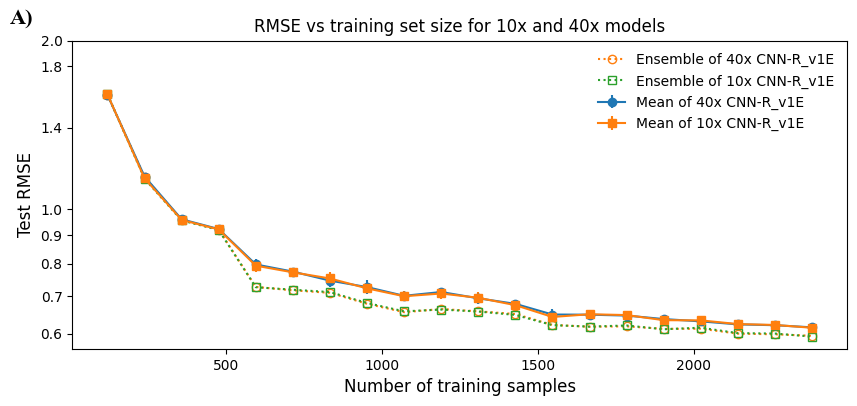

In [150]:
## Plot performance as a function of training set size
plt.figure(figsize=(10,4))

plt.title('RMSE vs training set size for 10x and 40x models')
# plt.plot(v1E_40x_sample_metrics["sample_sizes_E"], v1E_40x_sample_metrics["pls_RMSE_test_list_E"], 'P-',  label='PLS')
plt.errorbar(x = v1E_40x_sample_metrics["sample_sizes_E"], y = v1E_40x_sample_metrics["MEAN_RMSE_test_list_E"], yerr =v1E_40x_sample_metrics["STD_RMSE_test_list_E"], 
             fmt='o-', label='Mean of 40x CNN-R_v1E')
plt.errorbar(x = v1E_sample_metrics["sample_sizes_E"], y = v1E_sample_metrics["MEAN_RMSE_test_list_E"], yerr = v1E_sample_metrics["STD_RMSE_test_list_E"], 
             fmt='s-', label='Mean of 10x CNN-R_v1E')
plt.plot(v1E_40x_sample_metrics["sample_sizes_E"], v1E_40x_sample_metrics["RMSE_test_ensemble_list_E"], 'o:', color='tab:orange', markerfacecolor='none',label='Ensemble of 40x CNN-R_v1E')
plt.plot(v1E_sample_metrics["sample_sizes_E"], v1E_sample_metrics["RMSE_test_ensemble_list_E"], 's:', color='tab:green', markerfacecolor='none', label='Ensemble of 10x CNN-R_v1E')
# plt.axhline(y=0.89, color='r', linestyle='--')
plt.xlabel('Number of training samples', fontsize=12)
plt.ylabel('Test RMSE', fontsize=12)
# plt.title('RMSE vs. Number of folds')
plt.yscale('log')
custom_ticks = [0.6, 0.7, 0.8, 0.9, 1,  1.4, 1.8, 2.0]
ax = plt.gca() 
ax.set_yticks(custom_ticks)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
plt.legend(frameon=False)
## Insert the figure number 'A)' in the top left corner, outside the frame, in times new roman font
plt.text(-0.05, 1.1, 'A)', transform=ax.transAxes,
        fontsize=16, fontname='Times New Roman', fontweight='bold', va='top', ha='right')
plt.savefig('RMSE_vs_trainsetsize_v1E10x_v1E40x.png', dpi=150, bbox_inches='tight')
# plt.show()

Ensemble metrics as a function of the number of models in the ensemble. There doesn't seem to be an improvement by using 40 models in the ensemble. The 10 models ensemble seems to be enough as pointed out by preliminary tests...

Individual fruit predictions using the global CNN model (based on single model pre-computed HO weights)

Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.857
	 RMSE: 	 0.580
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.931  		 0.857
RMSE: 		 0.565  		 0.580
Fit result: Y= 1.6703033852669398  +  0.890854367789045  * X


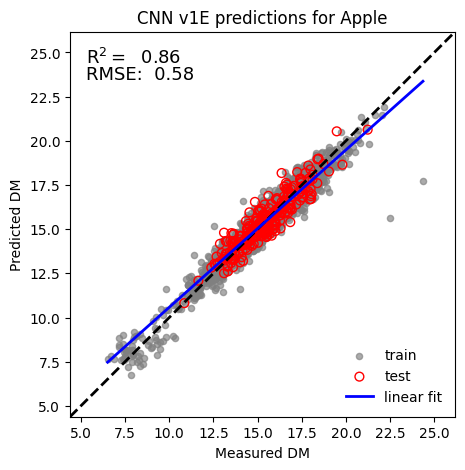


	 Kiwi
	 R2: 	 0.951
	 RMSE: 	 0.736
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.931  		 0.951
RMSE: 		 0.565  		 0.736
Fit result: Y= 1.3489929931094067  +  0.9155405875784904  * X


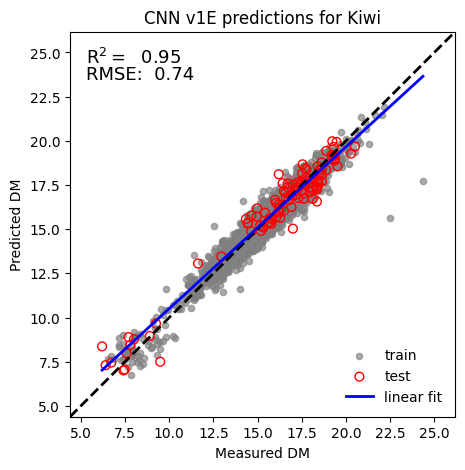


	 Mango
	 R2: 	 0.917
	 RMSE: 	 0.557
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.931  		 0.917
RMSE: 		 0.565  		 0.557
Fit result: Y= 0.9540111790902018  +  0.9331317516929082  * X


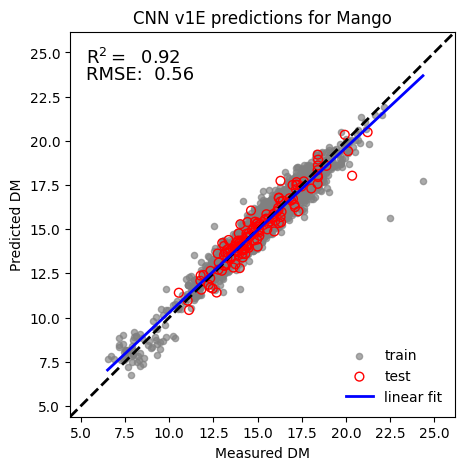


	 Pear
	 R2: 	 0.887
	 RMSE: 	 0.565
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.931  		 0.887
RMSE: 		 0.565  		 0.565
Fit result: Y= 1.087900742658004  +  0.9295658116237716  * X


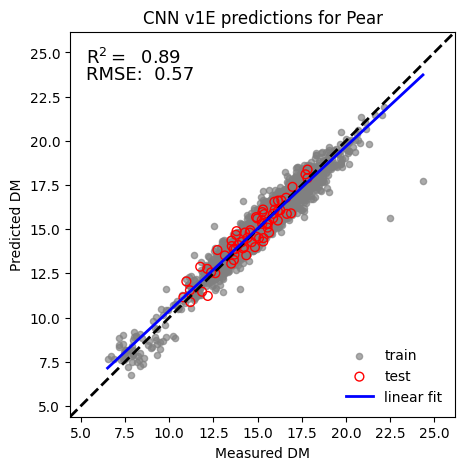

19/19 [==============================] - 0s 695us/step
Test: 0.6052392


In [55]:
model_cnn_v1E = create_model_v1E(12, 80, 0.007)
## load pre-computed model weights into model_cnn
# model_cnn_v1E.load_weights("final_CNN_10x_v1E.h5")
model_cnn_v1E.load_weights("optimization_files/regression_models_v1E/study_v1E_trial=812(2).h5")

print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    ## Standardize the single fruit data  
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred  = model_cnn_v1E.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores 
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f'  % (scoreR2_fruto ))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

    plot_prediction2(y_train,  y_fruto, y_train_pred_v1E,  y_fruto_pred, title='CNN v1E predictions for '+name_fruto, \
                    savefig=False, figname='prediction_1E.png')

print('Test:', np.sqrt(mean_squared_error(y_test, model_cnn_v1E.predict(x_test_scaled_col))))

Trying training individual CNN models on each fruit individual data but using a BATCH_SIZE that is dependent on the number os samples per fruit subset and an increased L2 regularization. The batch size = 512 from the HPO is not indicated here because the number of individual fruit samples is lower. We use a batch size for each fruit in the same proportion that the 512 is to the whole data set, i.e. ~1/4.7. This is just a test and is not optimized!

In [ ]:
## Instantiate the model
model_cnn_v1E = create_model_v1E(12, 80, 0.021)
# BATCH_SIZE = 512  ## it is lowered from 512 to 256 because of the smaller training set sizes
# EPOCHS = 'auto# 449 ## based on the number of epochs obtained in the 10 models metrics test
LR = 0.03

rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

## For each fruit, train the model and compute metrics for single fruit TRAIN and single fruit TEST sets
for x_fruto_train, y_fruto_train, x_fruto_test, y_fruto_test, name_fruto in zip(x_train_list[:-1], y_train_list[:-1],
                                                                                x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    ## standardize the spectra of each fruit in the test set
    x_fruto_train_scaled, x_fruto_test_scaled = standardize_column(np.array(x_fruto_train), np.array(x_fruto_test))

    print(f'*************** {name_fruto} ***************')
    BATCH_fruit = int(len(x_fruto_train)/4.7) ## the ratio between the total number of samples and 512
    run_Nx_cnnR_v1E_metrics(N=10, NUM_CONV_FILTERS = 12, NUM_FC_UNITS = 80, REG_BETA = 0.007, BATCH_SIZE = BATCH_fruit, LR = 0.03,
                        EPOCHS='auto', XTRAIN = x_fruto_train_scaled, YTRAIN = y_fruto_train,  XTEST = x_fruto_test_scaled, YTEST = y_fruto_test, 
                        MODEL_NAME = 'single_CNN_10x_v1E2.h5')


Summary of results:

```
APPLE:
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.946  		 0.823 		 0.843
RMSE: 		 0.368+-0.010 		 0.645+-0.015 	 0.60750
------------------------------------------------------

KIWI:
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.990  		 0.937 		 0.945
RMSE: 		 0.326+-0.029 		 0.832+-0.029 	 0.78197
------------------------------------------------------

MANGO:
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.958  		 0.856 		 0.874
RMSE: 		 0.414+-0.016 		 0.735+-0.029 	 0.68940
------------------------------------------------------

PEAR:
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.986  		 0.802 		 0.826
RMSE: 		 0.215+-0.029 		 0.748+-0.035 	 0.70191
------------------------------------------------------
```
As expected the CNNs tend to overfit and perform worse in these individual models than when the full multifruit is used for training. Nonetheless this comparison is not fair because the CNN_v1E was not optimized using individual fruits...

Robustness to randon seed initialization

In [ ]:
## updated in 20-09-2023 during the paper revision
## Retrain the optimized model on the full training data and compute final metrics 10 times
run_Nx_cnnR_v1E_metrics_RS(N=10, NUM_CONV_FILTERS = 12, NUM_FC_UNITS = 80, REG_BETA = 0.007, BATCH_SIZE = 512, LR = 0.03, EPOCHS='auto',
                         XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                         MODEL_NAME = 'final_CNN_10x_v1E_RS2.h5')

``` 
10x metrics using random seed initialization each time.
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.936  		 0.916 		 0.922
RMSE: 		 0.547+-0.007 		 0.617+-0.005 	 0.59529
------------------------------------------------------
```

Again this shows that the random seed initialization is not critical for this model.

Tweaking the model further by modifying the regularization to fix overfitting. Here we optimize for a couple of multiple of the REG_BETA found in the original HPO.

In [ ]:
for BETA in [0.014, 0.021, 0.028, 0.035]:
    print('\nBETA = ', BETA)
    ## Retrain the optimized model on the full training data and compute final metrics 10 times
    run_Nx_cnnR_v1E_metrics(N=10, NUM_CONV_FILTERS = 12, NUM_FC_UNITS = 80, REG_BETA = BETA, BATCH_SIZE = 512, LR = 0.03,
                            XTRAIN = x_train_scaled_col, YTRAIN = y_train,  XTEST = x_test_scaled_col, YTEST = y_test, 
                            MODEL_NAME = 'final_CNN_10x_v1E_tweak.h5')

Summary:
```
BETA =  0.014
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST
------------------------------------------------------
R2: 		 0.926  		 0.916
RMSE: 		 0.586+-0.005 		 0.619+-0.006
------------------------------------------------------

BETA =  0.021
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST
------------------------------------------------------
R2: 		 0.921  		 0.916
RMSE: 		 0.605+-0.006 		 0.620+-0.006
------------------------------------------------------

BETA =  0.028
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST
------------------------------------------------------
R2: 		 0.918  		 0.914
RMSE: 		 0.616+-0.007 		 0.625+-0.004
------------------------------------------------------

BETA =  0.035
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST
------------------------------------------------------
R2: 		 0.915  		 0.912
RMSE: 		 0.627+-0.004 		 0.632+-0.004
------------------------------------------------------
```

For Beta = 0.021 we get the best results, i.e. lower overfitting and just a small increase in RMSE test.

```

#### **4.1.6)** Study v1F (multi-fruit cross validation + single init seed + 3 conv. layers architecture)

Optimization of architecture v1F using a 5 fold cross validation strategy (optimization done <font color='lightgreen'>@deepcyrbertron2 </font>): file <code>study_v1F.db</code>.
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v1F.ipynb</code> | ? |

Two other HPO were done in two other different machines (Athena and deep-cybetron), each one around 1000 trials. The one done deep-cybetron2 was the one the returned lower RMSECV of the whole bunch.

```
Trial(Run) =  754 ( 2 ) -----------
Training on cal set:  ['Pear' 'Apple' 'Kiwi']  and validating on val set:  Mango
Calibration using ['Pear' 'Apple' 'Kiwi'] RMSE = 0.9227127858928214
Validation using Mango RMSE = 0.7431194678021251
```
NOTE: sources original names: <font color='orange'>study_v1F_deep-cybertron2.db</font> and <font color='orange'>Multifruti_optimization_v1F (deep-cybertron2).ipynb</font>

In [57]:
## Make computations reproducible
reproducible_comp()


def create_model_v1F(num_CONV_layers, num_CONV_filters, filter_sizes, num_FC_layers, num_FC_units,  DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    K_NUMBER = num_CONV_filters
    K_WIDTH = filter_sizes
    K_STRIDE = 1
    CLASS_OUTPUT_DIMS = 4
    REG_OUTPUT_DIMS = 1
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## Weights initialization for multiple layers
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    input_layer = layers.Input(shape=(INPUT_DIMS,), name='INPUT')
    x = layers.Reshape((INPUT_DIMS, 1))(input_layer)

    for i in range(0, num_CONV_layers):
        x = layers.Conv1D(filters=K_NUMBER[i], 
                          kernel_size=K_WIDTH[i], 
                          strides=K_STRIDE, 
                          padding='same', 
                          kernel_initializer=K_INIT,
                          kernel_regularizer=K_REG,
                          activation='elu',
                          name='CONVOLUTIONAL' + str(i))(x)
        x = layers.BatchNormalization()(x)
    
    x = layers.Flatten(name='FLATTEN')(x)

    for i in range(0, num_FC_layers):
        x = layers.Dense(num_FC_units[i], 
                         kernel_initializer=K_INIT, 
                         kernel_regularizer=K_REG,
                         activation='elu', 
                         name='DENSE'+str(i))(x)
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            x = layers.Dropout(DROPOUT[i], name='DROPOUT'+str(i))(x)

    # # Classification output
    # class_output = layers.Dense(CLASS_OUTPUT_DIMS, 
    #                             kernel_initializer=K_INIT, 
    #                             activation='softmax', 
    #                             name='CLASS_OUTPUT')(x)
    
    # Regression output
    reg_output = layers.Dense(REG_OUTPUT_DIMS, 
                              kernel_initializer=K_INIT, 
                              activation='linear', 
                              name='REG_OUTPUT')(x)

    # Create the model with multiple outputs
    model_cnn = Model(inputs=input_layer, outputs= reg_output, name='MODEL_CNN_V1F')
    
    return model_cnn

In [58]:
def run_Nx_cnnR_v1F_metrics(N, NUM_CONV_LAYERS, NUM_CONV_FILTERS, FILTER_SIZES, NUM_FC_LAYERS, NUM_FC_UNITS, DROPOUT_RATE, 
                            REG_BETA, BATCH_SIZE, LR, EPOCHS, XTRAIN, YTRAIN, XTEST, YTEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for 10x CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state=42)
    

    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):

            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index] 

            ## Create a new model instance
            MODEL = create_model_v1F(NUM_CONV_LAYERS, NUM_CONV_FILTERS, FILTER_SIZES, NUM_FC_LAYERS, NUM_FC_UNITS, DROPOUT_RATE, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"]) 

            ## CONTROL
            # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, y_cal_shuf, batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, y_val_shuf),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## CONTROL
            # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')
    
    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ',N,' times')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []

    ## Train 10 models for this number of epochs, and compute mean error of predictions
    for i in np.arange(0,N,1):
    
        ## Create a new model instance (reset weights)
        MODEL = create_model_v1F(NUM_CONV_LAYERS, NUM_CONV_FILTERS, FILTER_SIZES, NUM_FC_LAYERS, NUM_FC_UNITS, DROPOUT_RATE, REG_BETA)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse", metrics=["mse"])  

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf = shuffle(XTRAIN, YTRAIN, random_state = int(i))
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)

        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## CONTROL
        # print('Pre train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, y_train_shuf, batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
        ## CONTROL
        # print('Post train filter weights: ', np.ravel(MODEL.get_weights()[0])[:5])
    
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)
        y_test_pred = MODEL.predict(XTEST)
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

                
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
                
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #    plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v1',\
        #                     savefig=False, figname='cnn_v1_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean variabilioty of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('------------------------------------------------------')
    return

Result of optimization study after 1000 trials
Best trial: 754
Best trial value: 0.9854500387774049
Best trial hyperparameters: {'batch_size': 32, 'filter_size_0': 1, 'num_CONV_filters_0': 4, 'num_CONV_layers': 1, 'num_FC_UNITS_0': 20, 'num_FC_layers': 1, 'reg_beta': 0.094}


C:\Users\dario\AppData\Local\Temp\ipykernel_2468\3994789502.py:10: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v1F)


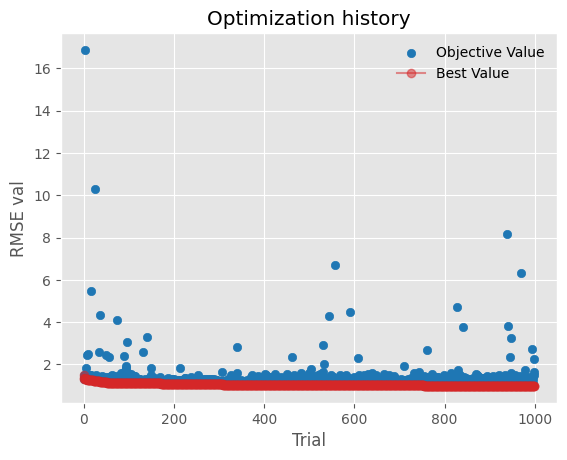


Creating model, loading weights and computing metrics...
19/19 [==============================] - 0s 917us/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.847  		 0.837
RMSE: 		 0.843  		 0.861
Fit result: Y= 2.5775917305306923  +  0.8416297582832027  * X
Figure saved
Make predictions for each fruit in the test set

	 Apple
	 R2: 	 0.808
	 RMSE: 	 0.671

	 Kiwi
	 R2: 	 0.856
	 RMSE: 	 1.262

	 Mango
	 R2: 	 0.851
	 RMSE: 	 0.748

	 Pear
	 R2: 	 0.658
	 RMSE: 	 0.983
19/19 [==============================] - 0s 695us/step
Full Test: 0.861


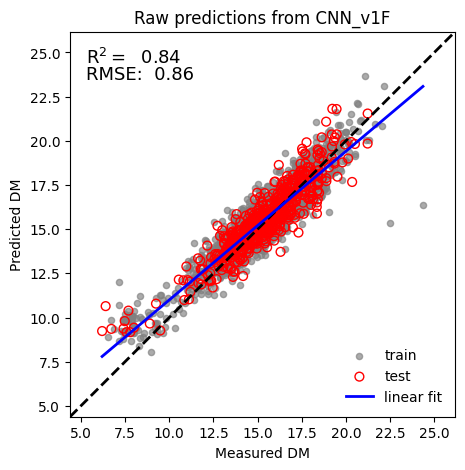

In [59]:
## Note: in the initial HPO the study_name was erroneously set to "study_v3A2" instead of "study_v1F"
study_v1F = optuna.load_study(study_name="study_v3A2", storage="sqlite:///optimization_files/study_v1F.db")

print('Result of optimization study after {} trials'.format(len(study_v1F.trials)))
print('Best trial:',study_v1F.best_trial.number)
print('Best trial value:',study_v1F.best_trial.value)
print('Best trial hyperparameters:',study_v1F.best_trial.params)


optuna.visualization.matplotlib.plot_optimization_history(study_v1F)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
plt.show()
plt.style.use('default')
# optuna.visualization.matplotlib.plot_param_importances(study_v1)
# plt.title('Parameter importances')


print('\nCreating model, loading weights and computing metrics...')
## Read the best trial parameters from previous prints and fill in to create the model
## PARMS: num_CONV_layers, num_CONV_filters, filter_sizes, num_FC_layers, num_FC_units,  DROPOUT, reg_beta
# 'batch_size': 32, 'filter_size_0': 1, 'num_CONV_filters_0': 4, 'num_CONV_layers': 1, 'num_FC_UNITS_0': 20, 'num_FC_layers': 1, 'reg_beta': 0.094
model_cnn_v1F = create_model_v1F( 1, [4], [1], 1, [20], [], 0.094 )

## Load the weights of the pre-trained / saved corresponding model
model_cnn_v1F.load_weights("optimization_files/regression_models_v1F/study_v1F_trial=754(1).h5")

## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_1F = model_cnn_v1F.predict(x_train_scaled_col)
y_test_pred_1F  = model_cnn_v1F.predict(x_test_scaled_col)


## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_1F,  y_test_pred_1F, title='Raw predictions from CNN_v1F',\
                 savefig=True, figname='prediction_v1F.png')

print('Make predictions for each fruit in the test set')
for x_fruto, y_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], fruits[:-1]):

    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))

    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred = model_cnn_v1F.predict(x_fruto_scaled, verbose=0)

    ## Compute test error scores
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred))
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f' % (scoreR2_fruto))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))

print('Full Test: {:3.3f}'.format(np.sqrt(mean_squared_error(y_test, model_cnn_v1F.predict(x_test_scaled_col)))))

In [ ]:
## update 16/09/2023 with ensemble metrics
run_Nx_cnnR_v1F_metrics(N=10, NUM_CONV_LAYERS = 1, NUM_CONV_FILTERS = [4], FILTER_SIZES = [1], NUM_FC_LAYERS = 1, 
                        NUM_FC_UNITS = [20], DROPOUT_RATE = [], REG_BETA = 0.094, BATCH_SIZE = 32, LR = 0.03, EPOCHS='auto',
                        XTRAIN = x_train_scaled_col, YTRAIN = y_train, 
                        XTEST = x_test_scaled_col, YTEST = y_test,  
                        MODEL_NAME = 'final_CNN_10x_v1F_update.h5' )


```
10x model metrics
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.871  		 0.869 		 0.893
RMSE: 		 0.774+-0.053 		 0.771+-0.052 	 0.69929
------------------------------------------------------
```

### **4.2)** Regression and Classification models

#### 4.2.1) Study v2 (optimized for 5k cross-validation) - single seed init.

Optimization of architecture v2 using a 5-fold cross-validation strategy (optimization done <font color='lightgreen'>@Athena</font>). 
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v2.ipynb *</code> | 1293 |

Two copies ran in parallel on the two GPUs with shared access to file <code>study_v2.db</code>.

NOTE: Each trial resulted in 5 saved models. The weights imported here, for the "single model predictions" correspond to the iteration that presents the lowest signs of overfitt, i.e., the lowest difference between calibration RMSE and validation RMSE. In this case:
 ```
Running iteration Trial(Run)  274 ( 5 ) --------
Calibration RMSE = 0.6113121835013384
Validation RMSE = 0.6270875875723703
Calibration accuracy = 1.0
Validation accuracy = 1.0
 ```

 NOTE: Original source name <code>Multifruit_optimization_v2 - Copy.ipynb *</code>


In [17]:
## Make computations reproducible
reproducible_comp()

def create_model_2(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    K_NUMBER = 1
    K_WIDTH = filter_size
    K_STRIDE = 1
    CLASS_OUTPUT_DIMS = 4
    REG_OUTPUT_DIMS = 1
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## Weights initialization for multiple layers
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    input_layer = layers.Input(shape=(INPUT_DIMS,), name='INPUT')
    x = layers.Reshape((INPUT_DIMS, 1),name='RESHAPE')(input_layer)
    x = layers.Conv1D(filters=K_NUMBER, 
                      kernel_size=K_WIDTH, 
                      strides=K_STRIDE, 
                      padding='same', 
                      kernel_initializer=K_INIT,
                      kernel_regularizer=K_REG,
                      activation='elu',
                      name='CONVOLUTIONAL')(x)
    
    x = layers.Flatten(name='FLATTEN')(x)

    for i in range(0, num_FC_layers):
        x = layers.Dense(num_FC_units[i], 
                         kernel_initializer=K_INIT, 
                         kernel_regularizer=K_REG,
                         activation='elu', 
                         name='DENSE'+str(i))(x)
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            x = layers.Dropout(DROPOUT[i], name='DROPOUT'+str(i))(x)

    # Classification output
    class_output = layers.Dense(CLASS_OUTPUT_DIMS, 
                                kernel_initializer=K_INIT, 
                                activation='softmax', 
                                name='CLASS_OUTPUT')(x)
    
    # Regression output
    reg_output = layers.Dense(REG_OUTPUT_DIMS, 
                              kernel_initializer=K_INIT, 
                              activation='linear', 
                              name='REG_OUTPUT')(x)

    # Create the model with multiple outputs
    model_cnn = Model(inputs=input_layer, outputs=[class_output, reg_output], name='MODEL_CNN_V2')
    
    return model_cnn

In [62]:
def run_Nx_cnnRC_v2_metrics(N, NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, BATCH_SIZE, LR,
                            EPOCHS, XTRAIN, YTRAIN, LABELS_TRAIN, CLASS_TRAIN,
                            XTEST, YTEST, CLASS_TEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for 10x CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
   
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    ACC_train_list = []
    ACC_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf, labels_train_shuf = shuffle(XTRAIN, YTRAIN, LABELS_TRAIN, random_state=42)
    
    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):

            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index]
            labels_cal_shuf, labels_val_shuf = labels_train_shuf[cal_index], labels_train_shuf[val_index]

            ## Create a new model instance
            MODEL = create_model_2(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=['categorical_crossentropy', 'mse'],
                          metrics=[['acc'], ['mse']]) 

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, [labels_cal_shuf, y_cal_shuf], batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, [labels_val_shuf, y_val_shuf]),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')   

    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ', N,' times')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []
    class_train_shuf_list = []
    labels_train_shuf_list = []
    labels_test_pred_list = []
    
    ## Train 10 models for this number of epochs, and compute mean error of predictions
    for i in np.arange(0,N,1):
    
        ## Create a new model instance (reset weights)
        MODEL = create_model_2(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=['categorical_crossentropy', 'mse'],
                      metrics=[['acc'], ['mse']]) 

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf, labels_train_shuf, class_train_shuf = shuffle(XTRAIN, YTRAIN,
                                                                                         LABELS_TRAIN, CLASS_TRAIN,
                                                                                         random_state = int(i))
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)
        class_train_shuf_list.append(class_train_shuf)
        labels_train_shuf_list.append(labels_train_shuf)

        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, [labels_train_shuf, y_train_shuf], 
                       batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
         
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)[1]
        y_test_pred = MODEL.predict(XTEST)[1]
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

        ## Compute metrics Train and Test classifications metrics
        label_train_pred = MODEL.predict(x_train_scaled_shuf, verbose=0)[0]
        label_test_pred  = MODEL.predict(XTEST, verbose=0)[0]
        ## store the predicted labels for later use
        labels_test_pred_list.append(label_test_pred)

        ## Convert the one-hot encoded labels into a single integer class
        class_train_pred = np.argmax(label_train_pred, axis = 1)
        class_test_pred = np.argmax(label_test_pred, axis = 1)
        
        acc_train = accuracy_score(class_train_shuf, class_train_pred)
        acc_test = accuracy_score(CLASS_TEST, class_test_pred)
        
        ## append values to list
        ACC_train_list.append(acc_train)
        ACC_test_list.append(acc_test)
        
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
        print('\t ACC: \t\t %5.3f \t\t\t %5.3f' % (acc_train, acc_test))
        
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #     plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v2',\
        #                      savefig=False, figname='cnn_v2_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    ACC_train_mean = np.mean(ACC_train_list)
    ACC_test_mean = np.mean(ACC_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))
    ## Since the labels are probabilities, we can find the mean probability (ensemble) and compute its class and accuracy
    labels_test_pred_ensemble = np.mean(labels_test_pred_list, axis=0)
    ACC_test_ensemble = accuracy_score(np.ravel(CLASS_TEST), np.ravel(np.argmax(labels_test_pred_ensemble, axis = 1)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('ACC: \t\t\t %5.3f \t\t\t %5.3f \t\t %5.3f' % (ACC_train_mean, ACC_test_mean, ACC_test_ensemble))
    print('------------------------------------------------------')
    return

Result of optimization study after 1000 trials
Best trial: 274
Best trial value: 0.663957086164221
Best trial hyperparameters: {'batch_size': 144, 'filter_size': 45, 'num_FC_UNITS_0': 84, 'num_FC_layers': 1, 'reg_beta': 0.025500000000000002}

Creating model, loading weights and computing metrics...
Model: "MODEL_CNN_V2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT (InputLayer)             [(None, 105)]        0           []                               
                                                                                                  
 RESHAPE (Reshape)              (None, 105, 1)       0           ['INPUT[0][0]']                  
                                                                                                  
 CONVOLUTIONAL (Conv1D)         (None, 105, 1)       46          ['RESHAPE[0][0]']  

C:\Users\dario\AppData\Local\Temp\ipykernel_2468\731268716.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v2)


19/19 [==============================] - 0s 1ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.919  		 0.914
RMSE: 		 0.614  		 0.625
Fit result: Y= 1.2378376726815203  +  0.9184069540449494  * X
Figure saved
19/19 [==============================] - 0s 620us/step

Train metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1124
           1       1.00      1.00      1.00       438
           2       1.00      1.00      1.00       580
           3       1.00      1.00      1.00       255

    accuracy                           1.00      2397
   macro avg       1.00      1.00      1.00      2397
weighted avg       1.00      1.00      1.00      2397


Test metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      1.00      1.00       110
           2       0.99      1.00      1.00       145

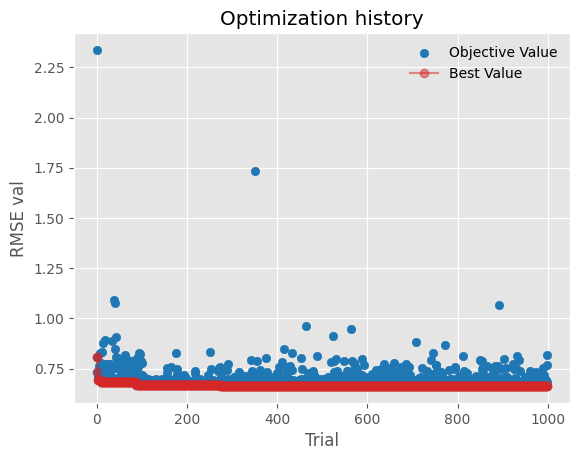

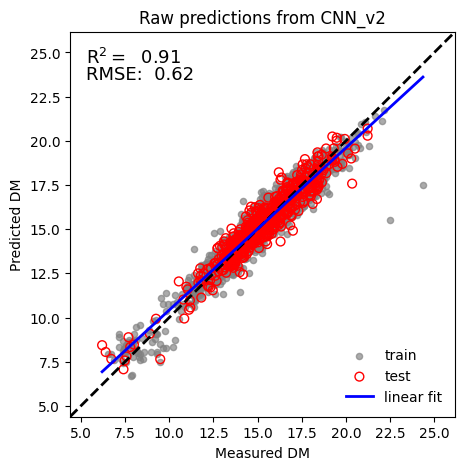

In [64]:
study_v2 = optuna.load_study(study_name="study_v2", storage="sqlite:///optimization_files/study_v2.db")

print('Result of optimization study after {} trials'.format(len(study_v2.trials)))
print('Best trial:', study_v2.best_trial.number)
print('Best trial value:',study_v2.best_trial.value)
print('Best trial hyperparameters:',study_v2.best_trial.params)

optuna.visualization.matplotlib.plot_optimization_history(study_v2)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
# optuna.visualization.matplotlib.plot_param_importances(study_v2)
# plt.show()
plt.style.use('default')

print('\nCreating model, loading weights and computing metrics...')
# ## Read the best trial parameters from previous prints and fill in to create the model
# ## PARMS: num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta
model_cnn_v2 = create_model_2(1, [84], 45, [], 0.0255)

# # ## Load the weights of the pre-trained / saved corresponding model
model_cnn_v2.load_weights("optimization_files/multioutput_models_v2/study_v2c_trial=274(4).h5")
model_cnn_v2.summary()

# ## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_v2 = model_cnn_v2.predict(x_train_scaled_col)[1]
y_test_pred_v2 = model_cnn_v2.predict(x_test_scaled_col)[1]


# ## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_v2,  y_test_pred_v2, title='Raw predictions from CNN_v2', \
                 savefig=True, figname='prediction_v2.png')


########### Compute metrics Train and test classifications  #####################
label_train_pred_v2 = model_cnn_v2.predict(x_train_scaled_col)[0]
label_test_pred_v2 = model_cnn_v2.predict(x_test_scaled_col)[0]
## Convert the one-hot encoded labels into a single integer class
class_train_pred_v2 = np.argmax(label_train_pred_v2, axis=1)
class_test_pred_v2 = np.argmax(label_test_pred_v2, axis=1)

print('\nTrain metrics')
print(classification_report(class_train, class_train_pred_v2))
print('\nTest metrics')
print(classification_report(class_test, class_test_pred_v2))


########### Compute metrics on individual fruits  ###############################
## list to store the mean spectra of each fruit in the test set
mean_x_test_list = []

for x_fruto, y_fruto, class_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], class_test_list[:-1], fruits[:-1]):
    ## standardize the spectra of each fruit in the test set
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))

    ## store mean spectra of each fruit in the test set
    mean_x_test_list.append(np.mean(np.array(x_fruto), axis=0))
    
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred_v2 = model_cnn_v2.predict(x_fruto_scaled, verbose=0)[1]
    class_fruto_pred_v2 = np.argmax(model_cnn_v2.predict(x_fruto_scaled, verbose=0)[0],axis=1)

    ## Compute test error scores
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred_v2)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred_v2))
    acc_fruto = accuracy_score(class_fruto, class_fruto_pred_v2)
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f' % (scoreR2_fruto))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))
    print('\t ACC: \t %5.3f' % (acc_fruto))

print('Test RMSE:', np.sqrt(mean_squared_error(y_test, model_cnn_v2.predict(x_test_scaled_col)[1])))
print('Test ACC:', accuracy_score(class_test, np.argmax(model_cnn_v2.predict(x_test_scaled_col)[0],axis=1)))

print('Best trial hyperparameters:',study_v2.best_trial.params)

In [ ]:
## update 28/08/2023 with ensemble predictions
run_Nx_cnnRC_v2_metrics(N=10, NUM_FC_LAYERS = 1, NUM_FC_UNITS = [84], FILTER_SIZE = 45, DROPOUT = [], REG_BETA = 0.0255, BATCH_SIZE = 144, LR = 0.03,
                        EPOCHS=419 , XTRAIN = x_train_scaled_col, YTRAIN = y_train, LABELS_TRAIN = labels_train, CLASS_TRAIN = class_train,
                        XTEST = x_test_scaled_col, YTEST = y_test,  CLASS_TEST = class_test,
                        MODEL_NAME = 'final_CNN_10x_v2_update.h5' )

updated metrics on 28/08/2023 with ensemble prediction
```
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.914  		 0.912 		 0.921
RMSE: 		 0.632+-0.008 		 0.634+-0.008 	 0.59889
ACC: 		 1.000 			 0.998 		 1.000
------------------------------------------------------
```

In [ ]:
model_cnn_v2 = create_model_2(1, [84], 45, [], 0.0255)
## load pre-computed model weights into model_cnn
model_cnn_v2.load_weights("final_CNN_v2.h5")

########### Compute metrics on individual fruits  ###############################
## list to store the mean spectra of each fruit in the test set
mean_x_test_list = []

for x_fruto, y_fruto, class_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], class_test_list[:-1], fruits[:-1]):
    ## standardize the spectra of each fruit in the test set
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))

    ## store mean spectra of each fruit in the test set
    mean_x_test_list.append(np.mean(np.array(x_fruto), axis=0))
    
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred_v2 = model_cnn_v2.predict(x_fruto_scaled, verbose=0)[1]
    class_fruto_pred_v2 = np.argmax(model_cnn_v2.predict(x_fruto_scaled, verbose=0)[0],axis=1)

    ## Compute test error scores
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred_v2)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred_v2))
    acc_fruto = accuracy_score(class_fruto, class_fruto_pred_v2)
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f' % (scoreR2_fruto))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))
    print('\t ACC: \t %5.3f' % (acc_fruto))

print('Test RMSE:', np.sqrt(mean_squared_error(y_test, model_cnn_v2.predict(x_test_scaled_col)[1])))
print('Test ACC:', accuracy_score(class_test, np.argmax(model_cnn_v2.predict(x_test_scaled_col)[0],axis=1)))


	 Apple
	 R2: 	 0.851
	 RMSE: 	 0.592
	 ACC: 	 0.993

	 Kiwi
	 R2: 	 0.936
	 RMSE: 	 0.841
	 ACC: 	 1.000

	 Mango
	 R2: 	 0.910
	 RMSE: 	 0.581
	 ACC: 	 1.000

	 Pear
	 R2: 	 0.797
	 RMSE: 	 0.757
	 ACC: 	 1.000
19/19 [==============================] - 0s 722us/step
Test RMSE: 0.66051835
19/19 [==============================] - 0s 709us/step
Test ACC: 0.9966666666666667


#### **4.2.2)** Study v2B (optimized for 5k cross-validation) - **multi** seed init 

Optimization of architecture v2 using a 5-fold cross-validation strategy (optimization done <font color='lightgreen'>@deep-cybertron</font>) and **multi** seed initialization. 
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v2B.ipynb</code> | 3780 |

that produced file <code>study_v2B.db</code> (original source name -> second sweep <code>study_v2B_2.db</code>).

NOTE: Each trial resulted in 5 saved models. The weights imported here, for the "single model predictions" correspond to the iteration that presents the lowest signs of overfitt, i.e., the lowest difference between calibration RMSE and validation RMSE. In this case:

```
Running iteration Trial(Run)  1308 ( 5 ), SEED =  2109818  --------
Training: 90% 452/500 ETA: 00:06s, 7.79epochs/s
Calibration RMSE = 0.6059493587724378
Validation RMSE = 0.6286643848563188
Calibration accuracy = 1.0
Validation accuracy = 0.9979122877120972
``` 

In [18]:
## Make computations reproducible
reproducible_comp()


def create_model_2B(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta, SEED):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    K_NUMBER = 1
    K_WIDTH = filter_size
    K_STRIDE = 1
    CLASS_OUTPUT_DIMS = 4
    REG_OUTPUT_DIMS = 1
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## Weights initialization for multiple layers - SEED DEFINED in MODEL creation
    K_INIT = tf.keras.initializers.he_normal(seed=SEED)
    
    ## Architecture of the main model
    input_layer = layers.Input(shape=(INPUT_DIMS,), name='INPUT')
    x = layers.Reshape((INPUT_DIMS, 1))(input_layer)
    x = layers.Conv1D(filters=K_NUMBER, 
                      kernel_size=K_WIDTH, 
                      strides=K_STRIDE, 
                      padding='same', 
                      kernel_initializer=K_INIT,
                      kernel_regularizer=K_REG,
                      activation='elu',
                      name='CONVOLUTIONAL')(x)
    
    x = layers.Flatten(name='FLATTEN')(x)

    for i in range(0, num_FC_layers):
        x = layers.Dense(num_FC_units[i], 
                         kernel_initializer=K_INIT, 
                         kernel_regularizer=K_REG,
                         activation='elu', 
                         name='DENSE'+str(i))(x)
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            x = layers.Dropout(DROPOUT[i], name='DROPOUT'+str(i))(x)

    # Classification output
    class_output = layers.Dense(CLASS_OUTPUT_DIMS, 
                                kernel_initializer=K_INIT, 
                                activation='softmax', 
                                name='CLASS_OUTPUT')(x)
    
    # Regression output
    reg_output = layers.Dense(REG_OUTPUT_DIMS, 
                              kernel_initializer=K_INIT, 
                              activation='linear', 
                              name='REG_OUTPUT')(x)

    # Create the model with multiple outputs
    model_cnn = Model(inputs=input_layer, outputs=[class_output, reg_output], name='MODEL_CNN_V2B')
    
    return model_cnn

In [19]:
def run_Nx_cnnRC_v2B_metrics(N, NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, 
                             BATCH_SIZE, LR, EPOCHS,
                             XTRAIN, YTRAIN, LABELS_TRAIN, CLASS_TRAIN,
                             XTEST, YTEST,  CLASS_TEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for 10x CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
   
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    ACC_train_list = []
    ACC_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf, labels_train_shuf = shuffle(XTRAIN, YTRAIN, LABELS_TRAIN, random_state=42)
    
    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):
            SEED = np.random.randint(1, 1000)
            print('Initializing model with seed: ', SEED)         
            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index]
            labels_cal_shuf, labels_val_shuf = labels_train_shuf[cal_index], labels_train_shuf[val_index]

            ## Create a new model instance
            MODEL = create_model_2B(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, SEED)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=['categorical_crossentropy', 'mse'],
                          metrics=[['acc'], ['mse']]) 

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, [labels_cal_shuf, y_cal_shuf], batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, [labels_val_shuf, y_val_shuf]),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')   

    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ', N,' times')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []
    class_train_shuf_list = []
    labels_train_shuf_list = []
    labels_test_pred_list = []

    ## Train N models for this number of epochs, and compute mean error of predictions
    for i in np.arange(0,N,1):
        SEED = np.random.randint(1,1000)
        print('Initializing model with seed: ', SEED)
        ## Create a new model instance (reset weights)
        MODEL = create_model_2B(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT, REG_BETA, SEED)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=['categorical_crossentropy', 'mse'],
                      metrics=[['acc'], ['mse']]) 

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf, labels_train_shuf, class_train_shuf = shuffle(XTRAIN, YTRAIN,
                                                                                         LABELS_TRAIN, CLASS_TRAIN,
                                                                                         random_state = int(i))
        
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)
        class_train_shuf_list.append(class_train_shuf)
        labels_train_shuf_list.append(labels_train_shuf)
        
        ## CONTROL
        # print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, [labels_train_shuf, y_train_shuf], 
                       batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
         
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)[1]
        y_test_pred = MODEL.predict(XTEST)[1]
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

        ## Compute metrics Train and Test classifications metrics
        label_train_pred = MODEL.predict(x_train_scaled_shuf, verbose=0)[0]
        label_test_pred  = MODEL.predict(XTEST, verbose=0)[0]
        ## store the predicted labels for later use
        labels_test_pred_list.append(label_test_pred)

        ## Convert the one-hot encoded labels into a single integer class
        class_train_pred = np.argmax(label_train_pred, axis = 1)
        class_test_pred = np.argmax(label_test_pred, axis = 1)
        acc_train = accuracy_score(class_train_shuf, class_train_pred)
        acc_test = accuracy_score(CLASS_TEST, class_test_pred)
        
        ## append values to list
        ACC_train_list.append(acc_train)
        ACC_test_list.append(acc_test)
        
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
        print('\t ACC: \t\t %5.3f \t\t\t %5.3f' % (acc_train, acc_test))
        
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

                ## Plot last run predictions
        # if i==9:
        #     plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v2',\
        #                      savefig=False, figname='cnn_v2B_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    ACC_train_mean = np.mean(ACC_train_list)
    ACC_test_mean = np.mean(ACC_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))
    ## Since the labels are probabilities, we can find the mean probability (ensemble) and compute its class and accuracy
    labels_test_pred_ensemble = np.mean(labels_test_pred_list, axis=0)
    ACC_test_ensemble = accuracy_score(np.ravel(CLASS_TEST), np.ravel(np.argmax(labels_test_pred_ensemble, axis = 1)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('ACC: \t\t\t %5.3f \t\t\t %5.3f \t\t %5.3f' % (ACC_train_mean, ACC_test_mean, ACC_test_ensemble))
    print('------------------------------------------------------')
    return

Result of optimization study after 1916 trials
Best trial: 1308
Best trial value: 0.6594797554064918
Best trial hyperparameters: {'batch_size': 256, 'filter_size': 43, 'num_FC_UNITS_0': 36, 'num_FC_layers': 1, 'reg_beta': 0.0225}


C:\Users\dario\AppData\Local\Temp\ipykernel_20160\2177016100.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v2B_2)


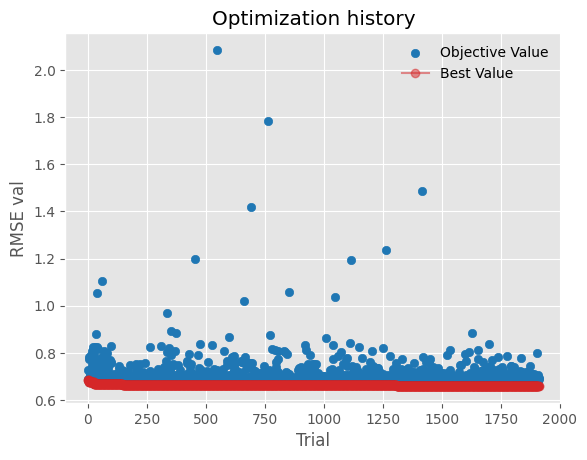


Creating model, loading weights and computing metrics...
Model: "MODEL_CNN_V2B"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT (InputLayer)             [(None, 105)]        0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 105, 1)       0           ['INPUT[0][0]']                  
                                                                                                  
 CONVOLUTIONAL (Conv1D)         (None, 105, 1)       44          ['reshape_1[0][0]']              
                                                                                                  
 FLATTEN (Flatten)              (None, 105)          0           ['CONVOLUTIONAL[0][0]']          
                            

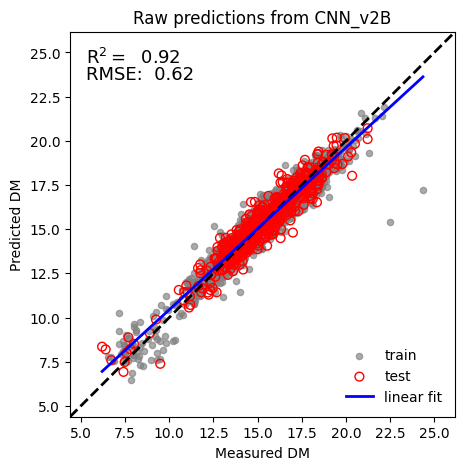

In [21]:
study_v2B_2 = optuna.load_study(study_name="study_v2B", storage="sqlite:///optimization_files/study_v2B.db")

print('Result of optimization study after {} trials'.format(len(study_v2B_2.trials)))
print('Best trial:', study_v2B_2.best_trial.number)
print('Best trial value:',study_v2B_2.best_trial.value)
print('Best trial hyperparameters:',study_v2B_2.best_trial.params)

optuna.visualization.matplotlib.plot_optimization_history(study_v2B_2)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
# optuna.visualization.matplotlib.plot_param_importances(study_v2B)
plt.show()
plt.style.use('default')

print('\nCreating model, loading weights and computing metrics...')
## Read the best trial parameters from previous prints and fill in to create the model
## PARMS: num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta, SEED
model_cnn_v2B_2 = create_model_2B(1, [36], 43, [], 0.0225, 2109818)

## Load the weights of the pre-trained / saved corresponding model
model_cnn_v2B_2.load_weights("optimization_files/multioutput_models_v2B/study_v2Bc4_trial=1308(4).h5")
model_cnn_v2B_2.summary()

## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_v2B_2 = model_cnn_v2B_2.predict(x_train_scaled_col)[1]
y_test_pred_v2B_2 = model_cnn_v2B_2.predict(x_test_scaled_col)[1]


## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_v2B_2,  y_test_pred_v2B_2, title='Raw predictions from CNN_v2B', \
                 savefig=True, figname='prediction_v2B.png')


########### Compute metrics Train and test classifications  #####################
label_train_pred_v2B_2 = model_cnn_v2B_2.predict(x_train_scaled_col)[0]
label_test_pred_v2B_2 = model_cnn_v2B_2.predict(x_test_scaled_col)[0]
## Convert the one-hot encoded labels into a single integer class
class_train_pred_v2B_2 = np.argmax(label_train_pred_v2B_2, axis=1)
class_test_pred_v2B_2 = np.argmax(label_test_pred_v2B_2, axis=1)

print('\nTrain metrics')
print(classification_report(class_train, class_train_pred_v2B_2))
print('\nTest metrics')
print(classification_report(class_test, class_test_pred_v2B_2))


########### Compute metrics on individual fruits  ###############################
## list to store the mean spectra of each fruit in the test set
mean_x_test_list = []

for x_fruto, y_fruto, class_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], class_test_list[:-1], fruits[:-1]):
    ## standardize the spectra of each fruit in the test set
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))

    ## store mean spectra of each fruit in the test set
    mean_x_test_list.append(np.mean(np.array(x_fruto), axis=0))
    
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred_v2B_2 = model_cnn_v2B_2.predict(x_fruto_scaled, verbose=0)[1]
    class_fruto_pred_v2B_2 = np.argmax(model_cnn_v2B_2.predict(x_fruto_scaled, verbose=0)[0],axis=1)

    ## Compute test error scores
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred_v2B_2)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred_v2B_2))
    acc_fruto = accuracy_score(class_fruto, class_fruto_pred_v2B_2)
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f' % (scoreR2_fruto))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))
    print('\t ACC: \t %5.3f' % (acc_fruto))

print('Test RMSE:', np.sqrt(mean_squared_error(y_test, model_cnn_v2B_2.predict(x_test_scaled_col)[1])))
print('Test ACC:', accuracy_score(class_test, np.argmax(model_cnn_v2B_2.predict(x_test_scaled_col)[0],axis=1)))
print('Best trial hyperparameters:',study_v2B_2.best_trial.params)

In [ ]:
## updated 28/08/2023 with ensemble metrics
run_Nx_cnnRC_v2B_metrics(N=10, NUM_FC_LAYERS = 1, NUM_FC_UNITS = [36], FILTER_SIZE = 43, DROPOUT = [], REG_BETA = 0.0225, 
                         BATCH_SIZE = 256, LR = 0.03,EPOCHS=379,
                         XTRAIN = x_train_scaled_col, YTRAIN = y_train, LABELS_TRAIN = labels_train, CLASS_TRAIN = class_train,
                         XTEST = x_test_scaled_col, YTEST = y_test,  CLASS_TEST = class_test,
                         MODEL_NAME = 'final_CNN_10x_v2B_2_update.h5')

updated metrics on 28/08/2023 with ensemble prediction
```
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.917  		 0.912 		 0.921
RMSE: 		 0.620+-0.012 		 0.635+-0.015 	 0.59940
ACC: 		 1.000 			 1.000 		 1.000
------------------------------------------------------
```

### **4.3)** Regression and Classification CNN with more than 1 conv. layer

####  **4.3.1)**  Study_v2C (optimized for 5k cross-validation) - single seed init.

Optimization of architecture v2C (originally named v3) using a 5-fold cross-validation strategy (optimization done <font color='lightgreen'>@Athena, @cybertron , @deep-cybertron</font>). 
The relevant files are: <br> 
|MODEL | COMPUTATION TIME  (min) |
|:------|:--------------:|
|<code>Multifruit_optimization_v2C.ipynb</code> | ? | 


Four copies ran in parallel on different GPUs with shared access to file <code>study_v2C.db</code> (original name study_v3.db).

NOTE: Each trial resulted in 5 saved models. The weights imported here, for the "single model predictions" correspond to the iteration that presents the lowest signs of overfitt, i.e., the lowest difference between calibration RMSE and validation RMSE. In this case:
 

<font color='lightgreen'> @deep-cybertron (BEST!) </font>
 ```
Running iteration Trial(Run)  798 ( 3 ) --------
Calibration RMSE = 0.5827969628275198
Validation RMSE = 0.6139287992332909
Calibration accuracy = 1.0
Validation accuracy = 0.9979122877120972
```


In [23]:
## Make computations reproducible
reproducible_comp()


def create_model_3(num_CONV_layers, num_CONV_filters, filter_sizes, num_FC_layers, num_FC_units,  DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train_scaled_col)[1]
    K_NUMBER = num_CONV_filters
    K_WIDTH = filter_sizes
    K_STRIDE = 1
    CLASS_OUTPUT_DIMS = 4
    REG_OUTPUT_DIMS = 1
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## Weights initialization for multiple layers
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    input_layer = layers.Input(shape=(INPUT_DIMS,), name='INPUT')
    x = layers.Reshape((INPUT_DIMS, 1))(input_layer)

    for i in range(0, num_CONV_layers):
        x = layers.Conv1D(filters=K_NUMBER[i], 
                          kernel_size=K_WIDTH[i], 
                          strides=K_STRIDE, 
                          padding='same', 
                          kernel_initializer=K_INIT,
                          kernel_regularizer=K_REG,
                          activation='elu',
                          name='CONVOLUTIONAL' + str(i))(x)
        x = layers.BatchNormalization()(x)
    
    x = layers.Flatten(name='FLATTEN')(x)

    for i in range(0, num_FC_layers):
        x = layers.Dense(num_FC_units[i], 
                         kernel_initializer=K_INIT, 
                         kernel_regularizer=K_REG,
                         activation='elu', 
                         name='DENSE'+str(i))(x)
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            x = layers.Dropout(DROPOUT[i], name='DROPOUT'+str(i))(x)

    # Classification output
    class_output = layers.Dense(CLASS_OUTPUT_DIMS, 
                                kernel_initializer=K_INIT, 
                                activation='softmax', 
                                name='CLASS_OUTPUT')(x)
    
    # Regression output
    reg_output = layers.Dense(REG_OUTPUT_DIMS, 
                              kernel_initializer=K_INIT, 
                              activation='linear', 
                              name='REG_OUTPUT')(x)

    # Create the model with multiple outputs
    model_cnn = Model(inputs=input_layer, outputs=[class_output, reg_output], name='MODEL_CNN_V3')
    
    return model_cnn


In [24]:

## function to train N models and compute average metrics
def run_Nx_cnnRC_v3_metrics(N, NUM_CONV_LAYERS, NUM_CONV_FILTERS, FILTER_SIZES, NUM_FC_LAYERS, NUM_FC_UNITS, 
                            DROPOUT_RATE, REG_BETA, BATCH_SIZE, LR, EPOCHS,
                            XTRAIN, YTRAIN, LABELS_TRAIN, CLASS_TRAIN,
                            XTEST, YTEST, CLASS_TEST, MODEL_NAME):
    ''' 
    ########### Compute the metrics for 10x CNN models  ################
    1st:Determine the best number of epochs for training the model
        1) Shuffle train data
        2) Create a 5-fold CV scheme where the train data is split into cal and val sets
        3) Train model in 5-fold CV monitoring the val loss in early stopping
           During training, the rdlr callback monitors the val_loss
        4) Save the epoch where early stopping was triggered into a list
    2nd: Determine the best number of epochs for training the model based on the mean of the epochs where early stopping was triggered
    3rd: Train the model 10x (on randomized versions of the train set) with the best number of epochs
         No validation split or validation data is used and the 'rdlr' callback monitors the training loss
    4th: Compute error metrics on train and test sets
    5th: Compute the mean and std of the error metrics over the 10x models
    '''
   
    
    ## Create lists to store metrics  
    RMSE_train_list = []
    R2_train_list = []
    RMSE_test_list = []
    R2_test_list = []
    ACC_train_list = []
    ACC_test_list = []
    epochs_list = []

    ## Callbacks
    progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, update_per_second=5)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=52, mode='auto', 
                                               restore_best_weights=True, verbose=1)  
    rdlr_cv = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
    
    ## Shuffle train data to mix samples with the same seed used in the HPO
    x_train_scaled_shuf, y_train_shuf, labels_train_shuf = shuffle(XTRAIN, YTRAIN, LABELS_TRAIN, random_state=42)
    
    if EPOCHS == 'auto':
        ########### Train the model 5 times in CV to find the optimal number of epochs ###########
        # create KFold object
        kf = KFold(n_splits = 5)

        print('Train data shuffled... Determining optimal number of epochs using 5-fold CV...\n')

        ## Loop for training the model 5 times under different calibration/validation splits
        for i, (cal_index, val_index) in enumerate(kf.split(x_train_scaled_shuf)):

            ## Define the cal and val sets for this iteration
            x_cal_scaled_shuf, x_val_scaled_shuf = x_train_scaled_shuf[cal_index], x_train_scaled_shuf[val_index]
            y_cal_shuf, y_val_shuf = y_train_shuf[cal_index], y_train_shuf[val_index]
            labels_cal_shuf, labels_val_shuf = labels_train_shuf[cal_index], labels_train_shuf[val_index]

            ## Create a new model instance
            MODEL = create_model_3(NUM_CONV_LAYERS, NUM_CONV_FILTERS, FILTER_SIZES, NUM_FC_LAYERS, NUM_FC_UNITS, DROPOUT_RATE, REG_BETA)
            ## Compile the model defining the optimizer, the loss function and the metrics to track during training
            MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=['categorical_crossentropy', 'mse'],
                          metrics=[['acc'], ['mse']]) 

            ## Train the model for a max 500 of epochs on the cal set and track the val loss
            MODEL.fit(x_cal_scaled_shuf, [labels_cal_shuf, y_cal_shuf], batch_size = BATCH_SIZE, epochs = 500,\
                      validation_data = (x_val_scaled_shuf, [labels_val_shuf, y_val_shuf]),\
                      callbacks=[rdlr_cv, early_stop],\
                      verbose=0)

            ## Store the number of epochs the model was trained for. If early stopping was not triggered, store 500
            if early_stop.stopped_epoch==0:
                print('\nReached the max training epochs')
                epochs_list.append(500)
            else:
                epochs_list.append(early_stop.stopped_epoch)

            keras.backend.clear_session()
        ## END CROSS-VALIDATION LOOP FOR EPOCHS DETERMINATION

        ## Get the mean of the training epochs identified in 10k cross validation
        max_epoch = np.mean(epochs_list)
        print('\nThe model trained for', int(max_epoch), 'epochs on average in 5-fold cross-validation.')
    else:
        max_epoch = EPOCHS
        print('\nThe model will be trained for', int(max_epoch), 'epochs set manually')   

    print('\n\n---------------------------------------------------------------------------------------------------------\n')
    print('Training final model for', int(max_epoch), 'epochs on the full train set ', N,' times')

    ## Callbacks redefinition so that the rdlr monitors just the train loss
    rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=0)

    y_train_shuf_list = []
    y_test_pred_list = []
    class_train_shuf_list = []
    labels_train_shuf_list = []
    labels_test_pred_list = []

    ## Train 10 models for this number of epochs, and compute mean error of predictions
    for i in np.arange(0,N,1):
    
        ## Create a new model instance (reset weights)
        MODEL = create_model_3(NUM_CONV_LAYERS, NUM_CONV_FILTERS, FILTER_SIZES, NUM_FC_LAYERS, NUM_FC_UNITS, DROPOUT_RATE, REG_BETA)
        ## Compile the model defining the optimizer, the loss function and the metrics to track during training
        MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=['categorical_crossentropy', 'mse'],
                      metrics=[['acc'], ['mse']]) 

        ## Save the best model based on the cal loss (the val loss is not used at any point during training)
        checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=0, save_best_only=True)

        ## Shuffle training data to ensure different batches in each training run (the random_state is set for reproducibility)
        x_train_scaled_shuf, y_train_shuf, labels_train_shuf, class_train_shuf = shuffle(XTRAIN, YTRAIN,
                                                                                         LABELS_TRAIN, CLASS_TRAIN,
                                                                                         random_state = int(i))
        
        ## Store the shuffled train data for later use
        y_train_shuf_list.append(y_train_shuf)
        class_train_shuf_list.append(class_train_shuf)
        labels_train_shuf_list.append(labels_train_shuf)

        print(f'\n Run {i}...\n Train data reshuffled...\n First 3 train samples: {np.ravel(y_train_shuf[0:4])}')

        ## train the model each time on a different shuffle of the training data
        MODEL.fit(x_train_scaled_shuf, [labels_train_shuf, y_train_shuf], 
                       batch_size = BATCH_SIZE, shuffle=False, epochs = int(max_epoch), 
                       callbacks=[rdlr, checkpointer, progressbar], verbose=0)
        
         
        print(f'\n Training completed... \n Loading best model weights from {MODEL_NAME}... \n Computing metrics for Run {i}...')
        ## Load the best model weights
        MODEL.load_weights(MODEL_NAME)

        ## Compute RMSE metrics for TRAIN and TEST sets
        y_train_pred = MODEL.predict(x_train_scaled_shuf)[1]
        y_test_pred = MODEL.predict(XTEST)[1]
        ## Save the test predictions into a list
        y_test_pred_list.append(y_test_pred)

        ## Compute train error scores 
        scoreR2_train = r2_score(y_train_shuf, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_shuf, y_train_pred))
        RMSE_train_list.append(rmse_train)
        R2_train_list.append(scoreR2_train)

        ## Compute test error scores 
        scoreR2_test = r2_score(YTEST, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(YTEST, y_test_pred))
        RMSE_test_list.append(rmse_test)
        R2_test_list.append(scoreR2_test)

        ## Compute metrics Train and Test classifications metrics
        label_train_pred = MODEL.predict(x_train_scaled_shuf, verbose=0)[0]
        label_test_pred  = MODEL.predict(XTEST, verbose=0)[0]
        ## store the predicted labels for later use
        labels_test_pred_list.append(label_test_pred)

        ## Convert the one-hot encoded labels into a single integer class
        class_train_pred = np.argmax(label_train_pred, axis = 1)
        class_test_pred = np.argmax(label_test_pred, axis = 1)
        acc_train = accuracy_score(class_train_shuf, class_train_pred)
        acc_test = accuracy_score(CLASS_TEST, class_test_pred)
        
        ## append values to list
        ACC_train_list.append(acc_train)
        ACC_test_list.append(acc_test)
        
        print('\nEVAL '+str(i)+' ERROR METRICS: \t TRAIN  \t\t TEST')
        print('\t R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
        print('\t RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train, rmse_test))
        print('\t ACC: \t\t %5.3f \t\t\t %5.3f' % (acc_train, acc_test))
        
        ## Clear clutter from previous session
        keras.backend.clear_session()
        print('\n Keras backend cleared...')

        ## Plot last run predictions
        # if i==9:
        #     plot_prediction2(y_train_shuf,  YTEST, y_train_pred,  y_test_pred, title='CNN v3',\
        #                      savefig=False, figname='cnn_v3_prediction_run.png')
    ### END FOR CYLE

    ## Compute mean of 10 runs
    RMSE_train_mean = np.mean(RMSE_train_list)
    RMSE_test_mean = np.mean(RMSE_test_list)
    ACC_train_mean = np.mean(ACC_train_list)
    ACC_test_mean = np.mean(ACC_test_list)
    R2_train_mean = np.mean(R2_train_list)
    R2_test_mean = np.mean(R2_test_list)
    RMSE_train_std = np.std(RMSE_train_list)
    RMSE_test_std = np.std(RMSE_test_list)

    ## Compute y_test_pred mean and compute ensemble R2 and RMSE
    y_test_pred_ensemble = np.mean(y_test_pred_list, axis=0)
    R2_test_ensemble = r2_score(np.ravel(YTEST), np.ravel(y_test_pred_ensemble))   
    RMSE_test_ensemble = np.sqrt(mean_squared_error(np.ravel(YTEST), np.ravel(y_test_pred_ensemble)))
    ## Since the labels are probabilities, we can find the mean probability (ensemble) and compute its class and accuracy
    labels_test_pred_ensemble = np.mean(labels_test_pred_list, axis=0)
    ACC_test_ensemble = accuracy_score(np.ravel(CLASS_TEST), np.ravel(np.argmax(labels_test_pred_ensemble, axis = 1)))

    print('\n------------------------------------------------------')
    print(f'MEAN ERROR METRICS: \t TRAIN  \t TEST \t\t {N} ENSEMBLE TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f  \t\t %5.3f \t\t %5.3f'  % (R2_train_mean, R2_test_mean, R2_test_ensemble ))
    print('RMSE: \t\t %5.3f+-%3.3f \t\t %5.3f+-%3.3f \t %3.5f'  % (RMSE_train_mean, RMSE_train_std, RMSE_test_mean, RMSE_test_std, RMSE_test_ensemble))
    print('ACC: \t\t\t %5.3f \t\t\t %5.3f \t\t %5.3f' % (ACC_train_mean, ACC_test_mean, ACC_test_ensemble))
    print('------------------------------------------------------')
    return

Result of optimization study after 998 trials
Best trial: 798
Best trial value: 0.6449368926118672
Best trial hyperparameters: {'batch_size': 64, 'filter_size_0': 41, 'filter_size_1': 39, 'filter_size_2': 35, 'num_CONV_filters_0': 27, 'num_CONV_filters_1': 15, 'num_CONV_filters_2': 15, 'num_CONV_layers': 3, 'num_FC_UNITS_0': 68, 'num_FC_layers': 1, 'reg_beta': 0.0745}


C:\Users\dario\AppData\Local\Temp\ipykernel_20160\1943673497.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_v3)


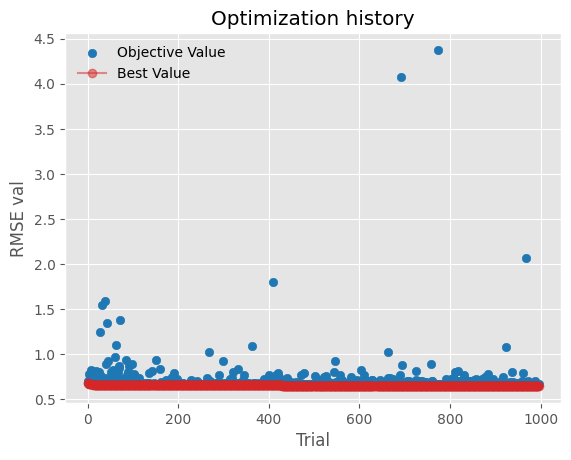


Creating model, loading weights and computing metrics...
Model: "MODEL_CNN_V3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT (InputLayer)             [(None, 105)]        0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 105, 1)       0           ['INPUT[0][0]']                  
                                                                                                  
 CONVOLUTIONAL0 (Conv1D)        (None, 105, 27)      1134        ['reshape_2[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 105, 27)     108         ['CONVOLUTIONAL0[0][0]']         
 alization)                  

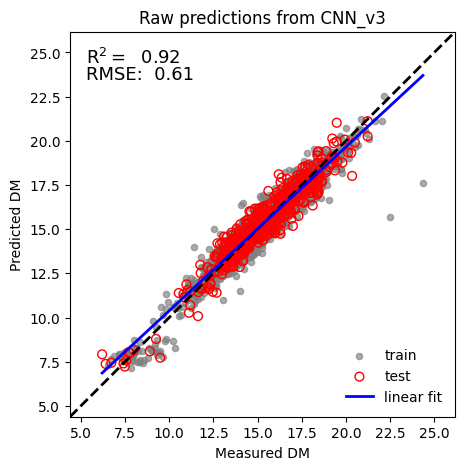

In [25]:
study_v3 = optuna.load_study(study_name="study_v3", storage="sqlite:///optimization_files/study_v2C.db")

print('Result of optimization study after {} trials'.format(len(study_v3.trials)))
print('Best trial:', study_v3.best_trial.number)
print('Best trial value:',study_v3.best_trial.value)
print('Best trial hyperparameters:',study_v3.best_trial.params)

optuna.visualization.matplotlib.plot_optimization_history(study_v3)
plt.title('Optimization history')
plt.ylabel('RMSE val')
plt.legend(frameon=False)
# optuna.visualization.matplotlib.plot_param_importances(study_v3)
plt.show()
plt.style.use('default')

print('\nCreating model, loading weights and computing metrics...')
## Read the best trial parameters from previous prints and fill in to create the model
## PARMS: num_CONV_layers, num_CONV_filters, filter_sizes, num_FC_layers, num_FC_units,  DROPOUT, reg_beta
# @deep-cybertron (BEST!)
model_cnn_v3 = create_model_3(3, [27,15,15], [41,39,35], 1, [68], [], 0.0745)
model_cnn_v3.load_weights("optimization_files/multioutput_models_v2C/study_v3c2_trial=798(2).h5")
# @Athena
# model_cnn_v3 = create_model_3(3, [21,23,13], [43,37,21], 1, [80], [], 0.067)
# model_cnn_v3.load_weights("multioutput_models_v3/study_v3_trial=495(2).h5")
# @cybertron 
# model_cnn_v3 = create_model_3(3, [20,25,13], [35,41,35], 1, [84], [], 0.0575)
# model_cnn_v3.load_weights("multioutput_models_v3/study_v3_trial=226(2).h5")
model_cnn_v3.summary()

## Compute metrics of final model for TRAIN and TEST sets
y_train_pred_v3 = model_cnn_v3.predict(x_train_scaled_col)[1]
y_test_pred_v3 = model_cnn_v3.predict(x_test_scaled_col)[1]


## Plot the prediction metrics using the custom function "plot_prediction2", defined in the initial Help section.
plot_prediction2(y_train,  y_test, y_train_pred_v3,  y_test_pred_v3, title='Raw predictions from CNN_v3', \
                  savefig=True, figname='prediction_v3.png')


# ########### Compute metrics Train and test classifications  #####################
label_train_pred_v3 = model_cnn_v3.predict(x_train_scaled_col)[0]
label_test_pred_v3 = model_cnn_v3.predict(x_test_scaled_col)[0]
## Convert the one-hot encoded labels into a single integer class
class_train_pred_v3 = np.argmax(label_train_pred_v3, axis=1)
class_test_pred_v3 = np.argmax(label_test_pred_v3, axis=1)

print('\nTrain metrics')
print(classification_report(class_train, class_train_pred_v3))
print('\nTest metrics')
print(classification_report(class_test, class_test_pred_v3))


########### Compute metrics on individual fruits  ###############################
## list to store the mean spectra of each fruit in the test set
mean_x_test_list = []

for x_fruto, y_fruto, class_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], class_test_list[:-1], fruits[:-1]):
    ## standardize the spectra of each fruit in the test set
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))

    ## store mean spectra of each fruit in the test set
    mean_x_test_list.append(np.mean(np.array(x_fruto), axis=0))
    
    ## Compute metrics for TRAIN and TEST sets
    y_fruto_pred_v3 = model_cnn_v3.predict(x_fruto_scaled, verbose=0)[1]
    class_fruto_pred_v3 = np.argmax(model_cnn_v3.predict(x_fruto_scaled, verbose=0)[0],axis=1)

    ## Compute test error scores
    scoreR2_fruto = r2_score(y_fruto, y_fruto_pred_v3)
    rmse_fruto = np.sqrt(mean_squared_error(y_fruto, y_fruto_pred_v3))
    acc_fruto = accuracy_score(class_fruto, class_fruto_pred_v3)
    
    print(f'\n\t {name_fruto}')
    print('\t R2: \t %5.3f' % (scoreR2_fruto))
    print('\t RMSE: \t %5.3f' % (rmse_fruto))
    print('\t ACC: \t %5.3f' % (acc_fruto))

print('Test RMSE:', np.sqrt(mean_squared_error(y_test, model_cnn_v3.predict(x_test_scaled_col)[1])))
print('Test ACC:', accuracy_score(class_test, np.argmax(model_cnn_v3.predict(x_test_scaled_col)[0],axis=1)))

print('Best trial hyperparameters:',study_v3.best_trial.params)

In [ ]:
## update 28/08/2023 with ensemble metrics
run_Nx_cnnRC_v3_metrics(N=10, NUM_CONV_LAYERS = 3, NUM_CONV_FILTERS = [27,15,15], FILTER_SIZES = [41,39,35], NUM_FC_LAYERS = 1, 
                        NUM_FC_UNITS = [68], DROPOUT_RATE = [], REG_BETA = 0.0745, BATCH_SIZE = 64, LR = 0.03, EPOCHS=496,
                        XTRAIN = x_train_scaled_col, YTRAIN = y_train, LABELS_TRAIN = labels_train, CLASS_TRAIN = class_train,
                        XTEST = x_test_scaled_col, YTEST = y_test,  CLASS_TEST = class_test,
                        MODEL_NAME = 'final_CNN_10x_v3_update.h5' )

updated metrics on 28/08/2023 with ensemble prediction
```
10x metrics with ensemble prediction
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.931  		 0.894 		 0.918
RMSE: 		 0.565+-0.030 		 0.695+-0.027 	 0.61232
ACC: 		 1.000 			 0.999 		 1.000
------------------------------------------------------
```

## CNN Summary

Load all studies and compute additional information for comparison purposes.

In [26]:
study_v1 = optuna.load_study(study_name="study_v1", storage="sqlite:///optimization_files/study_v1.db")
study_v1B = optuna.load_study(study_name="study_v1B", storage="sqlite:///optimization_files/study_v1B.db")
study_v1C = optuna.load_study(study_name="study_v1C", storage="sqlite:///optimization_files/study_v1C.db")
study_v1D = optuna.load_study(study_name="study_v1D", storage="sqlite:///optimization_files/study_v1D.db")
study_v1E = optuna.load_study(study_name="study_v1E", storage="sqlite:///optimization_files/study_v1E.db")
study_v1F = optuna.load_study(study_name="study_v3A2", storage="sqlite:///optimization_files/study_v1F.db")
study_v2 = optuna.load_study(study_name="study_v2", storage="sqlite:///optimization_files/study_v2.db")
study_v2B = optuna.load_study(study_name="study_v2B", storage="sqlite:///optimization_files/study_v2B.db")
study_v2C = optuna.load_study(study_name="study_v3", storage="sqlite:///optimization_files/study_v2C.db")

## Extract the values of the objective function (RMSE) for each trial
values_v1 = study_v1.trials_dataframe()['value']
values_v1B = study_v1B.trials_dataframe()['value']
values_v1C = study_v1C.trials_dataframe()['value']
values_v1D = study_v1D.trials_dataframe()['value']
values_v1E = study_v1E.trials_dataframe()['value'] ## add -0.01 if needed to better visualize the diff between _v1E and _v2C in the boxplot
values_v1F = study_v1F.trials_dataframe()['value']
values_v2 = study_v2.trials_dataframe()['value']
values_v2B = study_v2B.trials_dataframe()['value']
values_v2C = study_v2C.trials_dataframe()['value']

In [28]:
## These are the metrics of the HPO objective function (RMSECV). These values were the ones used to choose the best models for each architecture + strategy.
## The are the values in the first column of table 5 in the paper.
nom = ['CNN-R_v1','CNN-R_v1B','CNN-R_v1C', 'CNN-R_v1D','CNN-R_v1E','CNN-R_v1F','CNN-RC_v2','CNN-RC_v2B','CNN-RC_v2C']
print('Model   \t Min RMSECV \t Mean RMSECV+-Std ')
print('---------------------------------'*2)
for j,i in enumerate([values_v1,values_v1B,values_v1C,values_v1D,values_v1E,values_v1F,values_v2,values_v2B,values_v2C]):
    print(nom[j],'\t',np.round(np.min(i),3),'\t\t',np.round(np.mean(i),3),'+-',np.round(np.std(i),3))


Model   	 Min RMSECV 	 Mean RMSECV+-Std 
------------------------------------------------------------------
CNN-R_v1 	 1.109 		 1.408 +- 0.334
CNN-R_v1B 	 0.665 		 0.708 +- 0.146
CNN-R_v1C 	 0.658 		 0.706 +- 0.076
CNN-R_v1D 	 0.649 		 0.694 +- 0.045
CNN-R_v1E 	 0.642 		 0.678 +- 0.03
CNN-R_v1F 	 0.985 		 1.336 +- 0.747
CNN-RC_v2 	 0.664 		 0.705 +- 0.075
CNN-RC_v2B 	 0.659 		 0.7 +- 0.063
CNN-RC_v2C 	 0.645 		 0.693 +- 0.184


In [29]:
study_v1E.trials_dataframe().head()

number     value             datetime_start          datetime_complete  \
0       0  0.680739 2023-06-18 08:15:36.046372 2023-06-18 08:19:12.691932   
1       1  0.745295 2023-06-18 08:19:12.719968 2023-06-18 08:21:36.731331   
2       2  0.743221 2023-06-18 08:21:36.761222 2023-06-18 08:23:38.185304   
3       3  0.850877 2023-06-18 08:23:38.213214 2023-06-18 08:25:40.373930   
4       4  0.749801 2023-06-18 08:25:40.398069 2023-06-18 08:27:57.784553   

                duration  params_batch_size  params_num_FC_UNITS  \
0 0 days 00:03:36.645560                128                   88   
1 0 days 00:02:24.011363                352                  160   
2 0 days 00:02:01.424082                512                  168   
3 0 days 00:02:02.160716                352                   32   
4 0 days 00:02:17.386484                384                  224   

   params_num_conv_filters  params_reg_beta     state  
0                       30           0.0555  COMPLETE  
1                       19           0.2895  COMPLETE  
2                       24           0.2245  COMPLETE  
3                        1           0.0900  COMPLETE  
4                       26           0.2895  COMPLETE

Boxplot these values to compare the different studies.

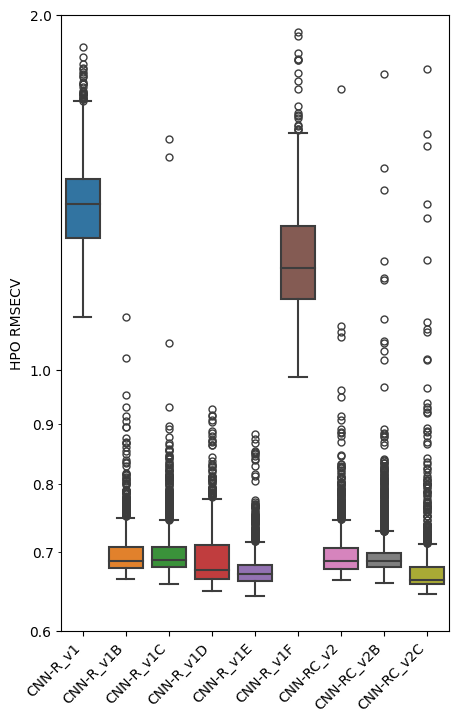

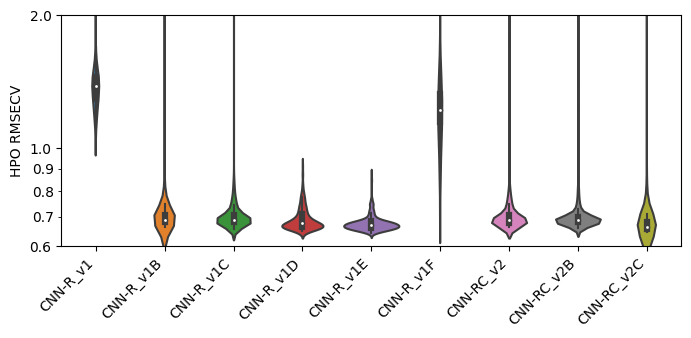

In [31]:
## Boxplot
plt.figure(figsize=(5,8))
sns.boxplot(data=[values_v1,values_v1B,values_v1C,values_v1D,values_v1E, values_v1F, values_v2,values_v2B,values_v2C],
            dodge=True, flierprops={"marker": "o", "markerfacecolor":"None"})

plt.xticks([0,1,2,3,4,5,6,7,8],['CNN-R_v1','CNN-R_v1B','CNN-R_v1C',
                                'CNN-R_v1D','CNN-R_v1E','CNN-R_v1F','CNN-RC_v2','CNN-RC_v2B','CNN-RC_v2C'],
                              rotation=45, ha='right')

plt.yscale('log')
plt.ylabel(r'HPO RMSECV')
plt.ylim(0.6,2)
custom_ticks = [0.6,  1,  2.0]
ax = plt.gca() 
ax.set_yticks(custom_ticks)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
plt.savefig('boxplot.png', dpi=150, bbox_inches='tight')
# plt.show()


## Violinplot
plt.figure(figsize=(8,3))
sns.violinplot(data=[values_v1,values_v1B,values_v1C,values_v1D,values_v1E, values_v1F, values_v2,values_v2B,values_v2C],
            dodge=False, flierprops={"marker": "o", "markerfacecolor":"None"})
plt.xticks([0,1,2,3,4,5,6,7,8],['CNN-R_v1','CNN-R_v1B','CNN-R_v1C',
                              'CNN-R_v1D','CNN-R_v1E', 'CNN-R_v1F','CNN-RC_v2','CNN-RC_v2B','CNN-RC_v2C'],
                              rotation=45, ha='right')
plt.ylabel(r'HPO RMSECV')
plt.ylim(0.6,2)
plt.yscale('log')
custom_ticks = [0.6,  1,  2.0]
ax = plt.gca() 
ax.set_yticks(custom_ticks)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())

plt.show()

In [32]:
print('We peformed',998+635+761,'trials for architecture _v2C')

We peformed 2394 trials for architecture _v2C


## 5) PLS metrics

We compute a PLS model based on all train data and apply it to the test set and see how if fairs. We also compute PLS models for each fruit based on the full train set and on each individual fruit train data. Local PLS was computed separately by P. Mishra using MATLAB. 

Helpfull functions for PLS analysis defined in the HELP section above.

Using the multifruit train set, train a PLS and predict the external mango dataset


Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain in RMSE
Stopping criteria reached, 0.656%. Saving component number.
Suggested number of LV based on 5-fold CV RMSE using 1% gain: 7
5 CV RMSE: 0.914



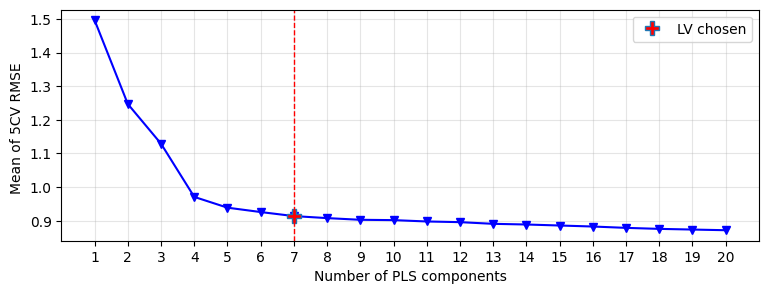

Chosen number of LVs: 7 
CV RMSE: 0.914

Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.824	 0.826
RMSE   	 0.904	 0.892
PG   	 2.386	 2.394
CVAR   	 5.910	 5.810
SDR  	 2.386	 2.394
Fit result: Y= 2.6588343373523564  +  0.8246172549175252  * X


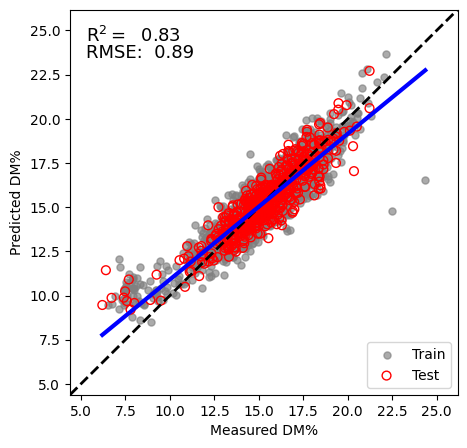

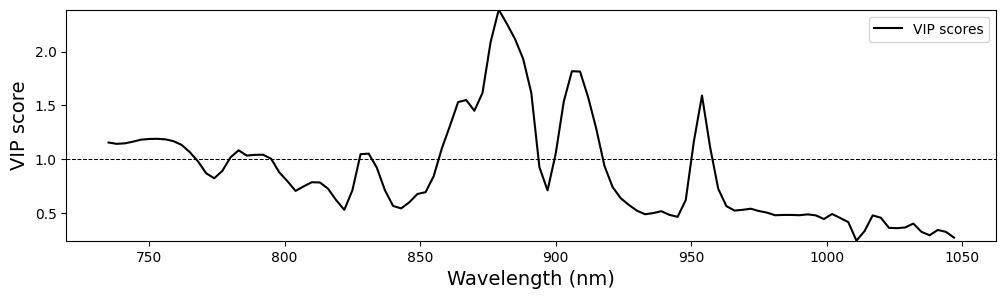

In [34]:
plt.style.use('default')

# x_full_scaled_col, _ = standardize_column(np.concatenate(x_full_list), np.concatenate(x_full_list))

## Find the best #LVs for the PLS model
bestLV, CV_RMSE = pls_optimization_cv_stop2(x_train_scaled_col, y_train, nmax=20, plot_opt=True)
print('Chosen number of LVs:', bestLV, '\nCV RMSE:', CV_RMSE)

## Predict the test set using the optimal number of LVs (visually extracted from the plot above)
f = pls_prediction_metrics2(w[150:255],x_train_scaled_col, y_train, x_test_scaled_col, y_test, 
                       '2d derivative','DM%', lv=bestLV, 
                       plot_pred=True, plot_vip=True)

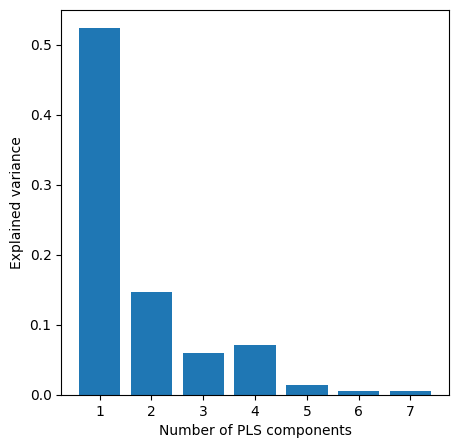

(array([0.52367461, 0.14619265, 0.05940898, 0.07048206, 0.0133205 ,
        0.00544116, 0.00587983]),
 0.824399784717145)

In [35]:
pls2 = PLSRegression(n_components=7)
pls2.fit(x_train_scaled_col, y_train)
pls_explained_variance(pls2, x_train_scaled_col, y_train)

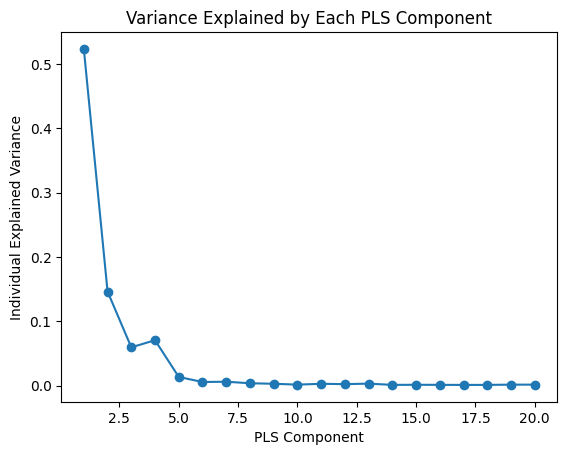

Individual Explained Variance: [0.5236746100474771, 0.14619264826230696, 0.059408981855115076, 0.07048205502680506, 0.013320496227183863, 0.005441162670309667, 0.005879830305376213, 0.0034940072203863445, 0.002713272103607215, 0.001348205769172402, 0.0026451994738815646, 0.0021326844949659447, 0.002906924401880095, 0.000978507981765673, 0.0011177040527004668, 0.0010136579328157865, 0.0009045435505854923, 0.0009417183909436578, 0.0013345494280519385, 0.0013425616327345318]


In [36]:
from sklearn.metrics import explained_variance_score

max_components = 20

pls = PLSRegression(n_components=max_components)
pls.fit(x_train_scaled_col, y_train)

individual_variances = []

for i in range(max_components):
    # Get the scores for the i-th component
    scores = pls.x_scores_[:, i]
    # Calculate the variance explained by this component
    variance = np.corrcoef(y_train.reshape(-1), scores)[0, 1]**2
    individual_variances.append(variance)

# Plotting the results
plt.plot(range(1, max_components+1), individual_variances, marker='o')
plt.xlabel('PLS Component')
plt.ylabel('Individual Explained Variance')
plt.title('Variance Explained by Each PLS Component')
plt.show()
print('Individual Explained Variance:', individual_variances)

Use the full train data set and predict fruits individually


Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.824	 0.821
RMSE   	 0.904	 0.745
PG   	 2.386	 2.056
CVAR   	 5.910	 4.840
SDR  	 2.386	 2.056


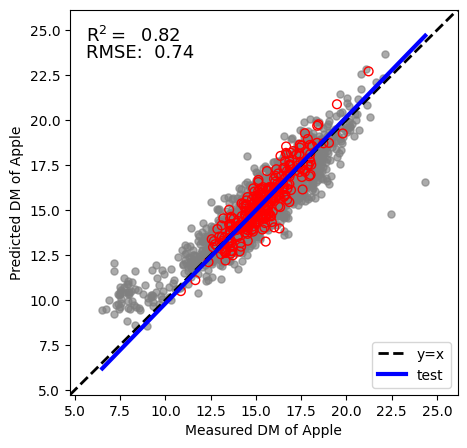

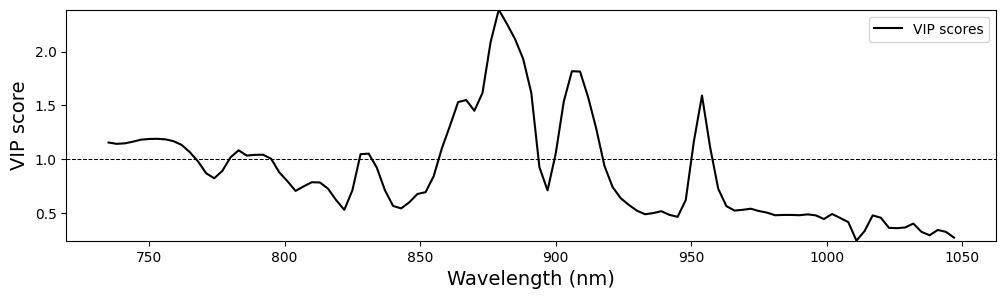


Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.824	 0.878
RMSE   	 0.904	 1.328
PG   	 2.386	 2.500
CVAR   	 5.910	 8.220
SDR  	 2.386	 2.500


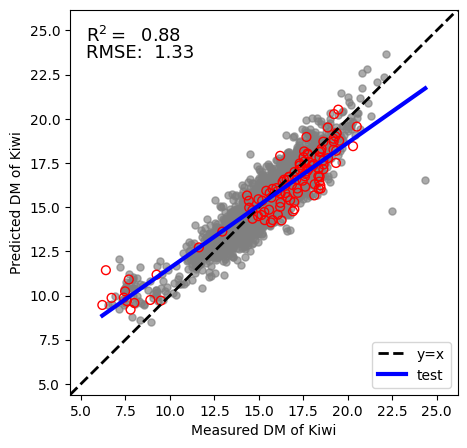

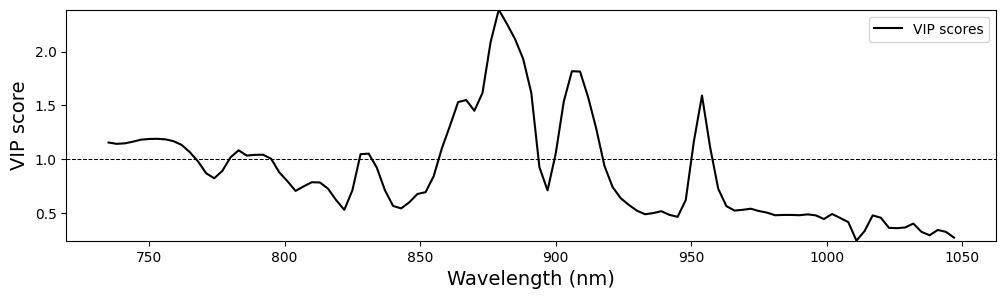


Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.824	 0.872
RMSE   	 0.904	 0.694
PG   	 2.386	 2.794
CVAR   	 5.910	 4.650
SDR  	 2.386	 2.794


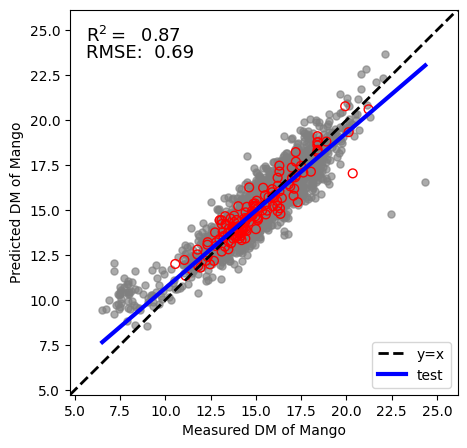

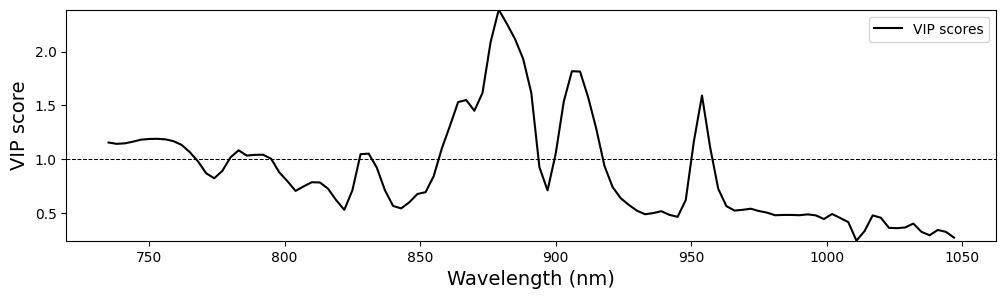


Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.824	 0.693
RMSE   	 0.904	 0.944
PG   	 2.386	 1.781
CVAR   	 5.910	 6.470
SDR  	 2.386	 1.781


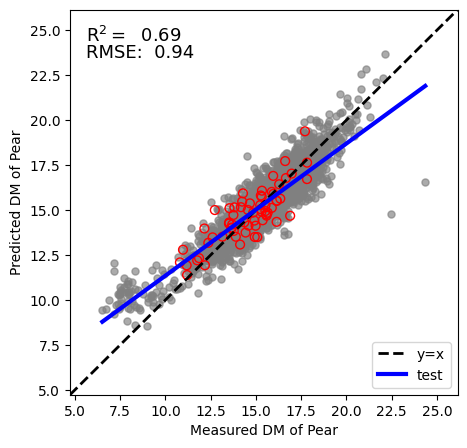

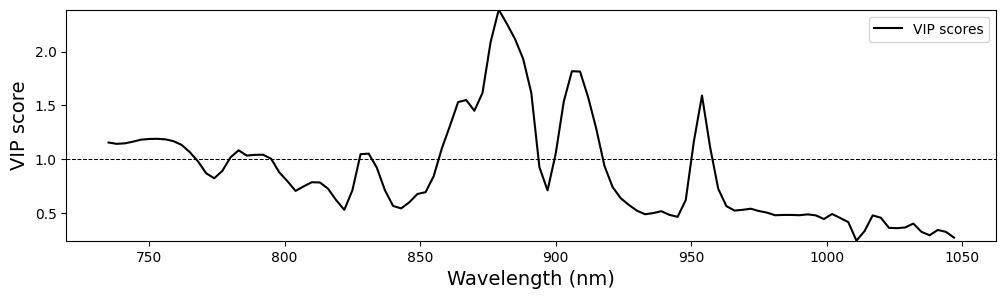

In [ ]:
for x_fruto, y_fruto, class_fruto, name_fruto in zip(x_test_list[:-1], y_test_list[:-1], class_test_list[:-1], fruits[:-1]):
    ## standardize the spectra of each fruit in the test set
    _, x_fruto_scaled = standardize_column(np.concatenate(x_train_list[:-1]), np.array(x_fruto))

    ## Compute metrics for TRAIN and TEST sets
    pls_prediction_metrics2(w[150:255],x_train_scaled_col, y_train, x_fruto_scaled, y_fruto, 
                       '2d derivative','DM of '+name_fruto, lv=7, 
                       plot_pred=True, plot_vip=True)

Make an individual PLS model for each fruit (based only on its train data)

*************** Apple ***************

Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain
Stopping criteria reached, 0.632%. Saving component number.
Suggested number of LV based in Mean of 5 CV RMSE: 5
Minimum found in 5 CV RMSE: 0.627



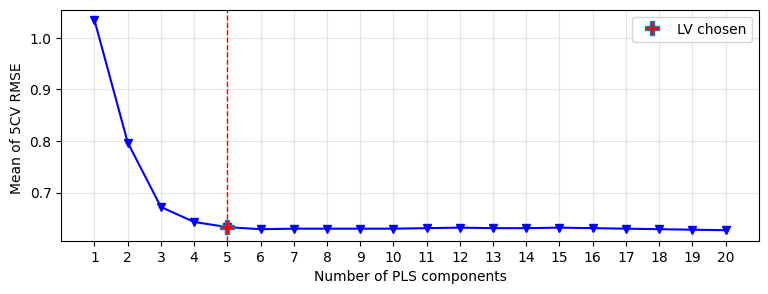

Best number of LVs: 5 
CV RMSE: 0.627

Error metrics for best PLS model with LV = 5
METRIC 	 TRAIN 	 TEST 
R2     	 0.849	 0.861
RMSE   	 0.615	 0.574
PG   	 2.577	 2.668
CVAR   	 3.960	 3.730
SDR  	 2.577	 2.668


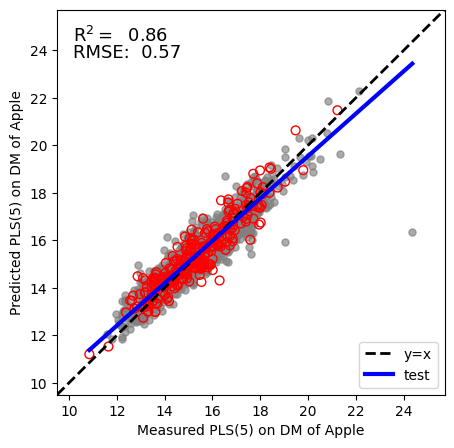

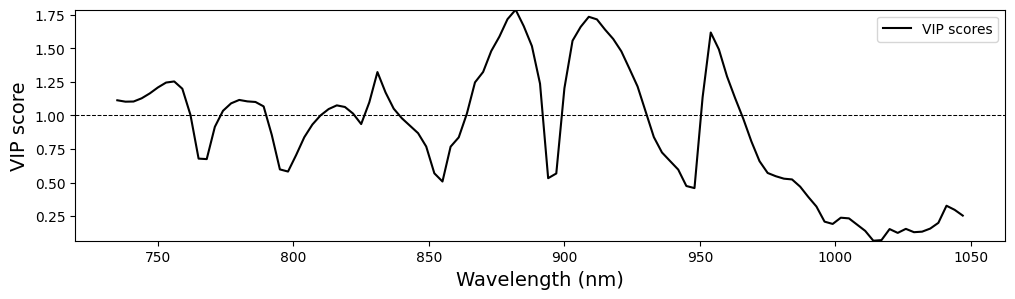

*************** Kiwi ***************

Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain
Stopping criteria reached, 0.0%. Saving component number.
Suggested number of LV based in Mean of 5 CV RMSE: 8
Minimum found in 5 CV RMSE: 0.809



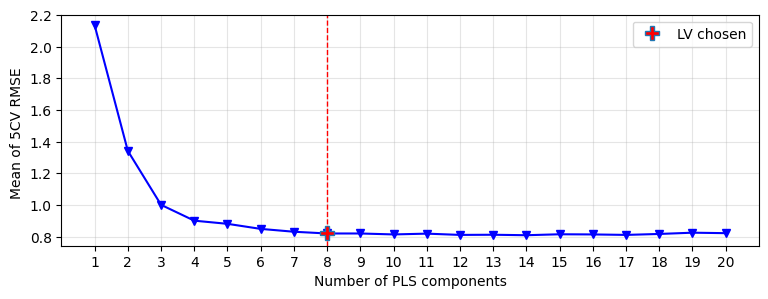

Best number of LVs: 8 
CV RMSE: 0.809

Error metrics for best PLS model with LV = 8
METRIC 	 TRAIN 	 TEST 
R2     	 0.947	 0.927
RMSE   	 0.767	 0.908
PG   	 4.338	 3.657
CVAR   	 4.940	 5.620
SDR  	 4.338	 3.657


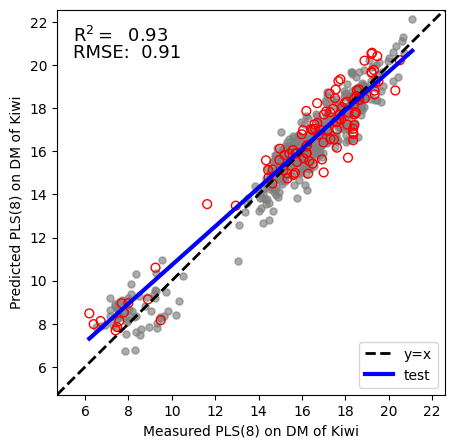

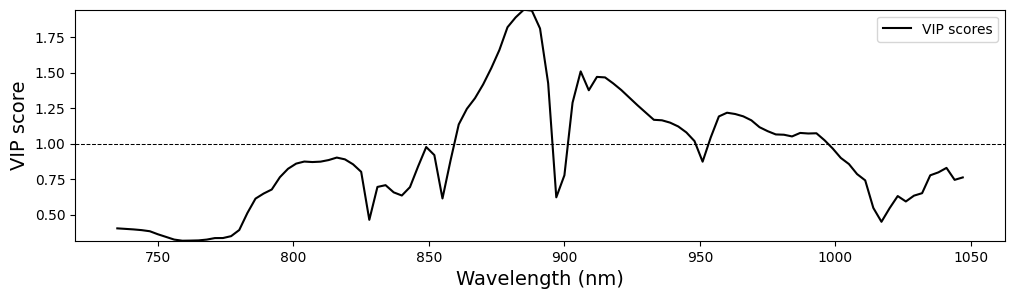

*************** Mango ***************

Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain
Stopping criteria reached, 0.93%. Saving component number.
Suggested number of LV based in Mean of 5 CV RMSE: 7
Minimum found in 5 CV RMSE: 0.731



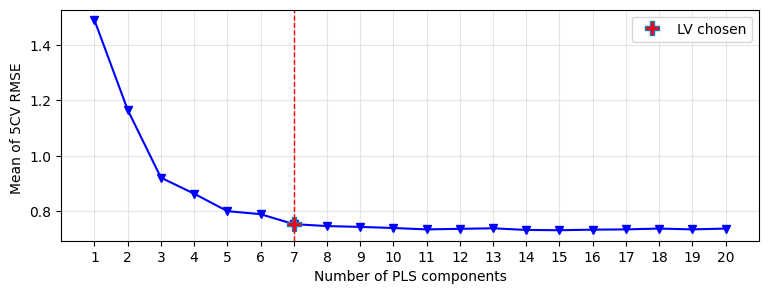

Best number of LVs: 7 
CV RMSE: 0.731

Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.874	 0.879
RMSE   	 0.717	 0.678
PG   	 2.822	 2.857
CVAR   	 4.810	 4.550
SDR  	 2.822	 2.857


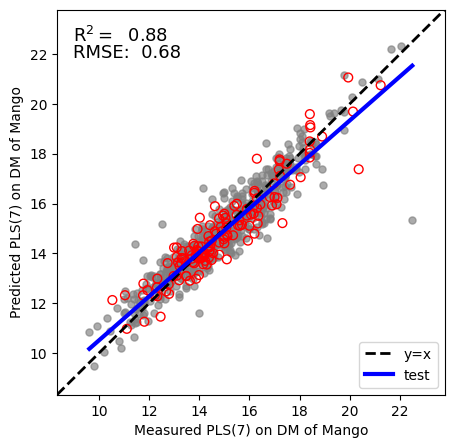

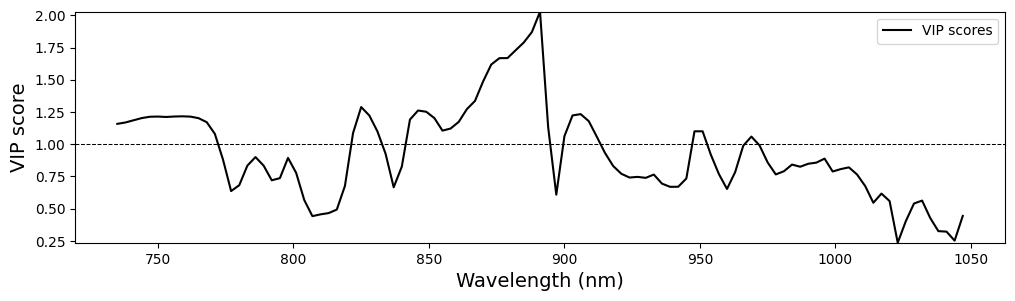

*************** Pear ***************

Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain
Stopping criteria reached, 0.316%. Saving component number.
Suggested number of LV based in Mean of 5 CV RMSE: 7
Minimum found in 5 CV RMSE: 0.633



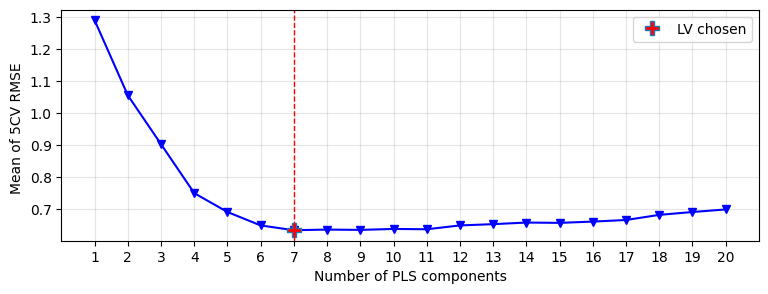

Best number of LVs: 7 
CV RMSE: 0.633

Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.899	 0.872
RMSE   	 0.583	 0.616
PG   	 3.154	 2.728
CVAR   	 3.940	 4.220
SDR  	 3.154	 2.728


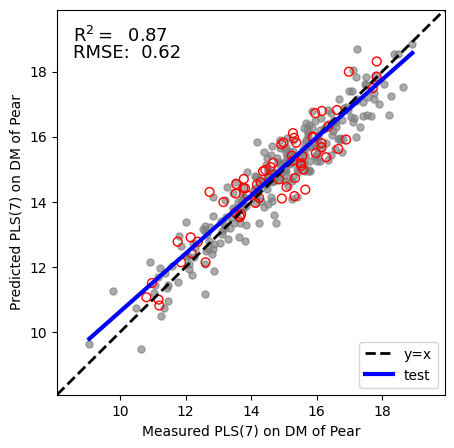

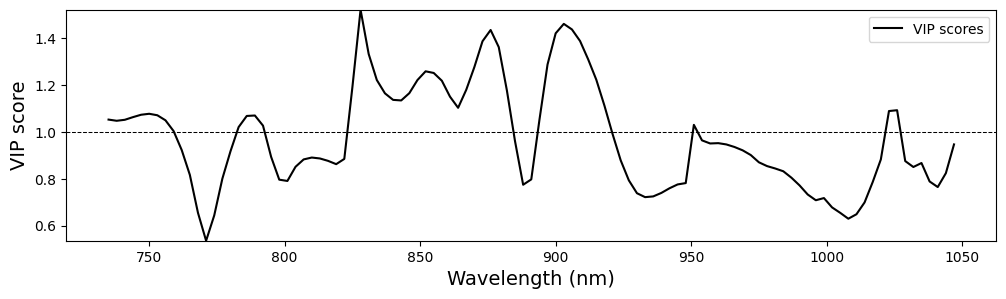

In [ ]:
for x_fruto_train, y_fruto_train, x_fruto_test, y_fruto_test, name_fruto in zip(x_train_list[:-1], y_train_list[:-1],
                                                                                x_test_list[:-1], y_test_list[:-1], fruits[:-1]):
    ## standardize the spectra of each fruit in the test set
    x_fruto_train_scaled, x_fruto_test_scaled = standardize_column(np.array(x_fruto_train), np.array(x_fruto_test))

    print(f'*************** {name_fruto} ***************')
    lv_fruto, cv_rmse_fruto = pls_optimization_cv_stop2(x_fruto_train_scaled, y_fruto_train, nmax=20, plot_opt=True )
    print('Best number of LVs:', lv_fruto, '\nCV RMSE:', cv_rmse_fruto)
    
    ## Compute metrics for TRAIN and TEST sets
    pls_prediction_metrics2(w[150:255],x_fruto_train_scaled, y_fruto_train, x_fruto_test_scaled, y_fruto_test, 
                       '2d derivative','PLS('+str(lv_fruto)+') on DM of '+name_fruto, lv=lv_fruto, 
                       plot_pred=True, plot_vip=True)

## <font color='red'>6) EXPERIMENTAL: </font> External Mango dataset predictions

Trial and error tests indicates that the Felix second derivative can be reproduced using <code>savgol_filter(0.5*spec, 9,2,2)</code>. Now we can proceed to the computing the second derivative of the external mango dataset and use that as external validation set.

In [37]:
data_mango = pd.read_csv("data/NAnderson2020MendeleyMangoNIRData.csv")
w_mango = np.array(np.ravel(data_mango.columns.values[9:]), dtype=int).reshape(-1,1)
# w_mango

print(data_mango.columns)

Index(['Set', 'Season', 'Region', 'Date', 'Type', 'Cultivar', 'Pop', 'Temp',
       'DM', '285',
       ...
       '1173', '1176', '1179', '1182', '1185', '1188', '1191', '1194', '1197',
       '1200'],
      dtype='object', length=315)


In [39]:
print('Shape:', np.shape(data_mango))
## The test set is the data from season 4
print('Test set shape:', np.shape(data_mango[data_mango.Season==4]))

Shape: (11691, 315)
Test set shape: (1448, 315)


Overlay the preprocessed external mango spectra with the multifruit mango spectra to check if they are similar.

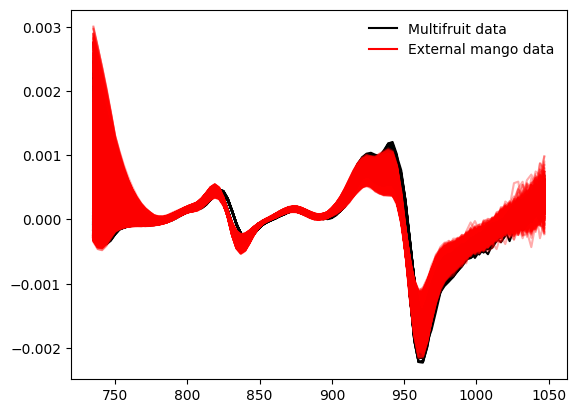

In [40]:
import matplotlib.lines as mlines

## Get all mango data available for training in Anderson's 2020 dataset (Cal and Tuning sets)
x_mango_ext_train = data_mango[(data_mango['Set']=='Tunning') | (data_mango['Set']=='Cal')].iloc[:,9:].values
y_mango_ext_train = data_mango[(data_mango['Set']=='Tunning') | (data_mango['Set']=='Cal')]['DM'].values
## Define a class (2) for the external train set (just mangoes)
class_mango_ext_train = np.array([2]*len(y_mango_ext_train))
labels_mango_ext_train = to_categorical(class_mango_ext_train, num_classes = 4)

## The external validation set
x_mango_ext_val = data_mango[data_mango['Set']=='Val Ext'].iloc[:,9:].values
y_mango_ext_val = data_mango[data_mango['Set']=='Val Ext']['DM'].values
class_mango_ext = np.array([2]*len(y_mango_ext_val))
labels_mango_ext = to_categorical(class_mango_ext, num_classes=4)

## Compute second derivative of the train set
x_mango_ext_train_2d = savgol_filter(0.5*x_mango_ext_train, 9, 2, 2)
## Compute second derivative of the external validation set
x_mango_ext_val_2d = savgol_filter(0.5*x_mango_ext_val, 9, 2, 2)

## Plot the 2nd derivative spectra of the mangoes in our training set (black) and in this external validation set (red)
g1 = plt.plot(w[wi:wf].T, data['mango_sp'][:, wi:wf].T, 'k', label='Training set')
g2 = plt.plot(w_mango[wi:wf], x_mango_ext_train_2d[:,wi:wf].T, 'r',  alpha=0.33, label= 'External mango set')
black_line = mlines.Line2D([], [], color='black', label='Multifruit data')
red_line = mlines.Line2D([], [], color='red', label='External mango data')
plt.legend(handles=[black_line, red_line],frameon=False, loc='upper right')
plt.show()

## This might be one questionable step, but we will standardize the spectra of the mangoes in the external validation set
## having as reference the mean and std of the spectra of the full multifruit set
x_full_scaled, x_mango_ext_train_2d_scaled = standardize_column(x_full, x_mango_ext_train_2d[:, wi:wf])
x_full_scaled, x_mango_ext_val_2d_scaled = standardize_column(x_full, x_mango_ext_val_2d[:, wi:wf])

There seems to be a shift in some of the peaks, but since we don't have access to the second derivative directly exported from the spectrometers (on the external mango data), this is what we have to work with. We will proceed with the analysis and see how it goes.

In [41]:
## Print the dimensions of the data sets
print('External mango data train split shape:', np.shape(x_mango_ext_train_2d_scaled))
print('External mango data test split shape:', np.shape(x_mango_ext_val_2d_scaled))
print('Multifruit data full shape:', np.shape(x_full_scaled))

External mango data train split shape: (7413, 105)
External mango data test split shape: (1448, 105)
Multifruit data full shape: (2997, 105)


Train model on multifruit full dataset and test os the external mango test partition.

Tweaking _v1E on all the available data before applying it to the external mango. As we saw in section 4.1.5, tipling beta to 0.021 decreases overfitting while maintaining the same performance on the validation set. We will use this value for the external mango.

In [ ]:
## Retrain the optimized model on the full training data and compute final metrics 10 times
run_Nx_cnnR_v1E_metrics(N=10, NUM_CONV_FILTERS = 12, NUM_FC_UNITS = 80, REG_BETA = 0.021, BATCH_SIZE = 512, LR = 0.03,EPOCHS='auto',
                         XTRAIN = x_full_scaled, YTRAIN = y_full,  XTEST = x_mango_ext_val_2d_scaled, YTEST = y_mango_ext_val, 
                         MODEL_NAME = 'final_CNN_10x_v1E_mangoext2.h5')

```
------------------------------------------------------
MEAN ERROR METRICS: 	 TRAIN  	 TEST 		 10 ENSEMBLE TEST
------------------------------------------------------
R2: 		 0.922  		 0.803 		 0.806
RMSE: 		 0.601+-0.003 		 1.186+-0.026 	 1.17506
------------------------------------------------------
```

##### PLS Prediction for external mango data


Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain in RMSE
Stopping criteria reached, 0.656%. Saving component number.
Suggested number of LV based on 5-fold CV RMSE using 1% gain: 7
5 CV RMSE: 0.914



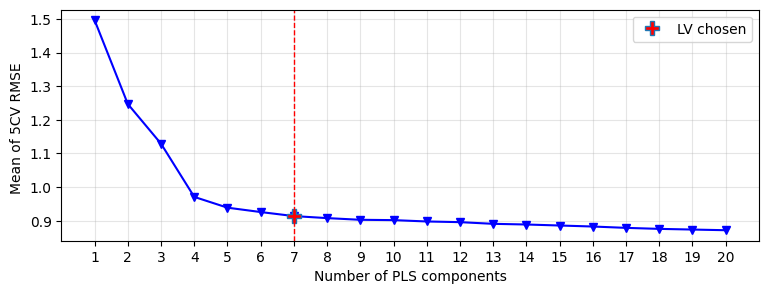


Error metrics for best PLS model with LV = 7
METRIC 	 TRAIN 	 TEST 
R2     	 0.825	 0.803
RMSE   	 0.900	 1.331
PG   	 2.391	 2.005
CVAR   	 5.880	 7.820
SDR  	 2.391	 2.005


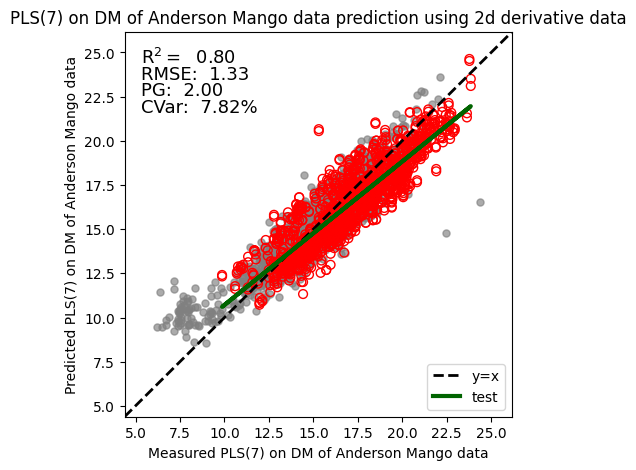

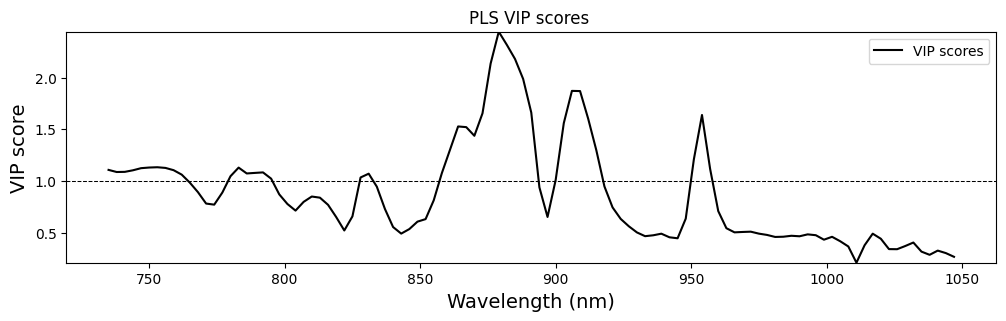


Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain in RMSE
Stopping criteria reached, 0.531%. Saving component number.
Suggested number of LV based on 5-fold CV RMSE using 1% gain: 11
5 CV RMSE: 0.942



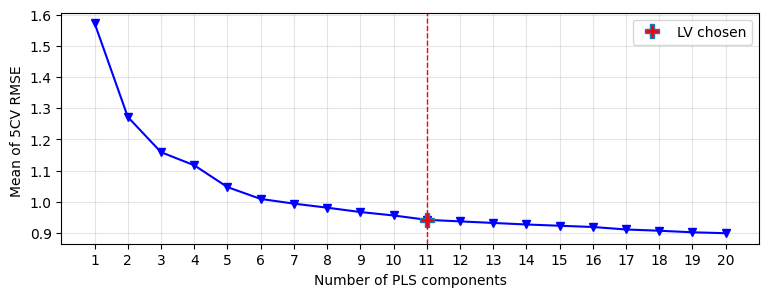


Error metrics for best PLS model with LV = 11
METRIC 	 TRAIN 	 TEST 
R2     	 0.860	 0.831
RMSE   	 0.933	 1.101
PG   	 2.670	 2.425
CVAR   	 5.700	 6.470
SDR  	 2.670	 2.425


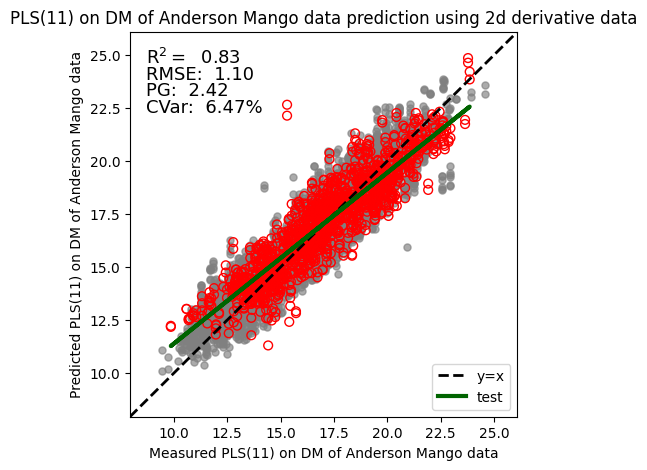

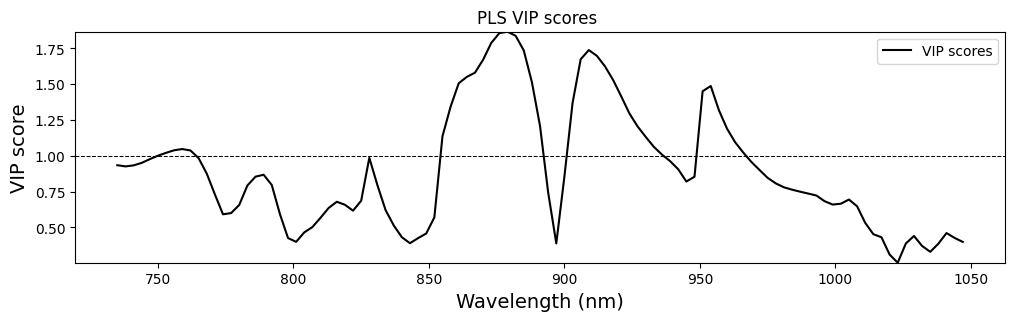

(0.86, 0.933, 2.67, 5.7, 2.67, 0.831, 1.101, 2.425, 6.47, 2.425)

In [ ]:
lv_fruto, _ = pls_optimization_cv_stop2(x_train_scaled_col, y_train, nmax=20, plot_opt=True)


# Train PLS on multifruit data and predict external mango data
pls_prediction_metrics(w[150:255],x_full_scaled, y_full, x_mango_ext_val_2d_scaled, y_mango_ext_val.reshape(-1,1), 
                      '2d derivative','PLS('+str(lv_fruto)+') on DM of Anderson Mango data', lv=lv_fruto, 
                       plot_pred=True, plot_vip=True)

lv_fruto, _ = pls_optimization_cv_stop2(x_mango_ext_train_2d_scaled, y_mango_ext_train, nmax=20, plot_opt=True)

# train PLS on external mango data and predict external mango data
pls_prediction_metrics(w[150:255],x_mango_ext_train_2d_scaled, y_mango_ext_train, x_mango_ext_val_2d_scaled, y_mango_ext_val, 
                      '2d derivative','PLS('+str(lv_fruto)+') on DM of Anderson Mango data', lv=lv_fruto, 
                       plot_pred=True, plot_vip=True)